<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Denmark/DANSKE/DANSKE_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "DANSKE.CO"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   49.28   50.20   48.35   50.20      39.80   875297
2009-01-05   51.36   52.05   50.66   51.13      40.53  1249226
2009-01-06   51.82   52.51   50.66   52.28      41.45  1481986
2009-01-07   52.75   54.37   50.90   52.98      42.00   917488
2009-01-08   51.82   56.68   51.59   55.29      43.84  1464221
...            ...     ...     ...     ...        ...      ...
2018-12-19  137.55  137.55  132.75  134.50     125.98  2145376
2018-12-20  132.10  132.20  128.85  129.25     121.06  2256234
2018-12-21  125.40  128.65  123.00  128.25     120.13  4398625
2018-12-27  129.00  131.20  126.20  126.20     118.21  1980708
2018-12-28  127.45  129.75  127.00  128.90     120.74  1619778

[2496 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2496.000000  2496.000000  2496.000000  2496.000000  2496.000000  2.496000e+03
mean    148.295725   149.703169   146.736887   148.216967   124.494583  1.930118e+06
std      54.843365    54.982454    54.685535    54.813747    51.932659  2.186110e+06
min      31.740000    31.930000    30.540000    31.000000    24.580000  0.000000e+00
25%     106.575000   107.400000   105.600000   106.400000    84.360000  1.249442e+06
50%     133.720000   135.100000   131.870000   133.720000   107.075000  1.660517e+06
75%     190.600000   192.200000   189.012500   190.525000   163.420000  2.223606e+06
max     258.200000   259.500000   257.400000   257.500000   231.310000  9.361722e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   40.72   41.18   38.87   38.87      30.81  1411112   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   36.170911   37.907471   31.415379   36.848546   36.004203   35.226610      34.935      35.860   31.771648   34.73750   38.710439   34.1425   35.915833   34.73750   38.126667   36.177412               40.564195                 34.73750               28.910805               43.477543                 34.73750               25.997457               46.390890                 34.73750               23.084110               49.304238                 34.73750               20.170762   36.004203   37.819989   35.554994               41.830898                36.004203               30.177508               44.744246                36.004203               27.264161               47.657593                36.004203               24.350813               50.570941   
2009-03-16   40.25   41.18   39.42   40.44      32.06  1701671   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   36.384365   37.869393   32.196549   38.413328   36.989936   35.922505      35.720      35.860   32.524316   35.52375   40.311838   35.4425   37.183056   35.52375   39.655000   36.041663               42.420437                 35.52375               28.627063               45.868781                 35.52375               25.178719               49.317124                 35.52375               21.730376               52.765468                 35.52375               18.282032   36.989936   39.773284   35.534585               43.886623                36.989936               30.093249               47.334967                36.989936               26.644905               50.783310                36.989936               23.196562               54.231654   
2009-03-17   40.53   41.18   39.88   41.18      32.65  1071415

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2.446000e+03  2446.000000  2446.000000  2446.000000    2446.000000   2446.000000     2446.000000     2446.000000       2446.000000  2446.000000  2446.000000  2446.000000  2446.000000   2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000  2446.000000             2446.000000              2446.000000             2446.000000             2446.000000              2446.000000             2446.000000             2446.000000              2446.000000             2446.000000             2446.000000              2446.000000             2446.000000  2446.000000  2446.000000  2446.000000             2446.000000              2446.000000             2446.000000             2446.000000              2446.000000             2446.000000             2446.000000   
mean    150.373091   151.788577   148.822150   150.304092   126.292093  1.948496e+06    15.711365     1.984464   186.486917      30.459935      0.031071        0.030253        0.008177          0.007768     6.635323     2.545789    27.125920     1.984464      2.015536    27.125920   150.110623   149.806385     4.467436   150.308781   150.166557   150.133998   150.061533   149.981504   149.591775   150.168680   150.308776   150.169972   150.215222   150.168680   150.284798   149.882102              155.041746               150.168680              145.295615              157.478279               150.168680              142.859082              159.914812               150.168680              140.422549              162.351345               150.168680              137.986016   150.166557   150.278199   149.924026              155.039622               150.166557              145.293491              157.476155               150.166557              142.856958              159.912688   
std      53.405400    53.534247    53.226304    53.355571    50.889800  2.202889e+06     8.730508     1.403095   103.960774       0.791461      0.173545        0.171319        0.090073          0.087810     3.408681     1.112188    14.865934     1.403095      1.403095    14.865934    53.502347    53.675050   159.100228    53.374825    53.420511    53.449307    53.369696    53.337636    53.527795    53.452084    53.361618    53.466717    53.404601    53.452084    53.364392    53.676655               53.774134                53.452084               53.288232               53.993653                53.452084               53.266142               54.251566                53.452084               53.284038               54.547326                53.452084               53.341880    53.420511    53.358919    53.645384               53.740526                53.420511               53.258807               53.959074                53.420511               53.237828               54.216048   
min      40.250000    41.180000    38.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.002156  0.000000  0.000000  0.000000   0.000000  1411112   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000176  0.567042  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000620                0.000000                 0.000000                0.001257                0.000000                 0.000000                0.003588                0.000000                 0.000000                0.005870                0.000127                 0.000000                0.010517  0.000000  0.000000  0.000093                0.000000                 0.000000                0.000376                0.000000                 0.000000                0.002733                0.000702                 0.000000                0.005040                0.007525                 0.000000   
2009-03-16  0.000000  0.000000  0.002517  0.007181   0.006234  1701671   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000970  0.000000  0.568565  0.007083  0.004473  0.003166    0.003553    0.000000  0.003305  0.003547  0.007290  0.005844  0.005741  0.003547  0.006971  0.000000                0.008431                 0.003547                0.000000                0.010834                 0.003547                0.000000                0.013203                 0.003547                0.000000                0.015515                 0.003547                0.002432  0.004473  0.008907  0.000000                0.009351                 0.004473                0.000000                0.011756                 0.004473                0.000000                0.014801                 0.004473                0.000000                0.023580                 0.004473   
2009-03-17  0.001285  0.000000  0.004622  0.010566  

140279

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1bzu8p27
  JVM stdout: /tmp/tmp1bzu8p27/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1bzu8p27/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_0z8ma3
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.651208  4.020273              0.335813  0.551991  0.304694
1  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.630689  7.667970              0.373382  0.616341  0.379876
2  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.621680  5.684558              0.399106  0.642487  0.412789
3  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.617943  8.412083              0.453957  0.679492  0.461709
4  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.611738  4.567512              0.386361  0.628204  0.394640
5  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.609769  4.475382              0.389730  0.562809  0.316754
6  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.600928  4.706480              0.472441  0.557731  0.311064
7  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.570666  0.697537              0.431836  0.502296  0.252301
8              DeepLearning_1_AutoML_20190824_201817  0.568397  5.473739              0.500000  0.642609  0.412947
9  DeepLearning_grid_1_AutoML_20190824_201817_mod...  0.521353  7.050548              0.500000  0.659068  0.434371

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006117
1           CDLCLOSINGMARUBOZU             0.491382           0.491382    0.003006
2                  CDLLONGLINE             0.474679           0.474679    0.002904
3                 STOCHF_fastk             0.462888           0.462888    0.002832
4               STOCHRSI_fastk             0.393799           0.393799    0.002409
...                        ...                  ...                ...         ...
1038                   MA_14_6             0.130187           0.130187    0.000796
1039  BBANDS_middleband_24_7_4             0.128565           0.128565    0.000786
1040             CDLHIKKAKEMOD             0.125809           0.125809    0.000770
1041            CDLHARAMICROSS             0.124586           0.124586    0.000762
1042        CDLKICKINGBYLENGTH             0.124143           0.124143    0.000759

[1043 rows x 4 columns]

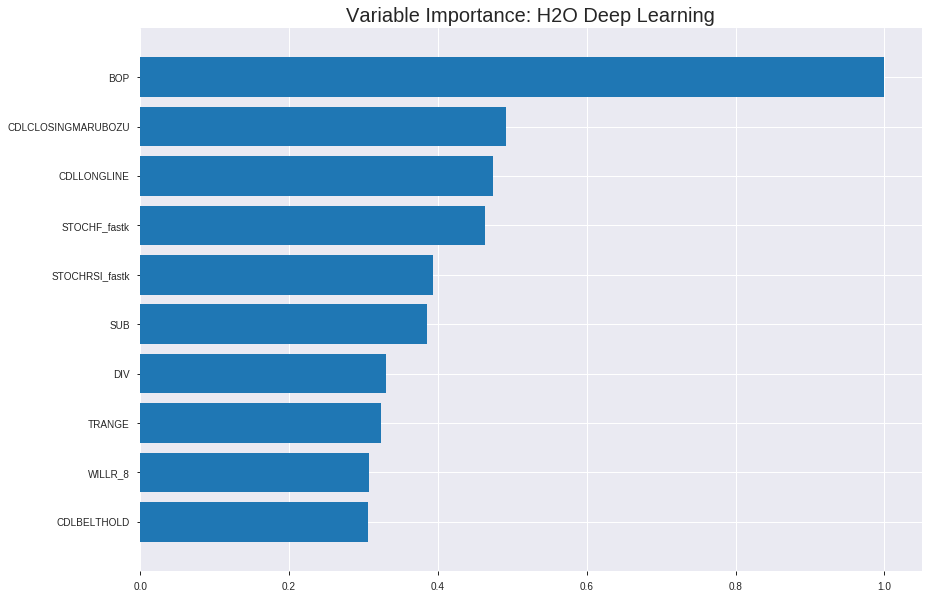

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_201817_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21832575695429143
RMSE: 0.4672534183441481
LogLoss: 0.6255988187325187
Mean Per-Class Error: 0.31385479309113873
AUC: 0.7407062635582282
pr_auc: 0.7525995433974179
Gini: 0.48141252711645643
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5269872900525817: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      353  443   0.5565   (443.0/796.0)
1      115  800   0.1257   (115.0/915.0)
Total  468  1243  0.3261   (558.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.526987     0.741427  219
max f2                       0.297445     0.857764  343
max f0point5                 0.539956     0.706351  201
max accuracy                 0.539956     0.689655  201
max precision                0.927616     1         0
max recall                   0.173471     1         380
max specificity              0.927616     1         0
max absolute_mcc             0.539956     0.374412  201
max min_per_class_accuracy   0.546127     0.675879  193
max mean_per_class_accuracy  0.539956     0.686145  201

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.833336           1.76606   1.76606            0.944444         0.856215  0.944444                    0.856215            0.0185792       0.0185792                  76.606    76.606
    2        0.0204559                   0.780697           1.64995   1.70966            0.882353         0.803342  0.914286                    0.830534            0.0163934       0.0349727                  64.9952   70.9664
    3        0.0303916                   0.746877           1.64995   1.69014            0.882353         0.763556  0.903846                    0.808638            0.0163934       0.0513661                  64.9952   69.0143
    4        0.0403273                   0.718213           1.75995   1.70734            0.941176         0.734028  0.913043                    0.790255            0.0174863       0.0688525                  75.9949   70.7341
    5        0.050263                    0.696544           1.42996   1.65251            0.764706         0.704558  0.883721                    0.773315            0.0142077       0.0830601                  42.9958   65.251
    6        0.100526                    0.642347           1.54379   1.59815            0.825581         0.66356   0.854651                    0.718438            0.0775956       0.160656                   54.3792   59.8151
    7        0.150205                    0.617962           1.40796   1.53525            0.752941         0.62874   0.821012                    0.688771            0.0699454       0.230601                   40.7959   53.5247
    8        0.200468                    0.601945           1.47856   1.52103            0.790698         0.609545  0.813411                    0.668907            0.0743169       0.304918                   47.8561   52.1034
    9        0.300409                    0.577997           1.25757   1.43338            0.672515         0.589052  0.766537                    0.64234             0.125683        0.430601                   25.7566   43.3382
    10       0.400351                    0.561634           1.27944   1.39495            0.684211         0.569512  0.745985                    0.62416             0.127869        0.55847                    27.9436   39.4952
    11       0.500292                    0.547437           1.02792   1.32163            0.549708         0.554083  0.706776                    0.610161            0.102732        0.661202                   2.79232   32.1632
    12       0.600234                    0.533999           1.02792   1.27273            0.549708         0.541136  0.680623                    0.598668            0.102732        0.763934                   2.79232   27.2728
    13       0.717124                    0.52807            0.832126  1.20091            0.445            0.529093  0.642217                    0.587327            0.0972678       0.861202                   -16.7874  20.091
    14       0.800117                    0.499219           0.539914  1.13235            0.288732         0.517178  0.605551                    0.580051            0.0448087       0.906011                   -46.0086  13.2348
    15       0.900058                    0.39412            0.656121  1.07947            0.350877         0.455789  0.577273                    0.566253            0.0655738       0.971585                   -34.3879  7.94685
    16       1                           0.0597741          0.284319  1                  0.152047         0.275093  0.534775                    0.537154            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35296640478119834
RMSE: 0.5941097581938866
LogLoss: 8.269428991257858
Mean Per-Class Error: 0.4176283024597631
AUC: 0.5304518001147215
pr_auc: 0.30590183481475963
Gini: 0.06090360022944297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5106712081119538: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    217  0.9775   (217.0/222.0)
1      0    267  0        (0.0/267.0)
Total  5    484  0.4438   (217.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510671     0.711052  156
max f2                       0.510671     0.86018   156
max f0point5                 0.529058     0.636516  145
max accuracy                 0.529058     0.607362  145
max precision                0.531059     0.59893   138
max recall                   0.510671     1         156
max specificity              1            0.495495  0
max absolute_mcc             0.529058     0.197727  145
max min_per_class_accuracy   0.671792     0.486486  8
max mean_per_class_accuracy  0.529058     0.582372  145

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 77.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.482618                    1                  0.962293  0.962293           0.525424         1         0.525424                    1                   0.464419        0.464419                   -3.77071  -3.77071
    2        0.501022                    0.659109           1.42447   0.979271           0.777778         0.829209  0.534694                    0.993726            0.0262172       0.490637                   42.4469   -2.07292
    3        0.599182                    0.56992            1.29728   1.03137            0.708333         0.602189  0.56314                     0.929583            0.127341        0.617978                   29.7285   3.13686
    4        0.699387                    0.542141           1.42032   1.0871             0.77551          0.554597  0.593567                    0.875857            0.142322        0.7603                     42.0316   8.70951
    5        0.97137                     0.52807            0.826223  1.01405            0.451128         0.530341  0.553684                    0.779113            0.224719        0.985019                   -17.3777  1.40509
    6        1                           0.357525           0.523274  1                  0.285714         0.503781  0.546012                    0.77123             0.0149813       1                          -47.6726  0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:39:14  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 20:39:17  6 min 45.468 sec   204 obs/sec       0.368206  1             630        0.615964         2.32051             -0.525026      0.552439        0.439757           1.35052          0.441262                         0.670152           9.44698               -0.811759        0.547913          0.624606             1.83146            0.453988
    2019-08-24 20:40:13  7 min 40.898 sec   233 obs/sec       7.2595    20            12421      0.490516         0.674111            0.0329         0.628859        0.656651           1.66217          0.4173                           0.597754           8.31337               -0.441448        0.505424          0.295046             0.962293           0.437628
    2019-08-24 20:41:07  8 min 35.264 sec   243 obs/sec       14.5809   40            24948      0.477834         0.646957            0.08226        0.694284        0.710866           1.55829          0.366452                         0.614966           9.10856               -0.525653        0.570554          0.656117             1.83146            0.453988
    2019-08-24 20:42:02  9 min 29.954 sec   250 obs/sec       22.2835   61            38127      0.467253         0.625599            0.122452       0.740706        0.7526             1.76606          0.326125                         0.59411            8.26943               -0.423924        0.530452          0.305902             0.962293           0.443763
    2019-08-24 20:42:55  10 min 23.093 sec  255 obs/sec       29.8463   82            51067      0.465105         0.620139            0.130503       0.739535        0.753625           1.76606          0.336061                         0.620149           9.24165               -0.551478        0.561806          0.634958             1.83146            0.453988
    2019-08-24 20:43:50  11 min 17.657 sec  259 obs/sec       37.8369   104           64739      0.456206         0.6013              0.163458       0.754727        0.76999            1.55829          0.320281                         0.620219           9.45456               -0.551827        0.568529          0.649663             1.83146            0.453988
    2019-08-24 20:44:43  12 min 11.272 sec  261 obs/sec       45.5219   125           77888      0.45115          0.592352            0.181896       0.760489        0.774761           1.76606          0.310345                         0.619495           9.51104               -0.548205        0.56766           0.650662             1.83146            0.453988
    2019-08-24 20:44:49  12 min 16.585 sec  261 obs/sec       45.5219   125           77888      0.467253         0.625599            0.122452       0.740706        0.7526             1.76606          0.326125                         0.59411            8.26943               -0.423924        0.530452          0.305902             0.962293           0.443763

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.006117131211842853
CDLCLOSINGMARUBOZU        0.4913824796676636     0.4913824796676636   0.003005851103327801
CDLLONGLINE               0.47467944025993347    0.47467944025993347  0.002903676419634134
STOCHF_fastk              0.4628884494304657     0.4628884494304657   0.002831549381612644
STOCHRSI_fastk            0.3937990069389343     0.3937990069389343   0.0024089201965388756
---                       ---                    ---                  ---
MA_14_6                   0.13018718361854553    0.13018718361854553  0.0007963720842949215
BBANDS_middleband_24_7_4  0.12856492400169373    0.12856492400169373  0.0007864485093589651
CDLHIKKAKEMOD             0.1258087009191513     0.1258087009191513   0.0007695883311139431
CDLHARAMICROSS            0.12458641827106476    0.12458641827106476  0.000762111467777639
CDLKICKINGBYLENGTH        0.12414325773715973    0.12414325773715973  0.0007594005966438316


See the whole table with table.as_data_frame()


('accuracy', 0.6612244897959184)

('F1', 0.7062937062937064)

('auc', 0.6512077939410116)

('logloss', 4.020273355766134)

('mean_per_class_error', 0.33277725877485653)

('rmse', 0.551991274079028)

('mse', 0.3046943666593886)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


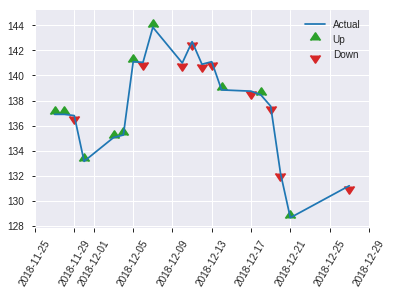


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3046943666593886
RMSE: 0.551991274079028
LogLoss: 4.020273355766134
Mean Per-Class Error: 0.33277725877485653
AUC: 0.6512077939410116
pr_auc: 0.39594232366245313
Gini: 0.30241558788202316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.558508715772114: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   67   0.5276   (67.0/127.0)
1      17   101  0.1441   (17.0/118.0)
Total  77   168  0.3429   (84.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.558509     0.706294  108
max f2                       0.387204     0.828652  150
max f0point5                 0.566079     0.643236  99
max accuracy                 0.566079     0.661224  99
max precision                1            0.610169  0
max recall                   0.387204     1         150
max specificity              1            0.818898  0
max absolute_mcc             0.558509     0.353436  108
max min_per_class_accuracy   0.615179     0.574803  62
max mean_per_class_accuracy  0.564094     0.667223  101

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 70.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.232653                    1                  1.2749    1.2749             0.614035         1         0.614035                    1                   0.29661         0.29661                    27.4903   27.4903
    2        0.302041                    0.835685           0.854935  1.17842            0.411765         0.959813  0.567568                    0.990768            0.059322        0.355932                   -14.5065  17.8424
    3        0.4                         0.660918           1.12465   1.16525            0.541667         0.727586  0.561224                    0.926315            0.110169        0.466102                   12.4647   16.5254
    4        0.502041                    0.613995           1.16271   1.16474            0.56             0.631092  0.560976                    0.866311            0.118644        0.584746                   16.2712   16.4737
    5        0.6                         0.58303            1.5572    1.22881            0.75             0.597184  0.591837                    0.822371            0.152542        0.737288                   55.7203   22.8814
    6        0.697959                    0.551593           1.29767   1.23848            0.625            0.568518  0.596491                    0.786743            0.127119        0.864407                   29.7669   23.8478
    7        0.906122                    0.52807            0.488534  1.06619            0.235294         0.533165  0.513514                    0.728489            0.101695        0.966102                   -51.1466  6.61933
    8        1                           0.243155           0.361091  1                  0.173913         0.442878  0.481633                    0.701676            0.0338983       1                          -63.8909  0

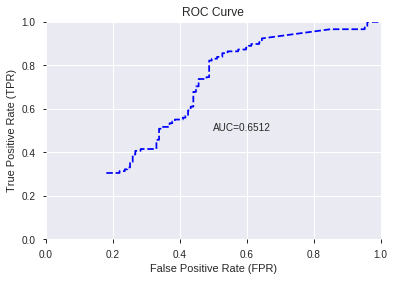

This function is available for GLM models only


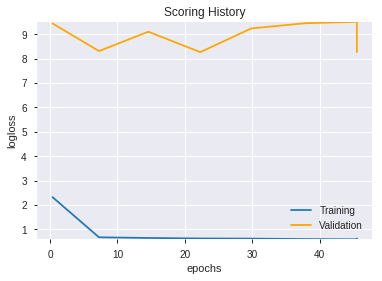

--2019-08-24 20:45:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  62.3MB/s    in 6.0s    

2019-08-24 20:45:08 (58.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_201817_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_201817_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_204516_model_9  0.712465  0.639609              0.311257  0.467876  0.218908
1  DeepLearning_grid_1_AutoML_20190824_204516_model_6  0.710063  0.701385              0.347925  0.479205  0.229637
2  DeepLearning_grid_1_AutoML_20190824_204516_model_5  0.708661  0.644059              0.353997  0.470077  0.220972
3  DeepLearning_grid_1_AutoML_20190824_204516_model_8  0.695516  0.686184              0.343387  0.479856  0.230262
4  DeepLearning_grid_1_AutoML_20190824_204516_model_4  0.652275  0.874552              0.392466  0.522632  0.273144
5  DeepLearning_grid_1_AutoML_20190824_204516_model_7  0.648605  0.951386              0.416088  0.518250  0.268583
6               DeepLearning_1_AutoML_20190824_204516  0.646470  0.762855              0.439410  0.509885  0.259983
7  DeepLearning_grid_1_AutoML_20190824_204516_model_3  0.638796  0.784652              0.396704  0.517302  0.267601
8  DeepLearning_grid_1_AutoML_20190824_204516_model_1  0.604764  0.994337              0.468504  0.556492  0.309683
9  DeepLearning_grid_1_AutoML_20190824_204516_model_2  0.580609  0.915452              0.446383  0.555828  0.308944

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.041700
1                  BOP             0.908106           0.908106    0.037868
2                  DIV             0.809605           0.809605    0.033761
3                  SUB             0.730834           0.730834    0.030476
4          CDLLONGLINE             0.699984           0.699984    0.029190
5         CDLSHORTLINE             0.677301           0.677301    0.028244
6            CORREL_12             0.671987           0.671987    0.028022
7            CDLTAKURI             0.631209           0.631209    0.026322
8          MINUS_DI_30             0.625460           0.625460    0.026082
9         CDLENGULFING             0.622994           0.622994    0.025979
10        is_month_end             0.611895           0.611895    0.025516
11        HT_TRENDMODE             0.602790           0.602790    0.025137
12    CDLDRAGONFLYDOJI             0.602298           0.602298    0.025116
13       CDLHANGINGMAN             0.585472           0.585472    0.024414
14           CORREL_30             0.581671           0.581671    0.024256
15                 day             0.549720           0.549720    0.022924
16      STOCHRSI_fastd             0.517650           0.517650    0.021586
17              ULTOSC             0.497541           0.497541    0.020748
18      STOCHRSI_fastk             0.479508           0.479508    0.019996
19              SAREXT             0.468419           0.468419    0.019533
20              TRANGE             0.463986           0.463986    0.019348
21         STOCH_slowd             0.462244           0.462244    0.019276
22         CDLBELTHOLD             0.458553           0.458553    0.019122
23        aroondown_12             0.433865           0.433865    0.018092
24              BETA_8             0.432039           0.432039    0.018016
25   HT_PHASOR_inphase             0.431935           0.431935    0.018012
26        STOCHF_fastk             0.431342           0.431342    0.017987
27           aroonup_8             0.426045           0.426045    0.017766
28                 SIN             0.409772           0.409772    0.017088
29             BETA_20             0.404355           0.404355    0.016862
30            WILLR_30             0.387041           0.387041    0.016140
31             BETA_24             0.375868           0.375868    0.015674
32             quarter             0.374024           0.374024    0.015597
33  LINEARREG_ANGLE_12             0.367094           0.367094    0.015308
34             BETA_30             0.363455           0.363455    0.015156
35            WILLR_24             0.358859           0.358859    0.014965
36            WILLR_14             0.354352           0.354352    0.014777
37          weekofyear             0.354267           0.354267    0.014773
38                week             0.345126           0.345126    0.014392
39             WILLR_8             0.343509           0.343509    0.014324
40          AROONOSC_8             0.342038           0.342038    0.014263
41  LINEARREG_SLOPE_12             0.339745           0.339745    0.014168
42               month             0.339356           0.339356    0.014151
43              CMO_12             0.323423           0.323423    0.013487
44           dayofyear             0.314967           0.314967    0.013134
45   LINEARREG_ANGLE_8             0.304817           0.304817    0.012711
46               RSI_8             0.295681           0.295681    0.012330
47            WILLR_12             0.295035           0.295035    0.012303
48            WILLR_20             0.287036           0.287036    0.011970
49               CMO_8             0.286285           0.286285    0.011938

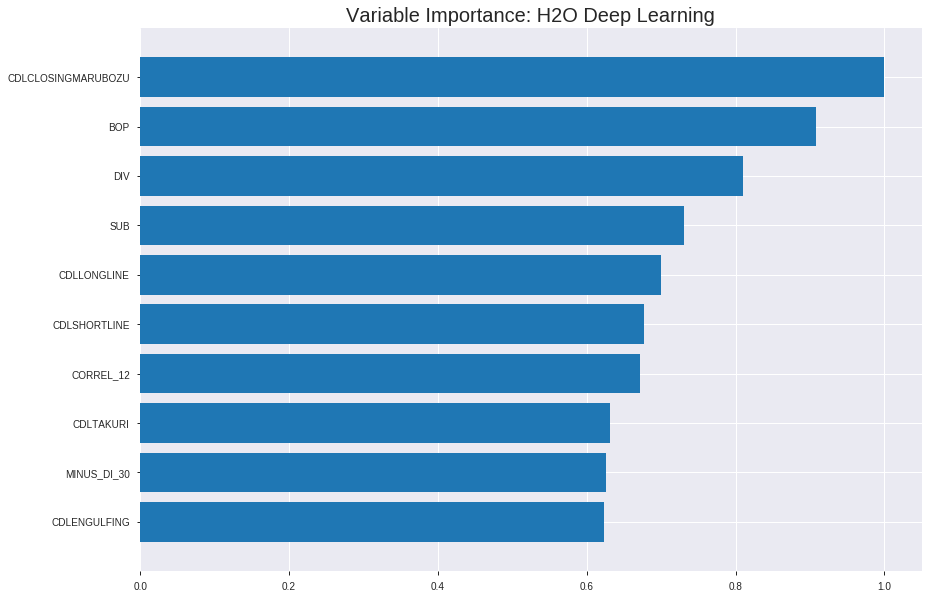

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_204516_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1776971889147651
RMSE: 0.4215414438875081
LogLoss: 0.5327698839156576
Mean Per-Class Error: 0.2620767773292694
AUC: 0.8135005629239092
pr_auc: 0.8146306607703754
Gini: 0.6270011258478183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.390387018593672: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      447  349   0.4384   (349.0/796.0)
1      109  806   0.1191   (109.0/915.0)
Total  556  1155  0.2677   (458.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390387     0.778744  254
max f2                       0.197423     0.877675  333
max f0point5                 0.556155     0.760529  174
max accuracy                 0.51685      0.739334  197
max precision                0.931316     1         0
max recall                   0.0908813    1         385
max specificity              0.931316     1         0
max absolute_mcc             0.51685      0.475667  197
max min_per_class_accuracy   0.532983     0.734426  187
max mean_per_class_accuracy  0.540108     0.737923  183

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.880106           1.76606   1.76606            0.944444         0.895073  0.944444                    0.895073            0.0185792       0.0185792                  76.606    76.606
    2        0.0204559                   0.868731           1.64995   1.70966            0.882353         0.874309  0.914286                    0.884987            0.0163934       0.0349727                  64.9952   70.9664
    3        0.0303916                   0.849901           1.64995   1.69014            0.882353         0.859401  0.903846                    0.876623            0.0163934       0.0513661                  64.9952   69.0143
    4        0.0403273                   0.841711           1.75995   1.70734            0.941176         0.845998  0.913043                    0.869077            0.0174863       0.0688525                  75.9949   70.7341
    5        0.050263                    0.825144           1.75995   1.71774            0.941176         0.833099  0.918605                    0.861965            0.0174863       0.0863388                  75.9949   71.7741
    6        0.100526                    0.793375           1.696     1.70687            0.906977         0.808761  0.912791                    0.835363            0.0852459       0.171585                   69.5997   70.6869
    7        0.150205                    0.764402           1.60595   1.67349            0.858824         0.779884  0.894942                    0.817014            0.0797814       0.251366                   60.5953   67.3492
    8        0.200468                    0.735452           1.58728   1.65188            0.848837         0.74827   0.883382                    0.799778            0.0797814       0.331148                   58.7279   65.1876
    9        0.300409                    0.663567           1.44347   1.58254            0.77193          0.701936  0.846304                    0.767227            0.144262        0.47541                    44.3467   58.2541
    10       0.400351                    0.597979           1.27944   1.50688            0.684211         0.63135   0.805839                    0.733308            0.127869        0.603279                   27.9436   50.6876
    11       0.500292                    0.541158           1.17008   1.4396             0.625731         0.568759  0.76986                     0.700436            0.11694         0.720219                   17.0083   43.9596
    12       0.600234                    0.474463           0.907634  1.35102            0.48538          0.509183  0.722493                    0.668592            0.0907104       0.810929                   -9.23657  35.1022
    13       0.700175                    0.362824           0.820151  1.27525            0.438596         0.417205  0.68197                     0.632709            0.0819672       0.892896                   -17.9849  27.5247
    14       0.800117                    0.235963           0.590509  1.18972            0.315789         0.301978  0.636231                    0.591398            0.0590164       0.951913                   -40.9491  18.9717
    15       0.900058                    0.151142           0.338996  1.09525            0.181287         0.187942  0.585714                    0.546599            0.0338798       0.985792                   -66.1004  9.52537
    16       1                           0.0470242          0.14216   1                  0.0760234        0.11092   0.534775                    0.503056          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19211273087325487
RMSE: 0.4383066630491201
LogLoss: 0.569119572166521
Mean Per-Class Error: 0.28391031480919127
AUC: 0.7781826770590816
pr_auc: 0.8029759931594634
Gini: 0.5563653541181632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3598444610611646: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  100  0.4505   (100.0/222.0)
1      35   232  0.1311   (35.0/267.0)
Total  157  332  0.2761   (135.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359844     0.774624  269
max f2                       0.216293     0.863946  329
max f0point5                 0.46549      0.739161  223
max accuracy                 0.394112     0.725971  258
max precision                0.889212     1         0
max recall                   0.047087     1         399
max specificity              0.889212     1         0
max absolute_mcc             0.394112     0.447417  258
max min_per_class_accuracy   0.51986      0.698198  200
max mean_per_class_accuracy  0.46549      0.71609   223

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 49.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.865369           1.83146   1.83146            1                0.879231  1                           0.879231            0.0187266       0.0187266                  83.1461   83.1461
    2        0.0204499                   0.846628           1.83146   1.83146            1                0.856297  1                           0.867764            0.0187266       0.0374532                  83.1461   83.1461
    3        0.0306748                   0.834875           1.83146   1.83146            1                0.841622  1                           0.85905             0.0187266       0.0561798                  83.1461   83.1461
    4        0.0408998                   0.822469           1.83146   1.83146            1                0.828736  1                           0.851472            0.0187266       0.0749064                  83.1461   83.1461
    5        0.0511247                   0.819224           1.46517   1.7582             0.8              0.821152  0.96                        0.845408            0.0149813       0.0898876                  46.5169   75.8202
    6        0.100204                    0.775631           1.67884   1.71933            0.916667         0.796496  0.938776                    0.821451            0.082397        0.172285                   67.8839   71.933
    7        0.151329                    0.741139           1.61169   1.68296            0.88             0.758182  0.918919                    0.800077            0.082397        0.254682                   61.1685   68.2964
    8        0.200409                    0.704225           1.52622   1.64458            0.833333         0.723649  0.897959                    0.78136             0.0749064       0.329588                   52.6217   64.4577
    9        0.300613                    0.655426           1.19606   1.49507            0.653061         0.677782  0.816327                    0.746834            0.11985         0.449438                   19.6056   49.507
    10       0.400818                    0.597763           1.08393   1.39228            0.591837         0.626856  0.760204                    0.716839            0.108614        0.558052                   8.39257   39.2284
    11       0.501022                    0.529739           1.1213    1.33809            0.612245         0.561039  0.730612                    0.685679            0.11236         0.670412                   12.1302   33.8088
    12       0.599182                    0.446495           1.22097   1.3189             0.666667         0.49712   0.720137                    0.654789            0.11985         0.790262                   22.0974   31.8902
    13       0.699387                    0.343837           0.822288  1.24775            0.44898          0.39642   0.681287                    0.617771            0.082397        0.872659                   -17.7712  24.775
    14       0.799591                    0.234046           0.672781  1.17569            0.367347         0.29521   0.641944                    0.577348            0.0674157       0.940075                   -32.7219  17.5695
    15       0.899796                    0.148255           0.261637  1.0739             0.142857         0.184776  0.586364                    0.53363             0.0262172       0.966292                   -73.8363  7.39019
    16       1                           0.0469956          0.336391  1                  0.183673         0.113788  0.546012                    0.49156             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:52:53  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 20:52:55  2 min 45.765 sec  538 obs/sec       0.734074  1             1256       0.565424         0.942486            -0.285032      0.694365        0.711527           1.55829          0.38457                          0.554314           0.906243              -0.239553        0.692774          0.712226             1.83146            0.372188
    2019-08-24 20:53:07  2 min 57.798 sec  870 obs/sec       6.7107    9             11482      0.464099         0.619027            0.134259       0.737297        0.743504           1.4544           0.329047                         0.460087           0.610313              0.146048         0.754876          0.783864             1.83146            0.300613
    2019-08-24 20:53:20  3 min 10.376 sec  1035 obs/sec      14.893    20            25482      0.462918         0.617688            0.13866        0.761889        0.772097           1.86995          0.31502                          0.464765           0.62184               0.128596         0.770835          0.798242             1.83146            0.314928
    2019-08-24 20:53:32  3 min 22.318 sec  1154 obs/sec      23.8422   32            40794      0.446784         0.585474            0.197656       0.764285        0.767697           1.86995          0.319112                         0.44705            0.587013              0.193757         0.771873          0.778781             1.46517            0.274029
    2019-08-24 20:53:45  3 min 35.016 sec  1250 obs/sec      34.27     46            58636      0.444605         0.580795            0.205463       0.776601        0.781264           1.66217          0.293396                         0.449659           0.59236               0.184319         0.771266          0.792536             1.83146            0.282209
    2019-08-24 20:53:57  3 min 47.091 sec  1324 obs/sec      44.723    60            76521      0.441645         0.575352            0.216006       0.778041        0.779241           1.55829          0.308007                         0.443862           0.579492              0.205214         0.774353          0.798151             1.83146            0.276074
    2019-08-24 20:54:09  3 min 58.975 sec  1380 obs/sec      55.239    74            94514      0.43372          0.557797            0.24389        0.787826        0.789303           1.55829          0.308007                         0.442152           0.577265              0.211327         0.772286          0.792779             1.83146            0.296524
    2019-08-24 20:54:21  4 min 11.298 sec  1429 obs/sec      66.5289   89            113831     0.433659         0.558321            0.244102       0.797759        0.800635           1.55829          0.282291                         0.44305            0.581541              0.208121         0.775652          0.802195             1.83146            0.274029
    2019-08-24 20:54:33

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.04170043992403499
BOP                 0.9081060290336609     0.9081060290336609   0.03786842090837215
DIV                 0.8096054792404175     0.8096054792404175   0.033760904649234584
SUB                 0.7308335900306702     0.7308335900306702   0.030476082215540778
CDLLONGLINE         0.6999837160110474     0.6999837160110474   0.029189628897321452
---                 ---                    ---                  ---
LINEARREG_ANGLE_8   0.30481740832328796    0.30481740832328796  0.012711020023585312
RSI_8               0.29568129777908325    0.29568129777908325  0.012330040194697361
WILLR_12            0.29503539204597473    0.29503539204597473  0.012303105641477281
WILLR_20            0.28703609108924866    0.28703609108924866  0.01196953127249705
CMO_8               0.28628528118133545    0.28628528118133545  0.011938222169037744


See the whole table with table.as_data_frame()


('accuracy', 0.6979591836734694)

('F1', 0.7027027027027027)

('auc', 0.712464967302816)

('logloss', 0.6396091813038268)

('mean_per_class_error', 0.30395035366341916)

('rmse', 0.4678762694129241)

('mse', 0.21890820347975512)

deeplearning prediction progress: |███████████████████████████████████████| 100%


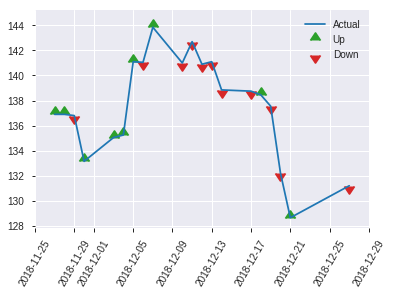


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21890820347975512
RMSE: 0.4678762694129241
LogLoss: 0.6396091813038268
Mean Per-Class Error: 0.30395035366341916
AUC: 0.712464967302816
pr_auc: 0.6682064840754194
Gini: 0.4249299346056321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433649683199997: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   50   0.3937   (50.0/127.0)
1      27   91   0.2288   (27.0/118.0)
Total  104  141  0.3143   (77.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43365      0.702703  140
max f2                       0.0971982    0.82744   234
max f0point5                 0.589673     0.691882  105
max accuracy                 0.589673     0.697959  105
max precision                0.895875     1         0
max recall                   0.0785324    1         241
max specificity              0.895875     1         0
max absolute_mcc             0.589673     0.394832  105
max min_per_class_accuracy   0.53045      0.686441  119
max mean_per_class_accuracy  0.581008     0.69605   107

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 47.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.871384           2.07627   2.07627            1                0.886982   1                           0.886982            0.0254237       0.0254237                  107.627   107.627
    2        0.0204082                   0.861542           1.03814   1.66102            0.5              0.868775   0.8                         0.879699            0.00847458      0.0338983                  3.81356   66.1017
    3        0.0326531                   0.841613           1.38418   1.5572             0.666667         0.850734   0.75                        0.868837            0.0169492       0.0508475                  38.4181   55.7203
    4        0.0408163                   0.837084           2.07627   1.66102            1                0.837933   0.8                         0.862656            0.0169492       0.0677966                  107.627   66.1017
    5        0.0530612                   0.83277            0.69209   1.43742            0.333333         0.835702   0.692308                    0.856436            0.00847458      0.0762712                  -30.791   43.7419
    6        0.102041                    0.777316           1.5572    1.49492            0.75             0.798174   0.72                        0.82847             0.0762712       0.152542                   55.7203   49.4915
    7        0.15102                     0.759255           1.5572    1.51512            0.75             0.76956    0.72973                     0.809364            0.0762712       0.228814                   55.7203   51.5117
    8        0.2                         0.734727           1.73023   1.5678             0.833333         0.745973   0.755102                    0.79384             0.0847458       0.313559                   73.0226   56.7797
    9        0.302041                    0.681854           1.07966   1.40289            0.52             0.704719   0.675676                    0.763732            0.110169        0.423729                   7.9661    40.2886
    10       0.4                         0.624335           1.5572    1.44068            0.75             0.655908   0.693878                    0.737326            0.152542        0.576271                   55.7203   44.0678
    11       0.502041                    0.513689           1.24576   1.40106            0.6              0.572771   0.674797                    0.70388             0.127119        0.70339                    24.5763   40.1061
    12       0.6                         0.406764           0.69209   1.28531            0.333333         0.466106   0.619048                    0.665059            0.0677966       0.771186                   -30.791   28.5311
    13       0.697959                    0.250819           0.778602  1.21419            0.375            0.323666   0.584795                    0.617144            0.0762712       0.847458                   -22.1398  21.4194
    14       0.8                         0.163973           0.332203  1.10169            0.16             0.204462   0.530612                    0.564506            0.0338983       0.881356                   -66.7797  10.1695
    15       0.897959                    0.120782           0.519068  1.03814            0.25             0.145045   0.5                         0.518747            0.0508475       0.932203                   -48.0932  3.81356
    16       1                           0.0225181          0.664407  1                  0.32             0.0941997  0.481633                   

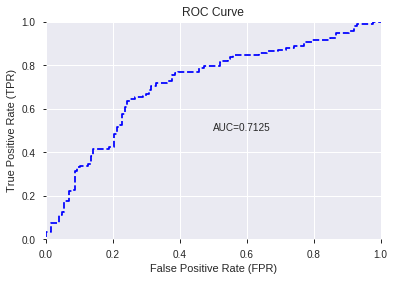

This function is available for GLM models only


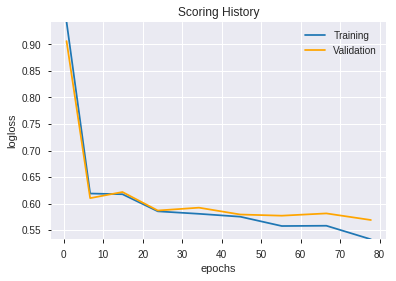

--2019-08-24 20:54:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_204516_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_204516_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CORREL_12',
 'CDLTAKURI',
 'MINUS_DI_30',
 'CDLENGULFING',
 'is_month_end',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CORREL_30',
 'day',
 'STOCHRSI_fastd',
 'ULTOSC',
 'STOCHRSI_fastk',
 'SAREXT',
 'TRANGE',
 'STOCH_slowd',
 'CDLBELTHOLD',
 'aroondown_12',
 'BETA_8',
 'HT_PHASOR_inphase',
 'STOCHF_fastk',
 'aroonup_8',
 'SIN',
 'BETA_20',
 'WILLR_30',
 'BETA_24',
 'quarter',
 'LINEARREG_ANGLE_12',
 'BETA_30',
 'WILLR_24',
 'WILLR_14',
 'weekofyear',
 'week',
 'WILLR_8',
 'AROONOSC_8',
 'LINEARREG_SLOPE_12',
 'month',
 'CMO_12',
 'dayofyear',
 'LINEARREG_ANGLE_8',
 'RSI_8',
 'WILLR_12',
 'WILLR_20',
 'CMO_8']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_205446_model_1  0.738089  0.607543              0.331576  0.456448  0.208345

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.816082           1.000000    0.128309
1         STOCHF_fastk             0.320899           0.393219    0.050454
2             WILLR_24             0.305569           0.374434    0.048043
3          STOCH_slowd             0.301387           0.369310    0.047386
4                  SUB             0.279409           0.342378    0.043930
5            CDLTAKURI             0.261068           0.319905    0.041047
6          CDLBELTHOLD             0.253564           0.310709    0.039867
7       STOCHRSI_fastd             0.227643           0.278947    0.035791
8             WILLR_20             0.223365           0.273704    0.035119
9               CMO_12             0.215347           0.263879    0.033858
10             quarter             0.214331           0.262634    0.033698
11            WILLR_14             0.173257           0.212304    0.027241
12        is_month_end             0.164643           0.201748    0.025886
13    CDLDRAGONFLYDOJI             0.158262           0.193929    0.024883
14           dayofyear             0.148708           0.182222    0.023381
15        aroondown_12             0.138624           0.169865    0.021795
16              ULTOSC             0.134471           0.164777    0.021142
17         MINUS_DI_30             0.129102           0.158197    0.020298
18   HT_PHASOR_inphase             0.119664           0.146632    0.018814
19           CORREL_12             0.117483           0.143960    0.018471
20          AROONOSC_8             0.113593           0.139193    0.017860
21              SAREXT             0.113209           0.138723    0.017799
22              BETA_8             0.112754           0.138165    0.017728
23  LINEARREG_ANGLE_12             0.108807           0.133328    0.017107
24        CDLSHORTLINE             0.097072           0.118949    0.015262
25           aroonup_8             0.093866           0.115021    0.014758
26      STOCHRSI_fastk             0.093725           0.114848    0.014736
27  LINEARREG_SLOPE_12             0.085499           0.104767    0.013443
28             BETA_24             0.080406           0.098527    0.012642
29   LINEARREG_ANGLE_8             0.074311           0.091058    0.011684
30          weekofyear             0.068471           0.083903    0.010765
31                week             0.065123           0.079799    0.010239
32                 day             0.064004           0.078429    0.010063
33            WILLR_30             0.060366           0.073971    0.009491
34             WILLR_8             0.060127           0.073678    0.009454
35           CORREL_30             0.053712           0.065816    0.008445
36        CDLENGULFING             0.052177           0.063936    0.008204
37               month             0.046593           0.057093    0.007326
38        HT_TRENDMODE             0.046341           0.056784    0.007286
39              TRANGE             0.041841           0.051271    0.006578
40               CMO_8             0.027328           0.033487    0.004297
41                 SIN             0.025421           0.031150    0.003997
42       CDLHANGINGMAN             0.022674           0.027784    0.003565
43                 DIV             0.017922           0.021961    0.002818
44               RSI_8             0.009438           0.011565    0.001484
45            WILLR_12             0.009144           0.011205    0.001438
46             BETA_30             0.004389           0.005378    0.000690
47  CDLCLOSINGMARUBOZU             0.003744           0.004588    0.000589
48             BETA_20             0.003223           0.003949    0.000507
49         CDLLONGLINE             0.002120           0.002598    0.000333

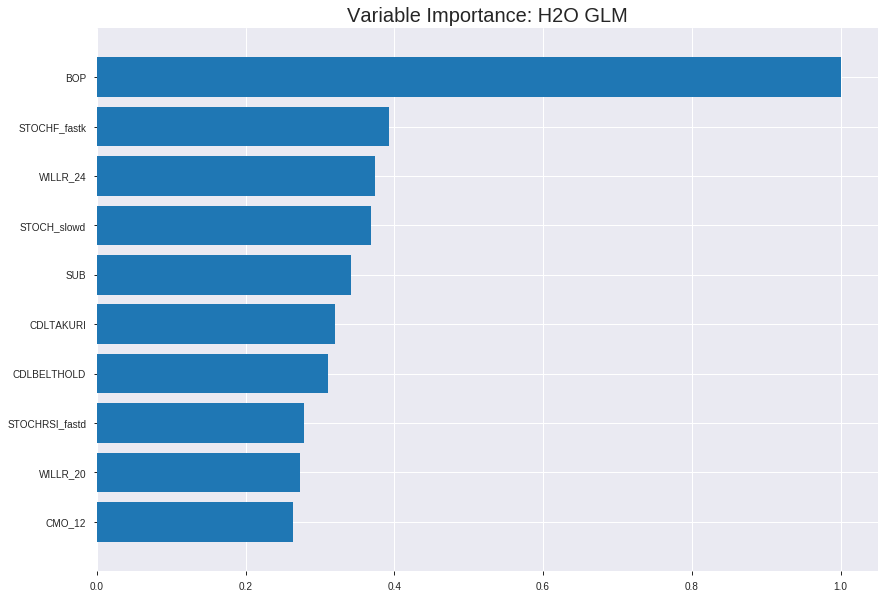

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_205446_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19976178851330545
RMSE: 0.4469471876109139
LogLoss: 0.5853333721841121
Null degrees of freedom: 1710
Residual degrees of freedom: 1660
Null deviance: 2363.666519940619
Residual deviance: 2003.0107996140314
AIC: 2105.0107996140314
AUC: 0.7548239833045006
pr_auc: 0.7509903611506762
Gini: 0.5096479666090012
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31680895469275683: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      283  513   0.6445   (513.0/796.0)
1      66   849   0.0721   (66.0/915.0)
Total  349  1362  0.3384   (579.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316809     0.745718  292
max f2                       0.20573      0.859271  347
max f0point5                 0.561011     0.718598  177
max accuracy                 0.502        0.702513  207
max precision                0.953994     1         0
max recall                   0.0987071    1         387
max specificity              0.953994     1         0
max absolute_mcc             0.46354      0.400709  224
max min_per_class_accuracy   0.546484     0.694724  184
max mean_per_class_accuracy  0.502        0.698249  207

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.898541           1.66217   1.66217            0.888889         0.914831  0.888889                    0.914831            0.0174863       0.0174863                  66.2174   66.2174
    2        0.0204559                   0.883191           1.53995   1.60281            0.823529         0.890932  0.857143                    0.903223            0.0153005       0.0327869                  53.9955   60.281
    3        0.0303916                   0.8688             1.53995   1.58226            0.823529         0.875904  0.846154                    0.894292            0.0153005       0.0480874                  53.9955   58.2261
    4        0.0403273                   0.859808           1.75995   1.62604            0.941176         0.864154  0.869565                    0.886867            0.0174863       0.0655738                  75.9949   62.6039
    5        0.050263                    0.850836           1.20996   1.54379            0.647059         0.854858  0.825581                    0.880539            0.0120219       0.0775956                  20.9965   54.3792
    6        0.100526                    0.812081           1.5003    1.52205            0.802326         0.830468  0.813953                    0.855504            0.0754098       0.153005                   50.0305   52.2049
    7        0.150205                    0.774207           1.56195   1.53525            0.835294         0.792241  0.821012                    0.83458             0.0775956       0.230601                   56.1954   53.5247
    8        0.200468                    0.749972           1.52205   1.53194            0.813953         0.761007  0.819242                    0.816133            0.0765027       0.307104                   52.2049   53.1938
    9        0.300409                    0.688215           1.32318   1.46249            0.707602         0.720118  0.782101                    0.78419             0.13224         0.439344                   32.3178   46.2486
    10       0.400351                    0.628289           1.22476   1.40314            0.654971         0.660129  0.750365                    0.75322             0.122404        0.561749                   22.476    40.3141
    11       0.500292                    0.55682            1.18102   1.35877            0.631579         0.59073   0.726636                    0.72076             0.118033        0.679781                   18.1018   35.8769
    12       0.600234                    0.478517           1.00605   1.30004            0.538012         0.518107  0.695229                    0.687018            0.100546        0.780328                   0.605247  30.004
    13       0.700175                    0.392862           0.787345  1.22686            0.421053         0.437182  0.656093                    0.651356            0.0786885       0.859016                   -21.2655  22.6859
    14       0.800117                    0.313659           0.688927  1.15967            0.368421         0.353573  0.620161                    0.614161            0.0688525       0.927869                   -31.1073  15.9667
    15       0.900058                    0.225894           0.448349  1.08068            0.239766         0.270579  0.577922                    0.57601             0.0448087       0.972678                   -55.1651  8.06827
    16       1                           0.031099           0.273384  1                  0.146199         0.163421  0.534775                    0.534775           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19479472303332734
RMSE: 0.44135555171916363
LogLoss: 0.5741673682912843
Null degrees of freedom: 488
Residual degrees of freedom: 438
Null deviance: 673.9994524945296
Residual deviance: 561.5356861888761
AIC: 663.5356861888761
AUC: 0.7709535378074703
pr_auc: 0.7775404068215357
Gini: 0.5419070756149407
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34159540788941783: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  120  0.5405   (120.0/222.0)
1      25   242  0.0936   (25.0/267.0)
Total  127  362  0.2965   (145.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341595     0.769475  285
max f2                       0.23394      0.871898  337
max f0point5                 0.458889     0.744905  226
max accuracy                 0.458889     0.730061  226
max precision                0.928666     1         0
max recall                   0.0795082    1         391
max specificity              0.928666     1         0
max absolute_mcc             0.458889     0.452826  226
max min_per_class_accuracy   0.526734     0.698198  198
max mean_per_class_accuracy  0.458889     0.72358   226

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.900438           1.46517   1.46517            0.8              0.909116  0.8                         0.909116            0.0149813       0.0149813                  46.5169   46.5169
    2        0.0204499                   0.857639           1.83146   1.64831            1                0.887744  0.9                         0.89843             0.0187266       0.0337079                  83.1461   64.8315
    3        0.0306748                   0.835881           1.83146   1.70936            1                0.843346  0.933333                    0.880069            0.0187266       0.0524345                  83.1461   70.9363
    4        0.0408998                   0.820505           1.46517   1.64831            0.8              0.828905  0.9                         0.867278            0.0149813       0.0674157                  46.5169   64.8315
    5        0.0511247                   0.811363           1.83146   1.68494            1                0.814999  0.92                        0.856822            0.0187266       0.0861423                  83.1461   68.4944
    6        0.100204                    0.782067           1.60253   1.64458            0.875            0.796     0.897959                    0.827032            0.0786517       0.164794                   60.2528   64.4577
    7        0.151329                    0.745833           1.39191   1.55922            0.76             0.759846  0.851351                    0.804334            0.071161        0.235955                   39.191    55.9217
    8        0.200409                    0.716652           1.3736    1.51376            0.75             0.729325  0.826531                    0.785964            0.0674157       0.303371                   37.3596   51.3758
    9        0.300613                    0.65554            1.30819   1.44523            0.714286         0.688086  0.789116                    0.753338            0.131086        0.434457                   30.8186   44.5234
    10       0.400818                    0.604058           1.27081   1.40163            0.693878         0.628518  0.765306                    0.722133            0.127341        0.561798                   27.0809   40.1628
    11       0.501022                    0.535262           1.23343   1.36799            0.673469         0.5685    0.746939                    0.691407            0.123596        0.685393                   23.3433   36.7989
    12       0.599182                    0.455639           1.14466   1.3314             0.625            0.493069  0.726962                    0.658914            0.11236         0.797753                   14.4663   33.1403
    13       0.699387                    0.382061           0.635405  1.23168            0.346939         0.416214  0.672515                    0.624142            0.0636704       0.861423                   -36.4595  23.1684
    14       0.799591                    0.28829            0.747535  1.17101            0.408163         0.334329  0.639386                    0.587822            0.0749064       0.93633                    -25.2465  17.1011
    15       0.899796                    0.207659           0.411144  1.08639            0.22449          0.248575  0.593182                    0.550043            0.0411985       0.977528                   -58.8856  8.63892
    16       1                           0.0188699          0.22426   1                  0.122449         0.144738  0.546012                    0.509429         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 20:54:46  0.000 sec   2            .18E2     51            1.3659134105169461  1.3620552342925514
     2019-08-24 20:54:47  0.067 sec   4            .11E2     51            1.3580460981788653  1.3537405436568186
     2019-08-24 20:54:47  0.134 sec   6            .71E1     51            1.347127542892087   1.3421100966778028
     2019-08-24 20:54:47  0.193 sec   8            .44E1     51            1.3328057598927014  1.3267085969590058
     2019-08-24 20:54:47  0.257 sec   10           .27E1     51            1.3151484720182351  1.3074778719555733
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 20:54:47  0.662 sec   41           .13E-2    51            1.1702798190399397  1.1483431124117935
     2019-08-24 20:54:47  0.676 sec   42           .83E-3    51            1.1700345873442006  1.148434043137263
     2019-08-24 20:54:47  0.689 sec   43           .52E-3    51            1.169868316701026   1.1485242500183004
     2019-08-24 20:54:47  0.705 sec   44           .32E-3    51            1.1697438521476824  1.1486772447396467
     2019-08-24 20:54:47  0.723 sec   45           .2E-3     51            1.1696295111350108  1.1488441714563788


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6979591836734694)

('F1', 0.710801393728223)

('auc', 0.7380888829574269)

('logloss', 0.6075433630850988)

('mean_per_class_error', 0.3015481115707994)

('rmse', 0.456447788033142)

('mse', 0.20834458320034813)

glm prediction progress: |████████████████████████████████████████████████| 100%


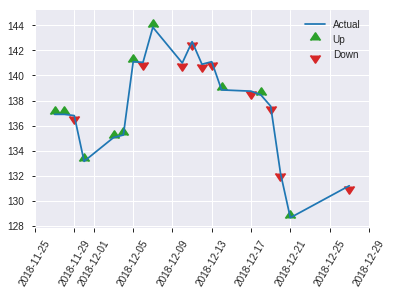


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20834458320034813
RMSE: 0.456447788033142
LogLoss: 0.6075433630850988
Null degrees of freedom: 244
Residual degrees of freedom: 194
Null deviance: 342.0840315976776
Residual deviance: 297.69624791169844
AIC: 399.69624791169844
AUC: 0.7380888829574269
pr_auc: 0.6859317578946612
Gini: 0.47617776591485383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38416589639292326: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   67   0.5276   (67.0/127.0)
1      16   102  0.1356   (16.0/118.0)
Total  76   169  0.3388   (83.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384166     0.710801  168
max f2                       0.118682     0.830966  231
max f0point5                 0.580915     0.702128  87
max accuracy                 0.580915     0.697959  87
max precision                0.802429     0.909091  10
max recall                   0.0668287    1         239
max specificity              0.906987     0.992126  0
max absolute_mcc             0.580915     0.40211   87
max min_per_class_accuracy   0.491215     0.692913  120
max mean_per_class_accuracy  0.480419     0.698452  123

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 47.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0122449                   0.861951           1.38418   1.38418            0.666667         0.891203  0.666667                    0.891203            0.0169492       0.0169492                  38.4181    38.4181
    2        0.0204082                   0.852635           2.07627   1.66102            1                0.856979  0.8                         0.877513            0.0169492       0.0338983                  107.627    66.1017
    3        0.0326531                   0.83462            2.07627   1.81674            1                0.848124  0.875                       0.866492            0.0254237       0.059322                   107.627    81.6737
    4        0.0408163                   0.802948           2.07627   1.86864            1                0.809416  0.9                         0.855077            0.0169492       0.0762712                  107.627    86.8644
    5        0.0530612                   0.790908           1.38418   1.75684            0.666667         0.79692   0.846154                    0.841656            0.0169492       0.0932203                  38.4181    75.6845
    6        0.102041                    0.756107           1.21116   1.49492            0.583333         0.769553  0.72                        0.807047            0.059322        0.152542                   21.1158    49.4915
    7        0.15102                     0.716372           1.73023   1.57123            0.833333         0.73892   0.756757                    0.784952            0.0847458       0.237288                   73.0226    57.1232
    8        0.2                         0.681606           1.21116   1.48305            0.583333         0.699893  0.714286                    0.764121            0.059322        0.29661                    21.1158    48.3051
    9        0.302041                    0.616922           1.57797   1.51512            0.76             0.650711  0.72973                     0.725807            0.161017        0.457627                   57.7966    51.5117
    10       0.4                         0.558385           1.47069   1.50424            0.708333         0.58702   0.72449                     0.691818            0.144068        0.601695                   47.0692    50.4237
    11       0.502041                    0.484474           0.99661   1.40106            0.48             0.516635  0.674797                    0.656212            0.101695        0.70339                    -0.338983  40.1061
    12       0.6                         0.427101           0.69209   1.28531            0.333333         0.451803  0.619048                    0.622839            0.0677966       0.771186                   -30.791    28.5311
    13       0.697959                    0.378088           0.951624  1.23848            0.458333         0.401864  0.596491                    0.591825            0.0932203       0.864407                   -4.83757   23.8478
    14       0.8                         0.279608           0.498305  1.14407            0.24             0.326713  0.55102                     0.55801             0.0508475       0.915254                   -50.1695   14.4068
    15       0.897959                    0.180451           0.519068  1.07589            0.25             0.220497  0.518182                    0.52119             0.0508475       0.966102                   -48.0932   7.5886
    16       1                           0.0280129          0.332203  1                  0.16             0.108324  0.481633                    0

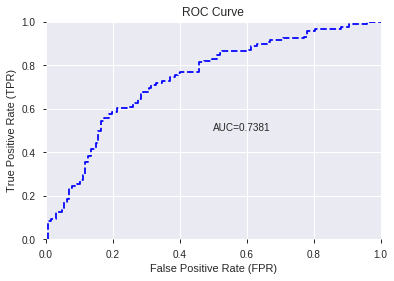

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


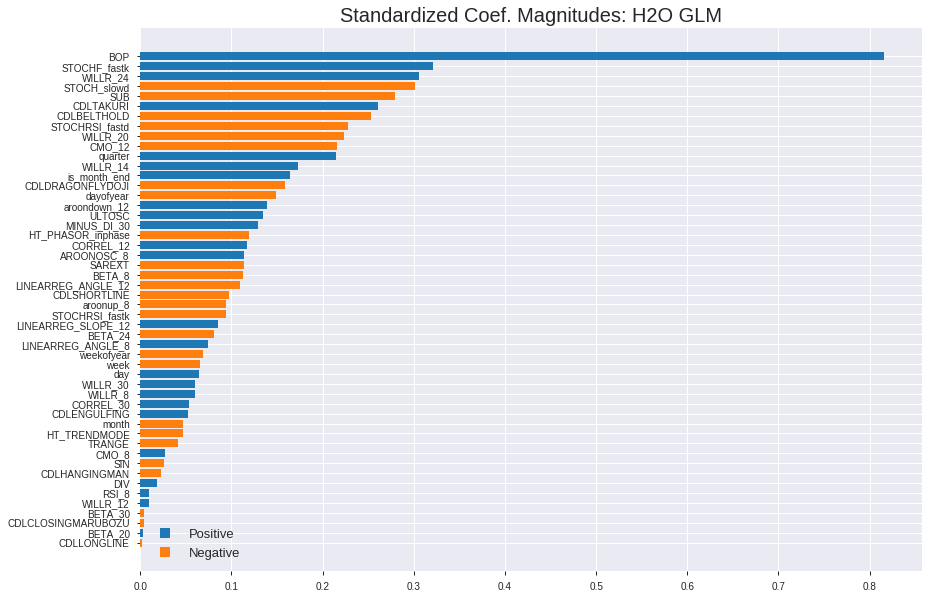

'log_likelihood'
--2019-08-24 20:54:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.115.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.115.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_205446_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_205446_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'WILLR_24',
 'STOCH_slowd',
 'SUB',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'STOCHRSI_fastd',
 'WILLR_20',
 'CMO_12',
 'quarter',
 'WILLR_14',
 'is_month_end',
 'CDLDRAGONFLYDOJI',
 'dayofyear',
 'aroondown_12',
 'ULTOSC',
 'MINUS_DI_30',
 'HT_PHASOR_inphase',
 'CORREL_12',
 'AROONOSC_8',
 'SAREXT',
 'BETA_8',
 'LINEARREG_ANGLE_12',
 'CDLSHORTLINE',
 'aroonup_8',
 'STOCHRSI_fastk',
 'LINEARREG_SLOPE_12',
 'BETA_24',
 'LINEARREG_ANGLE_8',
 'weekofyear',
 'week',
 'day',
 'WILLR_30',
 'WILLR_8',
 'CORREL_30',
 'CDLENGULFING',
 'month',
 'HT_TRENDMODE',
 'TRANGE',
 'CMO_8',
 'SIN',
 'CDLHANGINGMAN',
 'DIV',
 'RSI_8',
 'WILLR_12',
 'BETA_30',
 'CDLCLOSINGMARUBOZU',
 'BETA_20',
 'CDLLONGLINE']

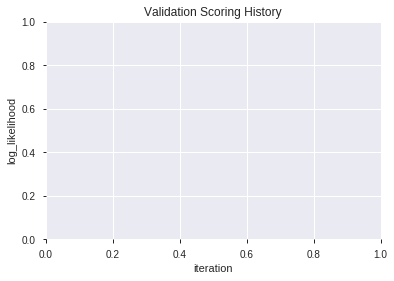

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_205458_model_4  0.706259  0.636635              0.344889  0.469950  0.220853
1  XGBoost_grid_1_AutoML_20190824_205458_model_3  0.702856  0.641642              0.373982  0.472208  0.222980
2  XGBoost_grid_1_AutoML_20190824_205458_model_6  0.699520  0.652279              0.342753  0.477089  0.227614
3               XGBoost_1_AutoML_20190824_205458  0.698919  0.653067              0.346090  0.476793  0.227331
4  XGBoost_grid_1_AutoML_20190824_205458_model_2  0.697785  0.644569              0.303984  0.474220  0.224884
5  XGBoost_grid_1_AutoML_20190824_205458_model_5  0.694315  0.672655              0.366409  0.481781  0.232113
6  XGBoost_grid_1_AutoML_20190824_205458_model_7  0.693514  0.655328              0.344588  0.477589  0.228091
7  XGBoost_grid_1_AutoML_20190824_205458_model_1  0.690845  0.649612              0.364574  0.476588  0.227136
8               XGBoost_2_AutoML_20190824_205458  0.689977  0.657219              0.404878  0.477946  0.228433
9               XGBoost_3_AutoML_20190824_205458  0.689243  0.656676              0.316996  0.478141  0.228619

variable  relative_importance  scaled_importance  percentage
0                  BOP          1823.540771           1.000000    0.354579
1         STOCHF_fastk           283.262146           0.155336    0.055079
2                  DIV           239.048096           0.131090    0.046482
3                  SUB           222.084686           0.121788    0.043183
4            CORREL_12           162.504959           0.089115    0.031598
5          STOCH_slowd           146.949188           0.080585    0.028574
6                  day           142.509857           0.078150    0.027710
7       STOCHRSI_fastd           137.689835           0.075507    0.026773
8          MINUS_DI_30           125.981834           0.069086    0.024497
9            dayofyear           123.654289           0.067810    0.024044
10                 SIN           122.732285           0.067304    0.023865
11              ULTOSC           117.839172           0.064621    0.022913
12              TRANGE           107.674957           0.059047    0.020937
13   HT_PHASOR_inphase           106.122284           0.058196    0.020635
14           CORREL_30           105.608734           0.057914    0.020535
15             BETA_24           102.401741           0.056155    0.019912
16             BETA_20            97.179146           0.053291    0.018896
17              SAREXT            95.731155           0.052497    0.018614
18             BETA_30            85.702339           0.046998    0.016664
19  LINEARREG_ANGLE_12            80.997574           0.044418    0.015750
20                week            80.557999           0.044177    0.015664
21      STOCHRSI_fastk            74.252480           0.040719    0.014438
22            WILLR_30            71.232437           0.039063    0.013851
23              BETA_8            68.577789           0.037607    0.013335
24            WILLR_12            58.795025           0.032242    0.011432
25        aroondown_12            51.215679           0.028086    0.009959
26           aroonup_8            46.018661           0.025236    0.008948
27               CMO_8            44.132370           0.024201    0.008581
28            WILLR_24            41.901802           0.022978    0.008148
29   LINEARREG_ANGLE_8            38.540947           0.021135    0.007494
30             WILLR_8            36.933998           0.020254    0.007182
31         CDLBELTHOLD            35.468781           0.019451    0.006897
32            WILLR_14            34.222248           0.018767    0.006654
33            WILLR_20            13.817746           0.007577    0.002687
34  CDLCLOSINGMARUBOZU             9.631767           0.005282    0.001873
35              CMO_12             8.320246           0.004563    0.001618

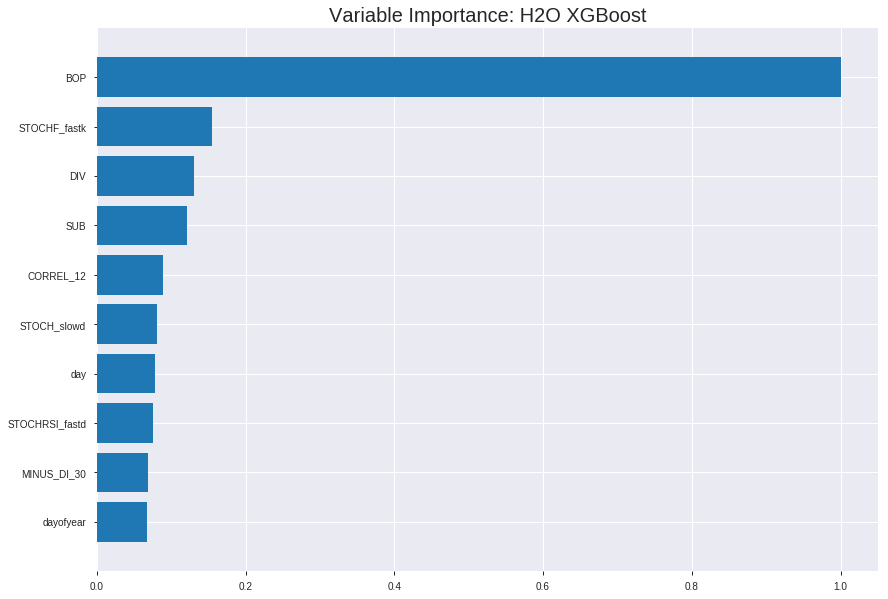

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_205458_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1758113510472882
RMSE: 0.41929864183811544
LogLoss: 0.5304667184774415
Mean Per-Class Error: 0.25026910508828293
AUC: 0.8251084658263997
pr_auc: 0.8368537035480716
Gini: 0.6502169316527995
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42962856590747833: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      445  351   0.441    (351.0/796.0)
1      104  811   0.1137   (104.0/915.0)
Total  549  1162  0.2659   (455.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429629     0.780934  247
max f2                       0.280985     0.877279  317
max f0point5                 0.613882     0.772591  145
max accuracy                 0.520118     0.751607  201
max precision                0.890927     1         0
max recall                   0.135542     1         389
max specificity              0.890927     1         0
max absolute_mcc             0.520118     0.4996    201
max min_per_class_accuracy   0.556794     0.743719  182
max mean_per_class_accuracy  0.542942     0.749731  189

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.866344           1.86995    1.86995            1                0.87567   1                           0.87567             0.0196721       0.0196721                  86.9945   86.9945
    2        0.0204559                   0.854833           1.86995    1.86995            1                0.860233  1                           0.868172            0.0185792       0.0382514                  86.9945   86.9945
    3        0.0303916                   0.843071           1.64995    1.79802            0.882353         0.848536  0.961538                    0.861753            0.0163934       0.0546448                  64.9952   79.8024
    4        0.0403273                   0.832775           1.75995    1.78864            0.941176         0.837562  0.956522                    0.855793            0.0174863       0.0721311                  75.9949   78.8643
    5        0.050263                    0.824614           1.86995    1.80471            1                0.828584  0.965116                    0.850414            0.0185792       0.0907104                  86.9945   80.4715
    6        0.100526                    0.792141           1.76123    1.78297            0.94186          0.80694   0.953488                    0.828677            0.0885246       0.179235                   76.1228   78.2971
    7        0.150205                    0.764333           1.69395    1.75353            0.905882         0.778159  0.937743                    0.811969            0.084153        0.263388                   69.395    75.3529
    8        0.200468                    0.735588           1.5003     1.69004            0.802326         0.750195  0.90379                     0.79648             0.0754098       0.338798                   50.0305   69.0038
    9        0.300409                    0.669715           1.36692    1.58254            0.730994         0.702845  0.846304                    0.765329            0.136612        0.47541                    36.6919   58.2541
    10       0.400351                    0.614257           1.41066    1.53963            0.754386         0.642878  0.823358                    0.734761            0.140984        0.616393                   41.0661   53.9634
    11       0.500292                    0.562192           1.10447    1.4527             0.590643         0.587574  0.776869                    0.705358            0.110383        0.726776                   10.4471   45.2703
    12       0.600234                    0.496978           0.984182   1.37469            0.526316         0.531022  0.735151                    0.676331            0.0983607       0.825137                   -1.58182  37.4692
    13       0.700175                    0.414212           0.677992   1.27525            0.362573         0.45444   0.68197                     0.644658            0.0677596       0.892896                   -32.2008  27.5247
    14       0.800117                    0.319009           0.667057   1.19928            0.356725         0.370774  0.641344                    0.610448            0.0666667       0.959563                   -33.2943  19.9278
    15       0.900058                    0.224071           0.317125   1.10132            0.169591         0.271406  0.588961                    0.572801            0.031694        0.991257                   -68.2875  10.1325
    16       1                           0.0927584          0.0874828  1                  0.0467836        0.175947  0.534775                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19252685296740385
RMSE: 0.43877882009892394
LogLoss: 0.5699331506009485
Mean Per-Class Error: 0.279000911023383
AUC: 0.7755339609272193
pr_auc: 0.7870026945799375
Gini: 0.5510679218544385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46087390184402466: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      127  95   0.4279   (95.0/222.0)
1      38   229  0.1423   (38.0/267.0)
Total  165  324  0.272    (133.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460874     0.774958  252
max f2                       0.314247     0.874409  331
max f0point5                 0.537815     0.746102  206
max accuracy                 0.460874     0.728016  252
max precision                0.87285      1         0
max recall                   0.125233     1         398
max specificity              0.87285      1         0
max absolute_mcc             0.460874     0.452516  252
max min_per_class_accuracy   0.56102      0.707865  193
max mean_per_class_accuracy  0.537815     0.720999  206

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 53.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.845267           1.83146   1.83146            1                0.856051  1                           0.856051            0.0187266       0.0187266                  83.1461   83.1461
    2        0.0204499                   0.833703           1.46517   1.64831            0.8              0.841438  0.9                         0.848744            0.0149813       0.0337079                  46.5169   64.8315
    3        0.0306748                   0.829141           1.83146   1.70936            1                0.831572  0.933333                    0.84302             0.0187266       0.0524345                  83.1461   70.9363
    4        0.0408998                   0.816226           1.83146   1.73989            1                0.824465  0.95                        0.838381            0.0187266       0.071161                   83.1461   73.9888
    5        0.0511247                   0.799529           1.83146   1.7582             1                0.809677  0.96                        0.83264             0.0187266       0.0898876                  83.1461   75.8202
    6        0.100204                    0.770516           1.67884   1.71933            0.916667         0.782598  0.938776                    0.80813             0.082397        0.172285                   67.8839   71.933
    7        0.151329                    0.744846           1.39191   1.60872            0.76             0.755269  0.878378                    0.790271            0.071161        0.243446                   39.191    60.8715
    8        0.200409                    0.716795           1.29728   1.53245            0.708333         0.732737  0.836735                    0.776181            0.0636704       0.307116                   29.7285   53.2447
    9        0.300613                    0.667062           1.19606   1.42032            0.653061         0.694155  0.77551                     0.748839            0.11985         0.426966                   19.6056   42.0316
    10       0.400818                    0.622232           1.23343   1.3736             0.673469         0.644132  0.75                        0.722662            0.123596        0.550562                   23.3433   37.3596
    11       0.501022                    0.565951           1.38294   1.37546            0.755102         0.593264  0.75102                     0.696783            0.138577        0.689139                   38.294    37.5464
    12       0.599182                    0.507256           1.06835   1.32515            0.583333         0.539473  0.723549                    0.671012            0.104869        0.794007                   6.83521   32.5152
    13       0.699387                    0.438284           0.822288  1.2531             0.44898          0.469295  0.684211                    0.642111            0.082397        0.876404                   -17.7712  25.3105
    14       0.799591                    0.359102           0.672781  1.18038            0.367347         0.402048  0.644501                    0.612026            0.0674157       0.94382                    -32.7219  18.0379
    15       0.899796                    0.244732           0.373767  1.09055            0.204082         0.300955  0.595455                    0.577384            0.0374532       0.981273                   -62.6233  9.05516
    16       1                           0.120315           0.186884  1                  0.102041         0.197002  0.546012                    0.539268          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:55:14  2.878 sec   0                  0.5              0.693147            0.5             0                  1                0.465225                         0.5                0.693147              0.5               0                    1                  0.453988
    2019-08-24 20:55:14  2.951 sec   5                  0.480909         0.655503            0.768125        0.778153           1.69186          0.343074                         0.482811           0.659221              0.764627          0.784288             1.83146            0.300613
    2019-08-24 20:55:14  3.000 sec   10                 0.467514         0.629319            0.774087        0.788298           1.57469          0.303916                         0.471157           0.636458              0.768794          0.792306             1.83146            0.304703
    2019-08-24 20:55:14  3.071 sec   15                 0.457453         0.609434            0.780095        0.794569           1.86995          0.330216                         0.460376           0.61536               0.779844          0.797109             1.83146            0.278119
    2019-08-24 20:55:14  3.142 sec   20                 0.450489         0.595383            0.785227        0.80118            1.86995          0.32671                          0.452942           0.600633              0.782957          0.797069             1.83146            0.276074
    2019-08-24 20:55:14  3.213 sec   25                 0.445421         0.58499             0.790372        0.803777           1.86995          0.324956                         0.448484           0.591627              0.784172          0.799102             1.83146            0.276074
    2019-08-24 20:55:14  3.261 sec   30                 0.4406           0.57489             0.795057        0.808804           1.86995          0.329632                         0.445327           0.585021              0.784138          0.801662             1.83146            0.271984
    2019-08-24 20:55:14  3.309 sec   35                 0.437265         0.567706            0.797729        0.814352           1.86995          0.316189                         0.442951           0.579911              0.782569          0.79908              1.83146            0.278119
    2019-08-24 20:55:15  3.360 sec   40                 0.433767         0.560306            0.802271        0.818801           1.86995          0.30976                          0.440974           0.575724              0.782982          0.798981             1.83146            0.267894
    2019-08-24 20:55:15  3.423 sec   45                 0.430951         0.554443            0.806351        0.822563           1.86995          0.286382                         0.440003           0.573469              0.781818          0.797235             1.83146            0.267894
    2019-08-24 20:55:15  3.473 sec   50                 0.428317         0.548942            0.810782        0.826346           1.86995          0.275862                         0.440413           0.573964              0.778191          0.792274             1.83146            0.265849
    2019-08-24 20:55:15  3.533 sec   55                 0.425731         0.543756            0.815145        0.829665           1.86995          0.258328                         0.4398             0.572523              0.778149          0

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1823.540771484375      1.0                    0.35457889718003327
STOCHF_fastk        283.26214599609375     0.15533633819742695    0.055078987490028326
DIV                 239.048095703125       0.13109007456331134    0.046481774069907264
SUB                 222.08468627929688     0.12178761766786184    0.043183319162853985
CORREL_12           162.5049591064453      0.08911506759136793    0.031598322388671364
---                 ---                    ---                    ---
CDLBELTHOLD         35.468780517578125     0.019450500406802688   0.006896736983843886
WILLR_14            34.22224807739258      0.018766922359260127   0.006654354633609764
WILLR_20            13.81774616241455      0.007577426498211394   0.0026867955311985574
CDLCLOSINGMARUBOZU  9.631767272949219      0.005281903987871295   0.0018728516910302237
CMO_12              8.320245742797852      0.0045626869839741025  0.0016178325189552295


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6653061224489796)

('F1', 0.6928571428571428)

('auc', 0.7062591752302149)

('logloss', 0.6366345705774713)

('mean_per_class_error', 0.33547978112905374)

('rmse', 0.46994965228986935)

('mse', 0.2208526756873691)

xgboost prediction progress: |████████████████████████████████████████████| 100%


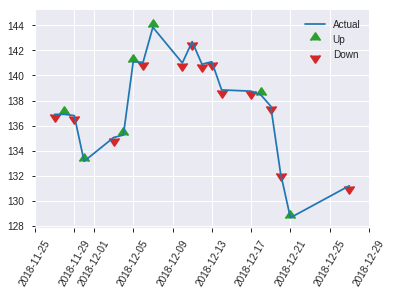


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2208526756873691
RMSE: 0.46994965228986935
LogLoss: 0.6366345705774713
Mean Per-Class Error: 0.33547978112905374
AUC: 0.7062591752302149
pr_auc: 0.6631524060578113
Gini: 0.41251835046042973
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3849638104438782: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   65   0.5118   (65.0/127.0)
1      21   97   0.178    (21.0/118.0)
Total  83   162  0.351    (86.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384964     0.692857  161
max f2                       0.114833     0.822873  244
max f0point5                 0.673278     0.668449  63
max accuracy                 0.673278     0.665306  63
max precision                0.719305     0.813953  42
max recall                   0.114833     1         244
max specificity              0.889584     0.992126  0
max absolute_mcc             0.673278     0.356567  63
max min_per_class_accuracy   0.532711     0.653543  121
max mean_per_class_accuracy  0.461848     0.66452   142

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.843248           1.38418   1.38418            0.666667         0.864106  0.666667                    0.864106            0.0169492       0.0169492                  38.4181   38.4181
    2        0.0204082                   0.815695           1.03814   1.24576            0.5              0.832712  0.6                         0.851548            0.00847458      0.0254237                  3.81356   24.5763
    3        0.0326531                   0.799521           1.38418   1.29767            0.666667         0.80711   0.625                       0.834884            0.0169492       0.0423729                  38.4181   29.7669
    4        0.0408163                   0.795111           2.07627   1.45339            1                0.797692  0.7                         0.827446            0.0169492       0.059322                   107.627   45.339
    5        0.0530612                   0.782923           2.07627   1.59713            1                0.789004  0.769231                    0.818574            0.0254237       0.0847458                  107.627   59.7132
    6        0.102041                    0.759908           1.5572    1.57797            0.75             0.773865  0.76                        0.797114            0.0762712       0.161017                   55.7203   57.7966
    7        0.15102                     0.728504           1.73023   1.62735            0.833333         0.745881  0.783784                    0.780498            0.0847458       0.245763                   73.0226   62.7348
    8        0.2                         0.696475           1.73023   1.65254            0.833333         0.717449  0.795918                    0.765057            0.0847458       0.330508                   73.0226   65.2542
    9        0.302041                    0.649839           1.16271   1.48706            0.56             0.674812  0.716216                    0.734569            0.118644        0.449153                   16.2712   48.7059
    10       0.4                         0.608667           0.951624  1.35593            0.458333         0.627097  0.653061                    0.708249            0.0932203       0.542373                   -4.83757  35.5932
    11       0.502041                    0.530536           1.16271   1.31666            0.56             0.572188  0.634146                    0.680595            0.118644        0.661017                   16.2712   31.666
    12       0.6                         0.443754           0.951624  1.25706            0.458333         0.481478  0.605442                    0.648086            0.0932203       0.754237                   -4.83757  25.7062
    13       0.697959                    0.356021           0.865113  1.20205            0.416667         0.387191  0.578947                    0.611469            0.0847458       0.838983                   -13.4887  20.2052
    14       0.8                         0.292593           0.664407  1.13347            0.32             0.32544   0.545918                    0.574986            0.0677966       0.90678                    -33.5593  13.3475
    15       0.897959                    0.214972           0.259534  1.03814            0.125            0.256537  0.5                         0.540246            0.0254237       0.932203                   -74.0466  3.81356
    16       1                           0.114833           0.664407  1                  0.32             0.166864  0.481633                    0.502146           

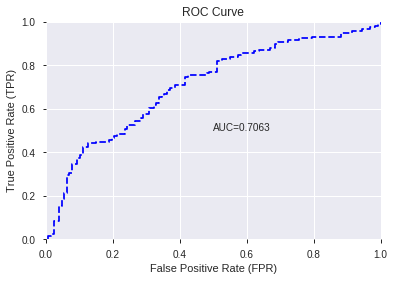

This function is available for GLM models only


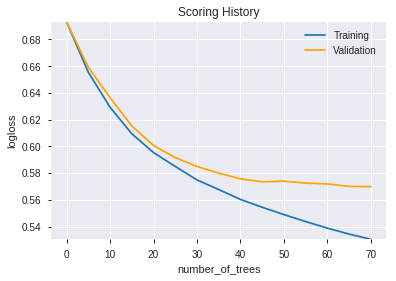

--2019-08-24 20:55:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_205458_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_205458_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'SUB',
 'CORREL_12',
 'STOCH_slowd',
 'day',
 'STOCHRSI_fastd',
 'MINUS_DI_30',
 'dayofyear',
 'SIN',
 'ULTOSC',
 'TRANGE',
 'HT_PHASOR_inphase',
 'CORREL_30',
 'BETA_24',
 'BETA_20',
 'SAREXT',
 'BETA_30',
 'LINEARREG_ANGLE_12',
 'week',
 'STOCHRSI_fastk',
 'WILLR_30',
 'BETA_8',
 'WILLR_12',
 'aroondown_12',
 'aroonup_8',
 'CMO_8',
 'WILLR_24',
 'LINEARREG_ANGLE_8',
 'WILLR_8',
 'CDLBELTHOLD',
 'WILLR_14',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'CMO_12']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_205530_model_1  0.52856  6.088163                   0.5  0.586858  0.344402

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.009313           1.000000    0.031736
1                STOCHF_fastk             0.005759           0.618340    0.019624
2          CDLCLOSINGMARUBOZU             0.005689           0.610870    0.019387
3                 CDLLONGLINE             0.005662           0.608010    0.019296
4              STOCHRSI_fastk             0.005400           0.579823    0.018401
...                       ...                  ...                ...         ...
1038  BBANDS_upperband_30_7_3             0.000000           0.000000    0.000000
1039       CDLKICKINGBYLENGTH             0.000000           0.000000    0.000000
1040       CDLSEPARATINGLINES             0.000000           0.000000    0.000000
1041                   MIN_30             0.000000           0.000000    0.000000
1042            MINMAX_min_30             0.000000           0.000000    0.000000

[1043 rows x 4 columns]

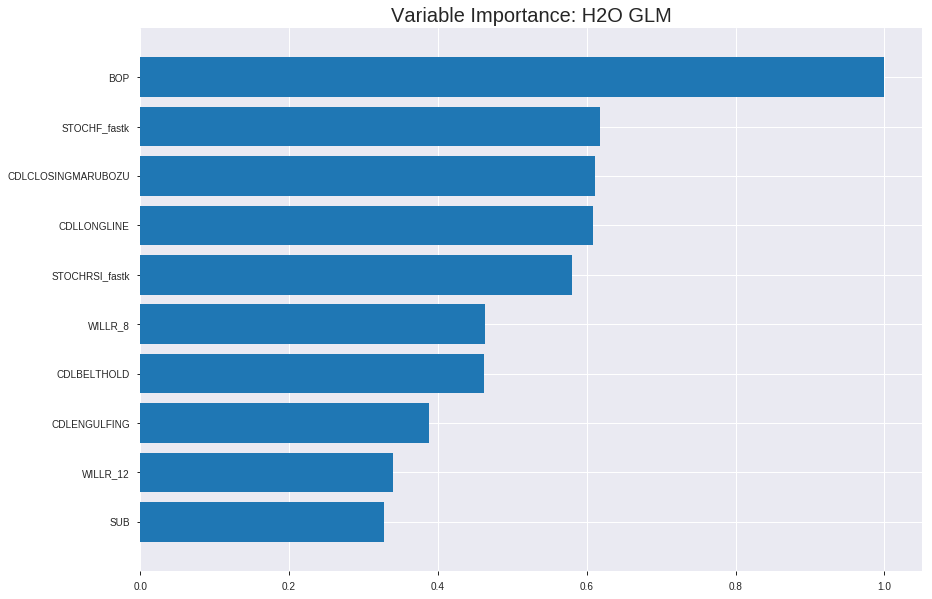

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_205530_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24376016891980007
RMSE: 0.49372073981128245
LogLoss: 0.6806105588367495
Null degrees of freedom: 1710
Residual degrees of freedom: 712
Null deviance: 2363.666519940619
Residual deviance: 2329.0493323393566
AIC: 4327.049332339357
AUC: 0.6663687288903534
pr_auc: 0.6742366720695434
Gini: 0.33273745778070674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5062263936605026: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      92   704   0.8844   (704.0/796.0)
1      26   889   0.0284   (26.0/915.0)
Total  118  1593  0.4267   (730.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506226     0.708931  347
max f2                       0.475654     0.851797  399
max f0point5                 0.529647     0.657614  228
max accuracy                 0.529647     0.638223  228
max precision                0.585503     1         0
max recall                   0.475654     1         399
max specificity              0.585503     1         0
max absolute_mcc             0.529647     0.268228  228
max min_per_class_accuracy   0.535237     0.622951  193
max mean_per_class_accuracy  0.529647     0.630542  228

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.574293           1.4544    1.4544             0.777778         0.577281  0.777778                    0.577281            0.0153005       0.0153005                  45.4402   45.4402
    2        0.0204559                   0.57178            1.20996   1.33568            0.647059         0.572845  0.714286                    0.575126            0.0120219       0.0273224                  20.9965   33.5675
    3        0.0303916                   0.568423           1.42996   1.3665             0.764706         0.569629  0.730769                    0.573329            0.0142077       0.0415301                  42.9958   36.6499
    4        0.0403273                   0.566263           1.64995   1.43633            0.882353         0.567454  0.768116                    0.571881            0.0163934       0.0579235                  64.9952   43.6335
    5        0.050263                    0.564884           1.42996   1.43507            0.764706         0.565419  0.767442                    0.570604            0.0142077       0.0721311                  42.9958   43.5074
    6        0.100526                    0.558764           1.41333   1.4242             0.755814         0.561582  0.761628                    0.566093            0.0710383       0.143169                   41.3331   42.4203
    7        0.150205                    0.554511           1.36396   1.40428            0.729412         0.556338  0.750973                    0.562867            0.0677596       0.210929                   36.396    40.4278
    8        0.200468                    0.551295           1.17415   1.34658            0.627907         0.552733  0.720117                    0.560326            0.0590164       0.269945                   17.4152   34.6579
    9        0.300409                    0.545596           1.23569   1.30969            0.660819         0.548414  0.700389                    0.556363            0.123497        0.393443                   23.5695   30.9689
    10       0.400351                    0.540167           1.10447   1.25846            0.590643         0.543006  0.672993                    0.553029            0.110383        0.503825                   10.4471   25.846
    11       0.500292                    0.535613           1.10447   1.2277             0.590643         0.537862  0.656542                    0.549999            0.110383        0.614208                   10.4471   22.7698
    12       0.600234                    0.530577           1.03886   1.19626            0.555556         0.533148  0.639727                    0.547193            0.103825        0.718033                   3.88585   19.6255
    13       0.700175                    0.524924           0.91857   1.15662            0.491228         0.527757  0.618531                    0.544419            0.0918033       0.809836                   -8.14304  15.6619
    14       0.800117                    0.51805            0.667057  1.09547            0.356725         0.521847  0.585829                    0.541599            0.0666667       0.876503                   -33.2943  9.54684
    15       0.900058                    0.509701           0.721733  1.05397            0.385965         0.51392   0.563636                    0.538526            0.0721311       0.948634                   -27.8267  5.39692
    16       1                           0.475654           0.513962  1                  0.274854         0.500995  0.534775                    0.534775          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38657564367711245
RMSE: 0.6217520757320497
LogLoss: 9.29818695995562
Null degrees of freedom: 488
Residual degrees of freedom: -510
Null deviance: 673.9994524945296
Residual deviance: 176277.68156994367
AIC: 178275.68156994367
AUC: 0.561595303168337
pr_auc: 0.6471843646487517
Gini: 0.12319060633667389
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.688803612127013e-182: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    267  0        (0.0/267.0)
Total  0    489  0.454    (222.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.6888e-182  0.706349  253
max f2                       3.6888e-182  0.857418  253
max f0point5                 3.6888e-182  0.60054   253
max accuracy                 0.524021     0.556237  129
max precision                0.558518     1         0
max recall                   3.6888e-182  1         253
max specificity              0.558518     1         0
max absolute_mcc             0.530894     0.190641  84
max min_per_class_accuracy   0.00690546   0.518018  245
max mean_per_class_accuracy  0.524021     0.578449  129

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 26.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.549824           1.83146   1.83146            1                0.552943     1                           0.552943            0.0187266       0.0187266                  83.1461   83.1461
    2        0.0204499                   0.547236           1.83146   1.83146            1                0.54795      1                           0.550447            0.0187266       0.0374532                  83.1461   83.1461
    3        0.0306748                   0.544634           1.83146   1.83146            1                0.545642     1                           0.548845            0.0187266       0.0561798                  83.1461   83.1461
    4        0.0408998                   0.542976           1.46517   1.73989            0.8              0.543764     0.95                        0.547575            0.0149813       0.071161                   46.5169   73.9888
    5        0.0511247                   0.540517           0.732584  1.53843            0.4              0.541606     0.84                        0.546381            0.00749064      0.0786517                  -26.7416  53.8427
    6        0.100204                    0.536267           1.29728   1.42032            0.708333         0.537641     0.77551                     0.5421              0.0636704       0.142322                   29.7285   42.0316
    7        0.151329                    0.531449           1.24539   1.36122            0.68             0.533898     0.743243                    0.539329            0.0636704       0.205993                   24.5393   36.1221
    8        0.200409                    0.528558           1.06835   1.2895             0.583333         0.5304       0.704082                    0.537142            0.0524345       0.258427                   6.83521   28.9498
    9        0.300613                    0.520609           1.00917   1.19606            0.55102          0.525001     0.653061                    0.533095            0.101124        0.359551                   0.917221  19.6056
    10       0.400818                    0.509023           0.971795  1.13999            0.530612         0.514891     0.622449                    0.528544            0.0973783       0.456929                   -2.82045  13.9991
    11       0.501022                    0.319528           0.598028  1.0316             0.326531         0.490233     0.563265                    0.520882            0.0599251       0.516854                   -40.1972  3.15983
    12       1                           0                  0.968272  1                  0.528689         3.06283e-05  0.546012                    0.260989            0.483146        1                          -3.17278  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 20:55:34  0.000 sec   2            18        999           1.36122           360.486
    2019-08-24 20:55:36  1.918 sec   4            13        1017          1.35512           360.686
    2019-08-24 20:55:38  3.803 sec   6            9.7       1021          1.34745           360.962
    2019-08-24 20:55:39  5.737 sec   8            7.1       1043          1.33802           361.33
    2019-08-24 20:55:41  7.668 sec   10           5.2       1044          1.32669           361.823

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5877551020408164)

('F1', 0.650137741046832)

('auc', 0.5285599893233685)

('logloss', 6.088162936479816)

('mean_per_class_error', 0.4159548912318164)

('rmse', 0.5868579798025917)

('mse', 0.34440228845797916)

glm prediction progress: |████████████████████████████████████████████████| 100%


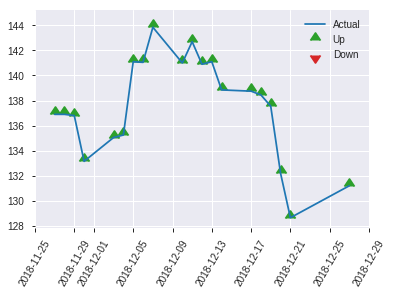


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.34440228845797916
RMSE: 0.5868579798025917
LogLoss: 6.088162936479816
Null degrees of freedom: 244
Residual degrees of freedom: -754
Null deviance: 342.0840315976776
Residual deviance: 50665.99432001142
AIC: 52663.99432001142
AUC: 0.5285599893233685
pr_auc: 0.5190829886272491
Gini: 0.0571199786467369
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.9916624800192784e-56: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    127  1        (127.0/127.0)
1      0    118  0        (0.0/118.0)
Total  0    245  0.5184   (127.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.99166e-56  0.650138  183
max f2                       1.99166e-56  0.822873  183
max f0point5                 0.506975     0.563241  96
max accuracy                 0.512623     0.587755  80
max precision                0.5303       0.666667  17
max recall                   1.99166e-56  1         183
max specificity              0.544888     0.992126  0
max absolute_mcc             0.512623     0.173431  80
max min_per_class_accuracy   0.50036      0.566929  121
max mean_per_class_accuracy  0.506975     0.584045  96

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 35.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.541199           0.69209   0.69209            0.333333         0.542769    0.333333                    0.542769            0.00847458      0.00847458                 -30.791   -30.791
    2        0.0204082                   0.539568           1.03814   0.830508           0.5              0.540531    0.4                         0.541874            0.00847458      0.0169492                  3.81356   -16.9492
    3        0.0326531                   0.538831           1.38418   1.03814            0.666667         0.539159    0.5                         0.540855            0.0169492       0.0338983                  38.4181   3.81356
    4        0.0408163                   0.53749            1.03814   1.03814            0.5              0.538358    0.5                         0.540356            0.00847458      0.0423729                  3.81356   3.81356
    5        0.0530612                   0.533848           2.07627   1.27771            1                0.535357    0.615385                    0.539202            0.0254237       0.0677966                  107.627   27.7705
    6        0.102041                    0.526546           1.03814   1.16271            0.5              0.529793    0.56                        0.534686            0.0508475       0.118644                   3.81356   16.2712
    7        0.15102                     0.52522            1.03814   1.12231            0.5              0.525985    0.540541                    0.531864            0.0508475       0.169492                   3.81356   12.2309
    8        0.2                         0.521048           1.38418   1.18644            0.666667         0.522679    0.571429                    0.529615            0.0677966       0.237288                   38.4181   18.6441
    9        0.302041                    0.513818           1.24576   1.20648            0.6              0.517624    0.581081                    0.525564            0.127119        0.364407                   24.5763   20.6482
    10       0.4                         0.506732           1.21116   1.20763            0.583333         0.510719    0.581633                    0.521928            0.118644        0.483051                   21.1158   20.7627
    11       0.502041                    0.500214           0.830508  1.13098            0.4              0.503488    0.544715                    0.51818             0.0847458       0.567797                   -16.9492  13.0977
    12       0.6                         0.490541           0.519068  1.03107            0.25             0.495853    0.496599                    0.514535            0.0508475       0.618644                   -48.0932  3.10734
    13       0.697959                    0.103829           0.173023  0.910645           0.0833333        0.454886    0.438596                    0.506163            0.0169492       0.635593                   -82.6977  -8.93547
    14       1                           0                  1.20648   1                  0.581081         0.00192733  0.481633                    0.353863            0.364407        1                          20.6482   0

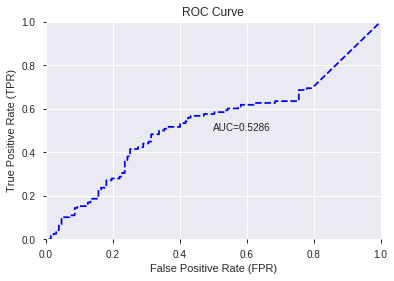

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


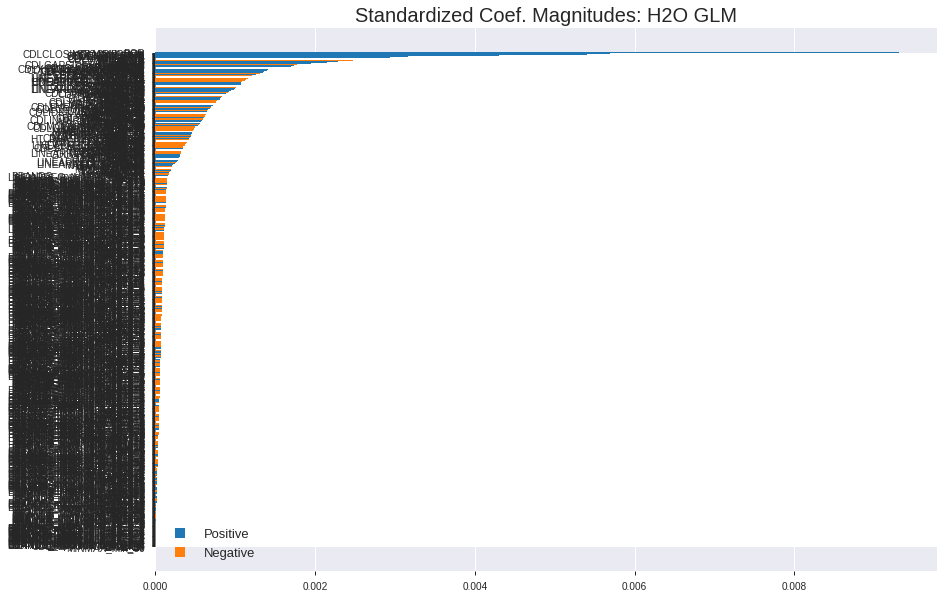

'log_likelihood'
--2019-08-24 20:56:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.64
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.64|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_205530_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_205530_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

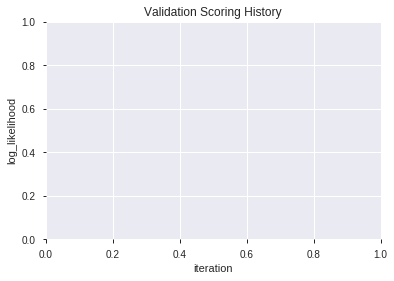

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_205605_model_4  0.708795  0.633034              0.324903  0.469150  0.220102
1               XGBoost_2_AutoML_20190824_205605  0.696116  0.646672              0.354898  0.474912  0.225541
2               XGBoost_3_AutoML_20190824_205605  0.694381  0.646835              0.320332  0.475081  0.225702
3               XGBoost_1_AutoML_20190824_205605  0.694048  0.658297              0.374283  0.478881  0.229327
4  XGBoost_grid_1_AutoML_20190824_205605_model_7  0.689110  0.663555              0.310356  0.479078  0.229516
5  XGBoost_grid_1_AutoML_20190824_205605_model_2  0.687642  0.652004              0.313659  0.477724  0.228220
6  XGBoost_grid_1_AutoML_20190824_205605_model_6  0.681303  0.652057              0.341552  0.477683  0.228181
7  XGBoost_grid_1_AutoML_20190824_205605_model_3  0.677499  0.655486              0.341252  0.478774  0.229224
8  XGBoost_grid_1_AutoML_20190824_205605_model_1  0.676565  0.659383              0.338816  0.480082  0.230479
9  XGBoost_grid_1_AutoML_20190824_205605_model_5  0.665855  0.664988              0.409115  0.484456  0.234697

variable  relative_importance  scaled_importance  percentage
0                BOP          1760.534180           1.000000    0.302292
1       STOCHF_fastk           249.261078           0.141583    0.042799
2                SUB           227.222626           0.129065    0.039015
3                DIV           208.522537           0.118443    0.035804
4            BETA_14           118.180130           0.067127    0.020292
..               ...                  ...                ...         ...
151        MACD_hist             5.352819           0.003040    0.000919
152         WILLR_20             5.302419           0.003012    0.000910
153          ADXR_12             4.870188           0.002766    0.000836
154  MACDFIX_hist_20             4.396415           0.002497    0.000755
155           CCI_24             2.950057           0.001676    0.000507

[156 rows x 4 columns]

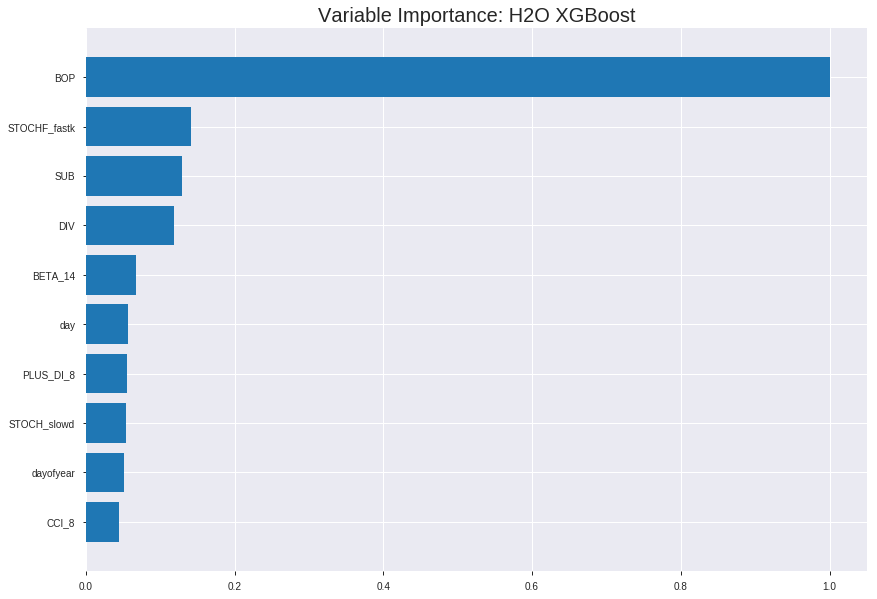

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_205605_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16771008299149462
RMSE: 0.40952421539085404
LogLoss: 0.5133501657128421
Mean Per-Class Error: 0.2364191174451492
AUC: 0.8524528379602933
pr_auc: 0.8680890169896537
Gini: 0.7049056759205865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43469901382923126: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      460  336   0.4221   (336.0/796.0)
1      91   824   0.0995   (91.0/915.0)
Total  551  1160  0.2496   (427.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434699     0.794217  246
max f2                       0.338654     0.884347  295
max f0point5                 0.636738     0.794109  132
max accuracy                 0.527062     0.765634  197
max precision                0.884858     1         0
max recall                   0.177872     1         376
max specificity              0.884858     1         0
max absolute_mcc             0.527062     0.528216  197
max min_per_class_accuracy   0.555039     0.75847   183
max mean_per_class_accuracy  0.537083     0.763581  192

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.847892           1.86995    1.86995            1                0.863999  1                           0.863999            0.0196721       0.0196721                  86.9945   86.9945
    2        0.0204559                   0.833318           1.86995    1.86995            1                0.8385    1                           0.851614            0.0185792       0.0382514                  86.9945   86.9945
    3        0.0303916                   0.822747           1.75995    1.83398            0.941176         0.82659   0.980769                    0.843433            0.0174863       0.0557377                  75.9949   83.3985
    4        0.0403273                   0.81366            1.86995    1.84284            1                0.818357  0.985507                    0.837255            0.0185792       0.0743169                  86.9945   84.2845
    5        0.050263                    0.808086           1.86995    1.8482             1                0.810086  0.988372                    0.831884            0.0185792       0.0928962                  86.9945   84.8202
    6        0.100526                    0.782097           1.80471    1.82646            0.965116         0.794577  0.976744                    0.813231            0.0907104       0.183607                   80.4715   82.6458
    7        0.150205                    0.756216           1.73795    1.79718            0.929412         0.7698    0.961089                    0.798866            0.0863388       0.269945                   73.7949   79.7185
    8        0.200468                    0.727538           1.60902    1.75001            0.860465         0.741528  0.93586                     0.78449             0.0808743       0.35082                    60.9023   75.0007
    9        0.300409                    0.67256            1.48721    1.66258            0.795322         0.698783  0.889105                    0.755977            0.148634        0.499454                   48.7208   66.2578
    10       0.400351                    0.620905           1.32318    1.57785            0.707602         0.646574  0.843796                    0.728666            0.13224         0.631694                   32.3178   57.7852
    11       0.500292                    0.563616           1.07166    1.47673            0.573099         0.591465  0.78972                     0.701258            0.107104        0.738798                   7.16646   47.6733
    12       0.600234                    0.495235           1.01699    1.40018            0.54386          0.528675  0.748783                    0.672522            0.101639        0.840437                   1.69878   40.0183
    13       0.700175                    0.413587           0.688927   1.29866            0.368421         0.455421  0.694491                    0.641533            0.0688525       0.90929                    -31.1073  29.866
    14       0.800117                    0.328516           0.601444   1.21157            0.321637         0.370772  0.647918                    0.607713            0.0601093       0.969399                   -39.8556  21.1572
    15       0.900058                    0.237341           0.262448   1.10618            0.140351         0.282543  0.591558                    0.571607            0.0262295       0.995628                   -73.7552  10.6182
    16       1                           0.0978689          0.0437414  1                  0.0233918        0.187897  0.534775                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19132571026389134
RMSE: 0.43740794490257184
LogLoss: 0.5682192440447678
Mean Per-Class Error: 0.26591760299625467
AUC: 0.7819533016162229
pr_auc: 0.7928820341518306
Gini: 0.5639066032324458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4622478187084198: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  94   0.4234   (94.0/222.0)
1      34   233  0.1273   (34.0/267.0)
Total  162  327  0.2618   (128.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462248     0.784512  261
max f2                       0.250025     0.868993  364
max f0point5                 0.51238      0.754052  230
max accuracy                 0.51238      0.740286  230
max precision                0.883835     1         0
max recall                   0.129855     1         399
max specificity              0.883835     1         0
max absolute_mcc             0.482824     0.475233  248
max min_per_class_accuracy   0.568067     0.71161   202
max mean_per_class_accuracy  0.51238      0.734082  230

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 54.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.831692           1.83146   1.83146            1                0.845943  1                           0.845943            0.0187266       0.0187266                  83.1461   83.1461
    2        0.0204499                   0.81107            1.83146   1.83146            1                0.823192  1                           0.834568            0.0187266       0.0374532                  83.1461   83.1461
    3        0.0306748                   0.803454           1.83146   1.83146            1                0.806093  1                           0.825076            0.0187266       0.0561798                  83.1461   83.1461
    4        0.0408998                   0.79346            1.83146   1.83146            1                0.79957   1                           0.818699            0.0187266       0.0749064                  83.1461   83.1461
    5        0.0511247                   0.78674            1.46517   1.7582             0.8              0.791599  0.96                        0.813279            0.0149813       0.0898876                  46.5169   75.8202
    6        0.100204                    0.765808           1.44991   1.6072             0.791667         0.776881  0.877551                    0.795452            0.071161        0.161049                   44.9906   60.72
    7        0.151329                    0.746041           1.53843   1.58397            0.84             0.758487  0.864865                    0.782964            0.0786517       0.2397                     53.8427   58.3966
    8        0.200409                    0.723334           1.22097   1.49507            0.666667         0.733404  0.816327                    0.770827            0.0599251       0.299625                   22.0974   49.507
    9        0.300613                    0.675995           1.42032   1.47015            0.77551          0.699269  0.802721                    0.746974            0.142322        0.441948                   42.0316   47.0152
    10       0.400818                    0.625273           1.27081   1.42032            0.693878         0.652399  0.77551                     0.72333             0.127341        0.569288                   27.0809   42.0316
    11       0.501022                    0.578934           1.15868   1.36799            0.632653         0.602263  0.746939                    0.699117            0.116105        0.685393                   15.8679   36.7989
    12       0.599182                    0.500722           1.25913   1.35016            0.6875           0.544531  0.737201                    0.673792            0.123596        0.808989                   25.9129   35.0155
    13       0.699387                    0.446042           0.784912  1.26917            0.428571         0.473028  0.692982                    0.645028            0.0786517       0.88764                    -21.5088  26.917
    14       0.799591                    0.360214           0.523274  1.17569            0.285714         0.400542  0.641944                    0.614389            0.0524345       0.940075                   -47.6726  17.5695
    15       0.899796                    0.269688           0.373767  1.08639            0.204082         0.315245  0.593182                    0.581075            0.0374532       0.977528                   -62.6233  8.63892
    16       1                           0.129855           0.22426   1                  0.122449         0.22004   0.546012                    0.544898            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:56:33  11.449 sec  0                  0.5              0.693147            0.5             0                  1                0.465225                         0.5                0.693147              0.5               0                    1                  0.453988
    2019-08-24 20:56:34  12.289 sec  5                  0.480762         0.655225            0.770926        0.782858           1.79203          0.318527                         0.483574           0.660722              0.764829          0.774169             1.52622            0.294479
    2019-08-24 20:56:34  12.593 sec  10                 0.466774         0.627948            0.77954         0.796697           1.86995          0.299825                         0.470683           0.635609              0.772008          0.78729              1.83146            0.276074
    2019-08-24 20:56:34  12.898 sec  15                 0.456024         0.606822            0.790069        0.808083           1.86995          0.320281                         0.461555           0.617761              0.771131          0.780271             1.83146            0.280164
    2019-08-24 20:56:35  13.199 sec  20                 0.448008         0.590757            0.795911        0.813054           1.86995          0.323203                         0.454265           0.603421              0.779406          0.789658             1.83146            0.274029
    2019-08-24 20:56:35  13.507 sec  25                 0.442247         0.579085            0.802735        0.818699           1.86995          0.318527                         0.449681           0.594204              0.779262          0.78732              1.83146            0.265849
    2019-08-24 20:56:35  13.820 sec  30                 0.436921         0.568119            0.80753         0.824827           1.86995          0.287551                         0.446468           0.587733              0.780106          0.789287             1.83146            0.271984
    2019-08-24 20:56:36  14.118 sec  35                 0.432983         0.559826            0.811357        0.829588           1.86995          0.286382                         0.443669           0.581982              0.779279          0.789638             1.83146            0.278119
    2019-08-24 20:56:36  14.437 sec  40                 0.42914          0.552034            0.817714        0.835357           1.86995          0.274109                         0.44153            0.577636              0.782687          0.792621             1.83146            0.274029
    2019-08-24 20:56:36  14.754 sec  45                 0.425251         0.544344            0.825584        0.843261           1.86995          0.268264                         0.440105           0.574536              0.783489          0.793167             1.83146            0.276074
    2019-08-24 20:56:37  15.068 sec  50                 0.422437         0.538645            0.829163        0.844819           1.76606          0.265342                         0.439345           0.572886              0.783143          0.794123             1.83146            0.274029
    2019-08-24 20:56:37  15.372 sec  55                 0.419115         0.532131            0.835137        0.85071            1.86995          0.261835                         0.438563           0.57137               0.783235          0

Variable Importances: 


variable         relative_importance    scaled_importance      percentage
---------------  ---------------------  ---------------------  ---------------------
BOP              1760.5341796875        1.0                    0.30229180241973375
STOCHF_fastk     249.26107788085938     0.14158264051715483    0.042799271593275956
SUB              227.22262573242188     0.12906459207327323    0.03901516816639744
DIV              208.5225372314453      0.11844276563176903    0.03580427710640555
BETA_14          118.18013000488281     0.06712742721408575    0.020292070964345463
---              ---                    ---                    ---
MACD_hist        5.352818965911865      0.0030404516013781717  0.0009191035947505732
WILLR_20         5.3024187088012695     0.003011823780520106   0.0009104496391840393
ADXR_12          4.870187759399414      0.0027663125292255826  0.0008362336005158937
MACDFIX_hist_20  4.396414756774902      0.0024972050003342046  0.0007548846005625985
CCI_24           2.9500572681427        0.0016756603207024041  0.0005065383785883587


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6816326530612244)

('F1', 0.7075812274368232)

('auc', 0.708794875216869)

('logloss', 0.6330340306008907)

('mean_per_class_error', 0.31759642332843985)

('rmse', 0.4691499456065277)

('mse', 0.2201016714626079)

xgboost prediction progress: |████████████████████████████████████████████| 100%


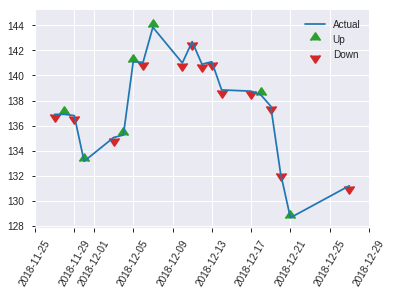


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2201016714626079
RMSE: 0.4691499456065277
LogLoss: 0.6330340306008907
Mean Per-Class Error: 0.31759642332843985
AUC: 0.708794875216869
pr_auc: 0.6566396533250316
Gini: 0.417589750433738
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4399316906929016: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   61   0.4803   (61.0/127.0)
1      20   98   0.1695   (20.0/118.0)
Total  86   159  0.3306   (81.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439932     0.707581  158
max f2                       0.180816     0.827489  240
max f0point5                 0.541252     0.667203  125
max accuracy                 0.541252     0.681633  125
max precision                0.875381     1         0
max recall                   0.180816     1         240
max specificity              0.875381     1         0
max absolute_mcc             0.451792     0.366821  151
max min_per_class_accuracy   0.559392     0.669291  120
max mean_per_class_accuracy  0.541252     0.682404  125

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.841282           1.38418   1.38418            0.666667         0.865574  0.666667                    0.865574            0.0169492       0.0169492                  38.4181   38.4181
    2        0.0204082                   0.822257           1.03814   1.24576            0.5              0.827552  0.6                         0.850365            0.00847458      0.0254237                  3.81356   24.5763
    3        0.0326531                   0.819351           2.07627   1.5572             1                0.820154  0.75                        0.839036            0.0254237       0.0508475                  107.627   55.7203
    4        0.0408163                   0.813256           2.07627   1.66102            1                0.816692  0.8                         0.834567            0.0169492       0.0677966                  107.627   66.1017
    5        0.0530612                   0.807304           1.38418   1.59713            0.666667         0.811286  0.769231                    0.829195            0.0169492       0.0847458                  38.4181   59.7132
    6        0.102041                    0.778633           1.5572    1.57797            0.75             0.788024  0.76                        0.809433            0.0762712       0.161017                   55.7203   57.7966
    7        0.15102                     0.763587           1.38418   1.51512            0.666667         0.772409  0.72973                     0.797425            0.0677966       0.228814                   38.4181   51.5117
    8        0.2                         0.74372            1.38418   1.48305            0.666667         0.753989  0.714286                    0.786788            0.0677966       0.29661                    38.4181   48.3051
    9        0.302041                    0.703667           1.41186   1.459              0.68             0.722426  0.702703                    0.765044            0.144068        0.440678                   41.1864   45.9001
    10       0.4                         0.635992           1.12465   1.37712            0.541667         0.670486  0.663265                    0.741887            0.110169        0.550847                   12.4647   37.7119
    11       0.502041                    0.557174           1.24576   1.35042            0.6              0.592354  0.650407                    0.711494            0.127119        0.677966                   24.5763   35.042
    12       0.6                         0.4724             1.03814   1.29944            0.5              0.507577  0.62585                     0.678202            0.101695        0.779661                   3.81356   29.9435
    13       0.697959                    0.383044           0.605579  1.20205            0.291667         0.432595  0.578947                    0.64373             0.059322        0.838983                   -39.4421  20.2052
    14       0.8                         0.323337           0.498305  1.11229            0.24             0.354675  0.535714                    0.606861            0.0508475       0.889831                   -50.1695  11.2288
    15       0.897959                    0.244355           0.519068  1.04757            0.25             0.282913  0.504545                    0.571521            0.0508475       0.940678                   -48.0932  4.75732
    16       1                           0.129767           0.581356  1                  0.28             0.197672  0.481633                    0.533373          

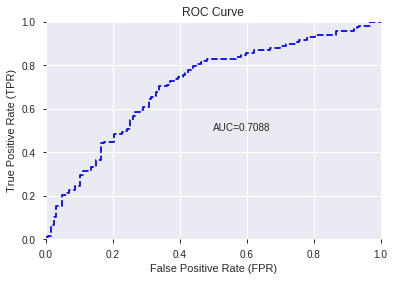

This function is available for GLM models only


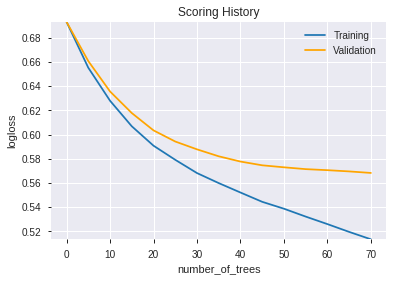

--2019-08-24 20:56:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_205605_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_205605_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_205704_model_5  0.705992  0.658222              0.344288  0.473991  0.224667
1  DeepLearning_grid_1_AutoML_20190824_205704_model_8  0.705592  0.679293              0.329741  0.476019  0.226594
2  DeepLearning_grid_1_AutoML_20190824_205704_model_6  0.704858  0.704783              0.333678  0.481665  0.232001
3  DeepLearning_grid_1_AutoML_20190824_205704_model_9  0.697584  0.656709              0.344889  0.476881  0.227415
4  DeepLearning_grid_1_AutoML_20190824_205704_model_4  0.695249  0.854725              0.332477  0.510580  0.260692
5  DeepLearning_grid_1_AutoML_20190824_205704_model_7  0.662952  0.751696              0.400641  0.498764  0.248766
6               DeepLearning_1_AutoML_20190824_205704  0.649873  0.722077              0.397604  0.501007  0.251008
7  DeepLearning_grid_1_AutoML_20190824_205704_model_1  0.640865  1.060404              0.407013  0.548742  0.301118
8  DeepLearning_grid_1_AutoML_20190824_205704_model_3  0.629054  0.824021              0.366075  0.526860  0.277581
9  DeepLearning_grid_1_AutoML_20190824_205704_model_2  0.603029  0.994177              0.430335  0.561768  0.315583

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.037409
1                  day             0.695712           0.695712    0.026026
2         STOCHF_fastk             0.658218           0.658218    0.024623
3       STOCHRSI_fastd             0.656883           0.656883    0.024573
4                  DIV             0.643222           0.643222    0.024062
5   CDLCLOSINGMARUBOZU             0.641484           0.641484    0.023997
6                  SUB             0.628458           0.628458    0.023510
7          MINUS_DI_30             0.617521           0.617521    0.023101
8            CORREL_30             0.606189           0.606189    0.022677
9                  SIN             0.602560           0.602560    0.022541
10         STOCH_slowd             0.581826           0.581826    0.021766
11        HT_TRENDMODE             0.559287           0.559287    0.020922
12         CDLBELTHOLD             0.553328           0.553328    0.020700
13           CORREL_12             0.549645           0.549645    0.020562
14              SAREXT             0.542960           0.542960    0.020312
15        aroondown_12             0.541834           0.541834    0.020270
16             BETA_24             0.540658           0.540658    0.020226
17        is_month_end             0.530535           0.530535    0.019847
18        CDLSHORTLINE             0.529715           0.529715    0.019816
19      STOCHRSI_fastk             0.527898           0.527898    0.019748
20             quarter             0.524999           0.524999    0.019640
21            WILLR_24             0.524886           0.524886    0.019635
22              TRANGE             0.522827           0.522827    0.019558
23              ULTOSC             0.519115           0.519115    0.019420
24           dayofyear             0.516480           0.516480    0.019321
25            WILLR_30             0.513379           0.513379    0.019205
26              BETA_8             0.510033           0.510033    0.019080
27               month             0.507511           0.507511    0.018986
28         CDLLONGLINE             0.506338           0.506338    0.018942
29          weekofyear             0.499532           0.499532    0.018687
30        CDLENGULFING             0.499133           0.499133    0.018672
31                week             0.498918           0.498918    0.018664
32           CDLTAKURI             0.497140           0.497140    0.018598
33           aroonup_8             0.496757           0.496757    0.018583
34             WILLR_8             0.493971           0.493971    0.018479
35             BETA_20             0.491951           0.491951    0.018403
36       CDLHANGINGMAN             0.491788           0.491788    0.018397
37            WILLR_14             0.487152           0.487152    0.018224
38             BETA_30             0.483640           0.483640    0.018093
39              CMO_12             0.468288           0.468288    0.017518
40  LINEARREG_ANGLE_12             0.467109           0.467109    0.017474
41               CMO_8             0.464652           0.464652    0.017382
42          AROONOSC_8             0.457245           0.457245    0.017105
43               RSI_8             0.453766           0.453766    0.016975
44            WILLR_12             0.450714           0.450714    0.016861
45   LINEARREG_ANGLE_8             0.449153           0.449153    0.016802
46   HT_PHASOR_inphase             0.440847           0.440847    0.016492
47    CDLDRAGONFLYDOJI             0.432958           0.432958    0.016197
48            WILLR_20             0.428451           0.428451    0.016028
49  LINEARREG_SLOPE_12             0.424805           0.424805    0.015892

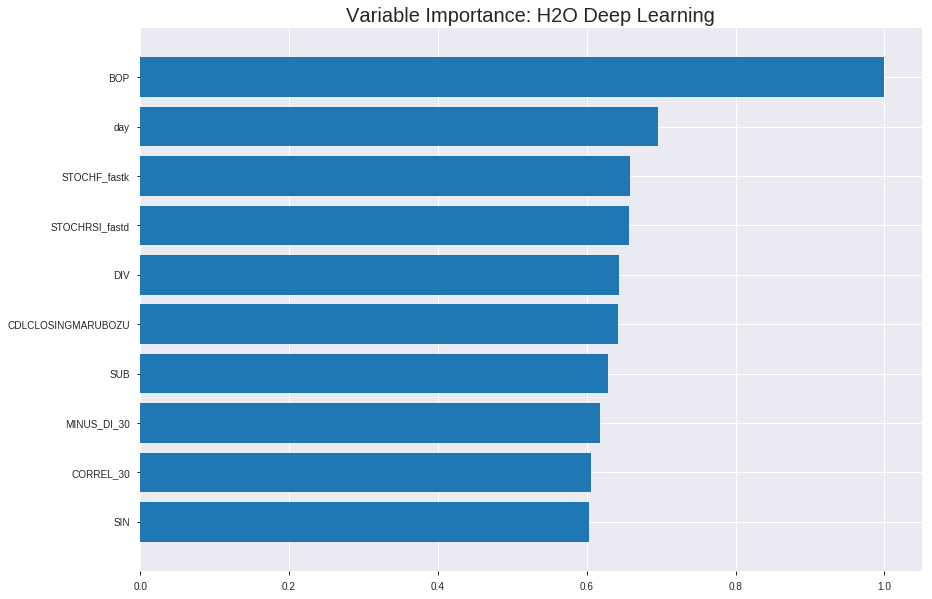

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_205704_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19451742830940044
RMSE: 0.44104130000420644
LogLoss: 0.5708076469560562
Mean Per-Class Error: 0.3039226185572672
AUC: 0.7709798994974875
pr_auc: 0.7770384381844498
Gini: 0.5419597989949749
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4728094379845391: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  416   0.5226   (416.0/796.0)
1      103  812   0.1126   (103.0/915.0)
Total  483  1228  0.3033   (519.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472809     0.757816  247
max f2                       0.293142     0.870281  321
max f0point5                 0.563487     0.718799  192
max accuracy                 0.472809     0.696669  247
max precision                0.984927     1         0
max recall                   0.0686478    1         389
max specificity              0.984927     1         0
max absolute_mcc             0.472809     0.40427   247
max min_per_class_accuracy   0.563487     0.69598   192
max mean_per_class_accuracy  0.563487     0.696077  192

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 55.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105202                   0.9434             1.76606   1.76606            0.944444         0.958541  0.944444                    0.958541            0.0185792       0.0185792                  76.606     76.606
    2        0.0204559                   0.925042           1.53995   1.65624            0.823529         0.934595  0.885714                    0.94691             0.0153005       0.0338798                  53.9955    65.6237
    3        0.0303916                   0.908608           1.86995   1.7261             1                0.916402  0.923077                    0.936936            0.0185792       0.052459                   86.9945    72.6103
    4        0.0403273                   0.892575           1.42996   1.65314            0.764706         0.899448  0.884058                    0.9277              0.0142077       0.0666667                  42.9958    65.314
    5        0.050263                    0.876698           1.75995   1.67425            0.941176         0.883297  0.895349                    0.918923            0.0174863       0.084153                   75.9949    67.4253
    6        0.100526                    0.804946           1.58728   1.63077            0.848837         0.839285  0.872093                    0.879104            0.0797814       0.163934                   58.7279    63.0766
    7        0.150205                    0.752901           1.62795   1.62984            0.870588         0.779269  0.871595                    0.846085            0.0808743       0.244809                   62.7952    62.9836
    8        0.200468                    0.707399           1.5003    1.59736            0.802326         0.730649  0.854227                    0.817142            0.0754098       0.320219                   50.0305    59.7359
    9        0.300409                    0.645553           1.27944   1.49159            0.684211         0.676187  0.797665                    0.770248            0.127869        0.448087                   27.9436    49.1591
    10       0.400351                    0.593411           1.19195   1.41679            0.637427         0.615065  0.757664                    0.731509            0.119126        0.567213                   19.1953    41.6791
    11       0.500292                    0.564974           1.09354   1.35222            0.584795         0.577772  0.723131                    0.700798            0.10929         0.676503                   9.35353    35.2215
    12       0.600234                    0.533566           0.995117  1.29276            0.532164         0.550247  0.691334                    0.67573             0.0994536       0.775956                   -0.488288  29.2757
    13       0.700175                    0.485538           0.91857   1.23935            0.491228         0.511246  0.662771                    0.652252            0.0918033       0.86776                    -8.14304   23.9346
    14       0.800117                    0.410669           0.732669  1.17606            0.391813         0.449612  0.628926                    0.626941            0.073224        0.940984                   -26.7331   17.6058
    15       0.900058                    0.264393           0.459285  1.09647            0.245614         0.34079   0.586364                    0.595167            0.0459016       0.986885                   -54.0715   9.6468
    16       1                           0.0151934          0.131224  1                  0.0701754        0.159625  0.534775                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19786469930199937
RMSE: 0.4448198503911436
LogLoss: 0.5830159282897793
Mean Per-Class Error: 0.2864662415224213
AUC: 0.7654958329115633
pr_auc: 0.7963477770636211
Gini: 0.5309916658231266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4826630751545051: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  105  0.473    (105.0/222.0)
1      34   233  0.1273   (34.0/267.0)
Total  151  338  0.2843   (139.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482663     0.770248  260
max f2                       0.390511     0.867937  316
max f0point5                 0.551203     0.742036  198
max accuracy                 0.486243     0.715746  258
max precision                0.95592      1         0
max recall                   0.0103587    1         398
max specificity              0.95592      1         0
max absolute_mcc             0.482663     0.430729  260
max min_per_class_accuracy   0.551203     0.711712  198
max mean_per_class_accuracy  0.551203     0.713534  198

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.910252           1.83146   1.83146            1                0.929901  1                           0.929901            0.0187266       0.0187266                  83.1461   83.1461
    2        0.0204499                   0.89899            1.83146   1.83146            1                0.908392  1                           0.919146            0.0187266       0.0374532                  83.1461   83.1461
    3        0.0306748                   0.873523           1.83146   1.83146            1                0.885134  1                           0.907809            0.0187266       0.0561798                  83.1461   83.1461
    4        0.0408998                   0.858668           1.83146   1.83146            1                0.866034  1                           0.897365            0.0187266       0.0749064                  83.1461   83.1461
    5        0.0511247                   0.845307           1.83146   1.83146            1                0.850953  1                           0.888083            0.0187266       0.093633                   83.1461   83.1461
    6        0.100204                    0.769607           1.83146   1.83146            1                0.811471  1                           0.850559            0.0898876       0.183521                   83.1461   83.1461
    7        0.151329                    0.700288           1.24539   1.63346            0.68             0.735113  0.891892                    0.811557            0.0636704       0.247191                   24.5393   63.3465
    8        0.200409                    0.663004           1.3736    1.56982            0.75             0.677312  0.857143                    0.77868             0.0674157       0.314607                   37.3596   56.9823
    9        0.300613                    0.610669           1.1213    1.42032            0.612245         0.633047  0.77551                     0.730136            0.11236         0.426966                   12.1302   42.0316
    10       0.400818                    0.577484           1.27081   1.38294            0.693878         0.592315  0.755102                    0.695681            0.127341        0.554307                   27.0809   38.294
    11       0.501022                    0.554728           1.34556   1.37546            0.734694         0.566832  0.75102                     0.669911            0.134831        0.689139                   34.5563   37.5464
    12       0.599182                    0.525701           0.801264  1.2814             0.4375           0.541086  0.699659                    0.648807            0.0786517       0.76779                    -19.8736  28.1397
    13       0.699387                    0.474745           1.04655   1.24775            0.571429         0.505403  0.681287                    0.62826             0.104869        0.872659                   4.6549    24.775
    14       0.799591                    0.414329           0.635405  1.17101            0.346939         0.447217  0.639386                    0.605572            0.0636704       0.93633                    -36.4595  17.1011
    15       0.899796                    0.273766           0.299014  1.0739             0.163265         0.343481  0.586364                    0.576385            0.0299625       0.966292                   -70.0986  7.39019
    16       1                           0.00975336         0.336391  1                  0.183673         0.166672  0.546012                    0.53533            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 21:00:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 21:00:21  1 min 18.956 sec  1384 obs/sec      1.51958   1             2600       0.470812         0.633783            0.109035       0.705296        0.713201           1.55829          0.357686                         0.470332           0.63212               0.107592         0.702053          0.737148             1.83146            0.390593
    2019-08-24 21:00:28  1 min 25.913 sec  2244 obs/sec      10.7136   7             18331      0.441041         0.570808            0.218148       0.77098         0.777038           1.76606          0.303331                         0.44482            0.583016              0.201781         0.765496          0.796348             1.83146            0.284254
    2019-08-24 21:00:35  1 min 33.078 sec  2495 obs/sec      21.4366   14            36678      0.428408         0.540105            0.262297       0.796698        0.812163           1.86995          0.290473                         0.445017           0.585783              0.201074         0.767841          0.789647             1.83146            0.300613
    2019-08-24 21:00:42  1 min 40.006 sec  2624 obs/sec      32.1765   21            55054      0.413589         0.507391            0.312452       0.826492        0.842587           1.86995          0.277615                         0.449344           0.600716              0.185461         0.753037          0.772207             1.83146            0.316973
    2019-08-24 21:00:49  1 min 46.809 sec  2705 obs/sec      42.9077   28            73415      0.393906         0.463905            0.376335       0.854908        0.859851           1.86995          0.241964                         0.455311           0.634149              0.163685         0.746297          0.750078             1.83146            0.333333
    2019-08-24 21:00:56  1 min 53.398 sec  2777 obs/sec      53.6686   35            91827      0.384663         0.446665            0.405262       0.877479        0.893444           1.86995          0.218586                         0.469582           0.660219              0.110437         0.713382          0.73141              1.46517            0.349693
    2019-08-24 21:00:56  1 min 54.053 sec  2775 obs/sec      53.6686   35            91827      0.441041         0.570808            0.218148       0.77098         0.777038           1.76606          0.303331                         0.44482            0.583016              0.201781         0.765496          0.796348             1.83146            0.284254

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.037409093374846006
day                 0.6957118511199951     0.6957118511199951   0.026025949600534858
STOCHF_fastk        0.65821772813797       0.65821772813797     0.02462332845289232
STOCHRSI_fastd      0.6568834781646729     0.6568834781646729   0.024573415371055864
DIV                 0.6432217359542847     0.6432217359542847   0.024062341981044375
---                 ---                    ---                  ---
LINEARREG_ANGLE_8   0.44915348291397095    0.44915348291397095  0.016802424581966038
HT_PHASOR_inphase   0.44084668159484863    0.44084668159484863  0.016491674675772696
CDLDRAGONFLYDOJI    0.43295764923095703    0.43295764923095703  0.016196553127434694
WILLR_20            0.42845088243484497    0.42845088243484497  0.016027959067540284
LINEARREG_SLOPE_12  0.4248045086860657     0.4248045086860657   0.01589155153149261


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.673469387755102)

('F1', 0.6971830985915494)

('auc', 0.7059922594421459)

('logloss', 0.6582219874439005)

('mean_per_class_error', 0.3248698785533164)

('rmse', 0.47399062272390774)

('mse', 0.22466711043019785)

deeplearning prediction progress: |███████████████████████████████████████| 100%


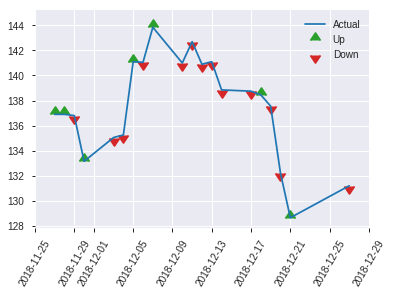


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22466711043019785
RMSE: 0.47399062272390774
LogLoss: 0.6582219874439005
Mean Per-Class Error: 0.3248698785533164
AUC: 0.7059922594421459
pr_auc: 0.6603186831118865
Gini: 0.4119845188842919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4413928430370311: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   67   0.5276   (67.0/127.0)
1      19   99   0.161    (19.0/118.0)
Total  79   166  0.351    (86.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441393     0.697183  165
max f2                       0.0249528    0.825175  242
max f0point5                 0.521697     0.657895  131
max accuracy                 0.521697     0.673469  131
max precision                0.962231     1         0
max recall                   0.0249528    1         242
max specificity              0.962231     1         0
max absolute_mcc             0.521697     0.351081  131
max min_per_class_accuracy   0.545056     0.652542  120
max mean_per_class_accuracy  0.521697     0.67513   131

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 49.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0122449                   0.928007           2.07627   2.07627            1                0.941751   1                           0.941751            0.0254237       0.0254237                  107.627    107.627
    2        0.0204082                   0.885819           1.03814   1.66102            0.5              0.915597   0.8                         0.93129             0.00847458      0.0338983                  3.81356    66.1017
    3        0.0326531                   0.879999           0.69209   1.29767            0.333333         0.882148   0.625                       0.912862            0.00847458      0.0423729                  -30.791    29.7669
    4        0.0408163                   0.873153           2.07627   1.45339            1                0.877198   0.7                         0.905729            0.0169492       0.059322                   107.627    45.339
    5        0.0530612                   0.864043           1.38418   1.43742            0.666667         0.870616   0.692308                    0.897626            0.0169492       0.0762712                  38.4181    43.7419
    6        0.102041                    0.765545           1.73023   1.57797            0.833333         0.796332   0.76                        0.849005            0.0847458       0.161017                   73.0226    57.7966
    7        0.15102                     0.699944           1.21116   1.459              0.583333         0.724528   0.702703                    0.808634            0.059322        0.220339                   21.1158    45.9001
    8        0.2                         0.651846           1.5572    1.48305            0.75             0.678551   0.714286                    0.776777            0.0762712       0.29661                    55.7203    48.3051
    9        0.302041                    0.606945           1.49492   1.48706            0.72             0.622501   0.716216                    0.724657            0.152542        0.449153                   49.4915    48.7059
    10       0.4                         0.576436           1.12465   1.39831            0.541667         0.587769   0.673469                    0.691133            0.110169        0.559322                   12.4647    39.8305
    11       0.502041                    0.53932            0.99661   1.31666            0.48             0.560896   0.634146                    0.664662            0.101695        0.661017                   -0.338983  31.666
    12       0.6                         0.494841           1.03814   1.27119            0.5              0.517538   0.612245                    0.640642            0.101695        0.762712                   3.81356    27.1186
    13       0.697959                    0.404221           0.778602  1.20205            0.375            0.45942    0.578947                    0.615207            0.0762712       0.838983                   -22.1398   20.2052
    14       0.8                         0.301561           0.664407  1.13347            0.32             0.363844   0.545918                    0.583145            0.0677966       0.90678                    -33.5593   13.3475
    15       0.897959                    0.169081           0.259534  1.03814            0.125            0.248165   0.5                         0.546602            0.0254237       0.932203                   -74.0466   3.81356
    16       1                           0.011048           0.664407  1                  0.32             0.0839433  0.481633    

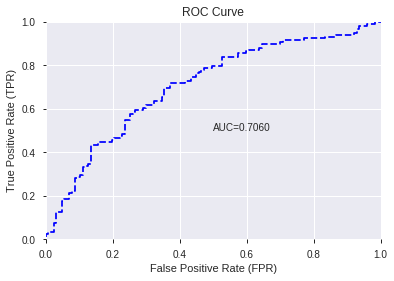

This function is available for GLM models only


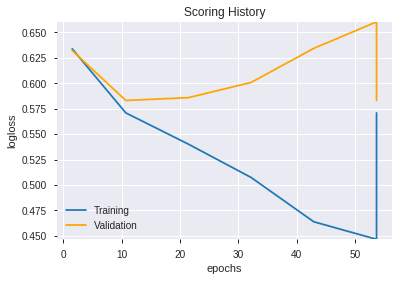

--2019-08-24 21:06:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_205704_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_205704_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'day',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'MINUS_DI_30',
 'CORREL_30',
 'SIN',
 'STOCH_slowd',
 'HT_TRENDMODE',
 'CDLBELTHOLD',
 'CORREL_12',
 'SAREXT',
 'aroondown_12',
 'BETA_24',
 'is_month_end',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'quarter',
 'WILLR_24',
 'TRANGE',
 'ULTOSC',
 'dayofyear',
 'WILLR_30',
 'BETA_8',
 'month',
 'CDLLONGLINE',
 'weekofyear',
 'CDLENGULFING',
 'week',
 'CDLTAKURI',
 'aroonup_8',
 'WILLR_8',
 'BETA_20',
 'CDLHANGINGMAN',
 'WILLR_14',
 'BETA_30',
 'CMO_12',
 'LINEARREG_ANGLE_12',
 'CMO_8',
 'AROONOSC_8',
 'RSI_8',
 'WILLR_12',
 'LINEARREG_ANGLE_8',
 'HT_PHASOR_inphase',
 'CDLDRAGONFLYDOJI',
 'WILLR_20',
 'LINEARREG_SLOPE_12']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_210651_model_1  0.738089  0.607543              0.331576  0.456448  0.208345

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.816082           1.000000    0.128309
1         STOCHF_fastk             0.320899           0.393219    0.050454
2             WILLR_24             0.305569           0.374434    0.048043
3          STOCH_slowd             0.301387           0.369310    0.047386
4                  SUB             0.279409           0.342378    0.043930
5            CDLTAKURI             0.261068           0.319905    0.041047
6          CDLBELTHOLD             0.253564           0.310709    0.039867
7       STOCHRSI_fastd             0.227643           0.278947    0.035791
8             WILLR_20             0.223365           0.273704    0.035119
9               CMO_12             0.215347           0.263879    0.033858
10             quarter             0.214331           0.262634    0.033698
11            WILLR_14             0.173257           0.212304    0.027241
12        is_month_end             0.164643           0.201748    0.025886
13    CDLDRAGONFLYDOJI             0.158262           0.193929    0.024883
14           dayofyear             0.148708           0.182222    0.023381
15        aroondown_12             0.138624           0.169865    0.021795
16              ULTOSC             0.134471           0.164777    0.021142
17         MINUS_DI_30             0.129102           0.158197    0.020298
18   HT_PHASOR_inphase             0.119664           0.146632    0.018814
19           CORREL_12             0.117483           0.143960    0.018471
20          AROONOSC_8             0.113593           0.139193    0.017860
21              SAREXT             0.113209           0.138723    0.017799
22              BETA_8             0.112754           0.138165    0.017728
23  LINEARREG_ANGLE_12             0.108807           0.133328    0.017107
24        CDLSHORTLINE             0.097072           0.118949    0.015262
25           aroonup_8             0.093866           0.115021    0.014758
26      STOCHRSI_fastk             0.093725           0.114848    0.014736
27  LINEARREG_SLOPE_12             0.085499           0.104767    0.013443
28             BETA_24             0.080406           0.098527    0.012642
29   LINEARREG_ANGLE_8             0.074311           0.091058    0.011684
30          weekofyear             0.068471           0.083903    0.010765
31                week             0.065123           0.079799    0.010239
32                 day             0.064004           0.078429    0.010063
33            WILLR_30             0.060366           0.073971    0.009491
34             WILLR_8             0.060127           0.073678    0.009454
35           CORREL_30             0.053712           0.065816    0.008445
36        CDLENGULFING             0.052177           0.063936    0.008204
37               month             0.046593           0.057093    0.007326
38        HT_TRENDMODE             0.046341           0.056784    0.007286
39              TRANGE             0.041841           0.051271    0.006578
40               CMO_8             0.027328           0.033487    0.004297
41                 SIN             0.025421           0.031150    0.003997
42       CDLHANGINGMAN             0.022674           0.027784    0.003565
43                 DIV             0.017922           0.021961    0.002818
44               RSI_8             0.009438           0.011565    0.001484
45            WILLR_12             0.009144           0.011205    0.001438
46             BETA_30             0.004389           0.005378    0.000690
47  CDLCLOSINGMARUBOZU             0.003744           0.004588    0.000589
48             BETA_20             0.003223           0.003949    0.000507
49         CDLLONGLINE             0.002120           0.002598    0.000333

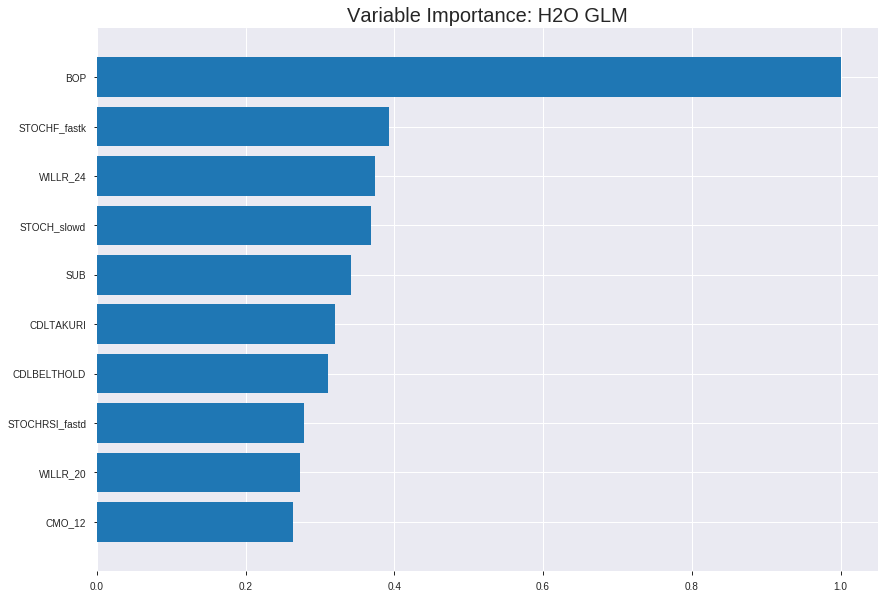

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_210651_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19976178851330545
RMSE: 0.4469471876109139
LogLoss: 0.5853333721841121
Null degrees of freedom: 1710
Residual degrees of freedom: 1660
Null deviance: 2363.666519940619
Residual deviance: 2003.0107996140314
AIC: 2105.0107996140314
AUC: 0.7548239833045006
pr_auc: 0.7509903611506762
Gini: 0.5096479666090012
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31680895469275683: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      283  513   0.6445   (513.0/796.0)
1      66   849   0.0721   (66.0/915.0)
Total  349  1362  0.3384   (579.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316809     0.745718  292
max f2                       0.20573      0.859271  347
max f0point5                 0.561011     0.718598  177
max accuracy                 0.502        0.702513  207
max precision                0.953994     1         0
max recall                   0.0987071    1         387
max specificity              0.953994     1         0
max absolute_mcc             0.46354      0.400709  224
max min_per_class_accuracy   0.546484     0.694724  184
max mean_per_class_accuracy  0.502        0.698249  207

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.898541           1.66217   1.66217            0.888889         0.914831  0.888889                    0.914831            0.0174863       0.0174863                  66.2174   66.2174
    2        0.0204559                   0.883191           1.53995   1.60281            0.823529         0.890932  0.857143                    0.903223            0.0153005       0.0327869                  53.9955   60.281
    3        0.0303916                   0.8688             1.53995   1.58226            0.823529         0.875904  0.846154                    0.894292            0.0153005       0.0480874                  53.9955   58.2261
    4        0.0403273                   0.859808           1.75995   1.62604            0.941176         0.864154  0.869565                    0.886867            0.0174863       0.0655738                  75.9949   62.6039
    5        0.050263                    0.850836           1.20996   1.54379            0.647059         0.854858  0.825581                    0.880539            0.0120219       0.0775956                  20.9965   54.3792
    6        0.100526                    0.812081           1.5003    1.52205            0.802326         0.830468  0.813953                    0.855504            0.0754098       0.153005                   50.0305   52.2049
    7        0.150205                    0.774207           1.56195   1.53525            0.835294         0.792241  0.821012                    0.83458             0.0775956       0.230601                   56.1954   53.5247
    8        0.200468                    0.749972           1.52205   1.53194            0.813953         0.761007  0.819242                    0.816133            0.0765027       0.307104                   52.2049   53.1938
    9        0.300409                    0.688215           1.32318   1.46249            0.707602         0.720118  0.782101                    0.78419             0.13224         0.439344                   32.3178   46.2486
    10       0.400351                    0.628289           1.22476   1.40314            0.654971         0.660129  0.750365                    0.75322             0.122404        0.561749                   22.476    40.3141
    11       0.500292                    0.55682            1.18102   1.35877            0.631579         0.59073   0.726636                    0.72076             0.118033        0.679781                   18.1018   35.8769
    12       0.600234                    0.478517           1.00605   1.30004            0.538012         0.518107  0.695229                    0.687018            0.100546        0.780328                   0.605247  30.004
    13       0.700175                    0.392862           0.787345  1.22686            0.421053         0.437182  0.656093                    0.651356            0.0786885       0.859016                   -21.2655  22.6859
    14       0.800117                    0.313659           0.688927  1.15967            0.368421         0.353573  0.620161                    0.614161            0.0688525       0.927869                   -31.1073  15.9667
    15       0.900058                    0.225894           0.448349  1.08068            0.239766         0.270579  0.577922                    0.57601             0.0448087       0.972678                   -55.1651  8.06827
    16       1                           0.031099           0.273384  1                  0.146199         0.163421  0.534775                    0.534775           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19479472303332734
RMSE: 0.44135555171916363
LogLoss: 0.5741673682912843
Null degrees of freedom: 488
Residual degrees of freedom: 438
Null deviance: 673.9994524945296
Residual deviance: 561.5356861888761
AIC: 663.5356861888761
AUC: 0.7709535378074703
pr_auc: 0.7775404068215357
Gini: 0.5419070756149407
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34159540788941783: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  120  0.5405   (120.0/222.0)
1      25   242  0.0936   (25.0/267.0)
Total  127  362  0.2965   (145.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341595     0.769475  285
max f2                       0.23394      0.871898  337
max f0point5                 0.458889     0.744905  226
max accuracy                 0.458889     0.730061  226
max precision                0.928666     1         0
max recall                   0.0795082    1         391
max specificity              0.928666     1         0
max absolute_mcc             0.458889     0.452826  226
max min_per_class_accuracy   0.526734     0.698198  198
max mean_per_class_accuracy  0.458889     0.72358   226

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.900438           1.46517   1.46517            0.8              0.909116  0.8                         0.909116            0.0149813       0.0149813                  46.5169   46.5169
    2        0.0204499                   0.857639           1.83146   1.64831            1                0.887744  0.9                         0.89843             0.0187266       0.0337079                  83.1461   64.8315
    3        0.0306748                   0.835881           1.83146   1.70936            1                0.843346  0.933333                    0.880069            0.0187266       0.0524345                  83.1461   70.9363
    4        0.0408998                   0.820505           1.46517   1.64831            0.8              0.828905  0.9                         0.867278            0.0149813       0.0674157                  46.5169   64.8315
    5        0.0511247                   0.811363           1.83146   1.68494            1                0.814999  0.92                        0.856822            0.0187266       0.0861423                  83.1461   68.4944
    6        0.100204                    0.782067           1.60253   1.64458            0.875            0.796     0.897959                    0.827032            0.0786517       0.164794                   60.2528   64.4577
    7        0.151329                    0.745833           1.39191   1.55922            0.76             0.759846  0.851351                    0.804334            0.071161        0.235955                   39.191    55.9217
    8        0.200409                    0.716652           1.3736    1.51376            0.75             0.729325  0.826531                    0.785964            0.0674157       0.303371                   37.3596   51.3758
    9        0.300613                    0.65554            1.30819   1.44523            0.714286         0.688086  0.789116                    0.753338            0.131086        0.434457                   30.8186   44.5234
    10       0.400818                    0.604058           1.27081   1.40163            0.693878         0.628518  0.765306                    0.722133            0.127341        0.561798                   27.0809   40.1628
    11       0.501022                    0.535262           1.23343   1.36799            0.673469         0.5685    0.746939                    0.691407            0.123596        0.685393                   23.3433   36.7989
    12       0.599182                    0.455639           1.14466   1.3314             0.625            0.493069  0.726962                    0.658914            0.11236         0.797753                   14.4663   33.1403
    13       0.699387                    0.382061           0.635405  1.23168            0.346939         0.416214  0.672515                    0.624142            0.0636704       0.861423                   -36.4595  23.1684
    14       0.799591                    0.28829            0.747535  1.17101            0.408163         0.334329  0.639386                    0.587822            0.0749064       0.93633                    -25.2465  17.1011
    15       0.899796                    0.207659           0.411144  1.08639            0.22449          0.248575  0.593182                    0.550043            0.0411985       0.977528                   -58.8856  8.63892
    16       1                           0.0188699          0.22426   1                  0.122449         0.144738  0.546012                    0.509429         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 21:06:52  0.000 sec   2            .18E2     51            1.3659134105169461  1.3620552342925514
     2019-08-24 21:06:52  0.010 sec   4            .11E2     51            1.3580460981788653  1.3537405436568186
     2019-08-24 21:06:52  0.020 sec   6            .71E1     51            1.347127542892087   1.3421100966778028
     2019-08-24 21:06:52  0.031 sec   8            .44E1     51            1.3328057598927014  1.3267085969590058
     2019-08-24 21:06:52  0.050 sec   10           .27E1     51            1.3151484720182351  1.3074778719555733
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 21:06:52  0.230 sec   41           .13E-2    51            1.1702798190399397  1.1483431124117935
     2019-08-24 21:06:52  0.236 sec   42           .83E-3    51            1.1700345873442006  1.148434043137263
     2019-08-24 21:06:52  0.242 sec   43           .52E-3    51            1.169868316701026   1.1485242500183004
     2019-08-24 21:06:52  0.248 sec   44           .32E-3    51            1.1697438521476824  1.1486772447396467
     2019-08-24 21:06:52  0.259 sec   45           .2E-3     51            1.1696295111350108  1.1488441714563788


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6979591836734694)

('F1', 0.710801393728223)

('auc', 0.7380888829574269)

('logloss', 0.6075433630850988)

('mean_per_class_error', 0.3015481115707994)

('rmse', 0.456447788033142)

('mse', 0.20834458320034813)

glm prediction progress: |████████████████████████████████████████████████| 100%


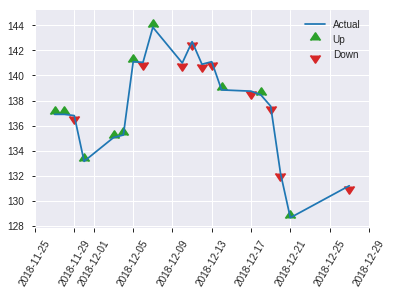


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20834458320034813
RMSE: 0.456447788033142
LogLoss: 0.6075433630850988
Null degrees of freedom: 244
Residual degrees of freedom: 194
Null deviance: 342.0840315976776
Residual deviance: 297.69624791169844
AIC: 399.69624791169844
AUC: 0.7380888829574269
pr_auc: 0.6859317578946612
Gini: 0.47617776591485383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38416589639292326: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   67   0.5276   (67.0/127.0)
1      16   102  0.1356   (16.0/118.0)
Total  76   169  0.3388   (83.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384166     0.710801  168
max f2                       0.118682     0.830966  231
max f0point5                 0.580915     0.702128  87
max accuracy                 0.580915     0.697959  87
max precision                0.802429     0.909091  10
max recall                   0.0668287    1         239
max specificity              0.906987     0.992126  0
max absolute_mcc             0.580915     0.40211   87
max min_per_class_accuracy   0.491215     0.692913  120
max mean_per_class_accuracy  0.480419     0.698452  123

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 47.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0122449                   0.861951           1.38418   1.38418            0.666667         0.891203  0.666667                    0.891203            0.0169492       0.0169492                  38.4181    38.4181
    2        0.0204082                   0.852635           2.07627   1.66102            1                0.856979  0.8                         0.877513            0.0169492       0.0338983                  107.627    66.1017
    3        0.0326531                   0.83462            2.07627   1.81674            1                0.848124  0.875                       0.866492            0.0254237       0.059322                   107.627    81.6737
    4        0.0408163                   0.802948           2.07627   1.86864            1                0.809416  0.9                         0.855077            0.0169492       0.0762712                  107.627    86.8644
    5        0.0530612                   0.790908           1.38418   1.75684            0.666667         0.79692   0.846154                    0.841656            0.0169492       0.0932203                  38.4181    75.6845
    6        0.102041                    0.756107           1.21116   1.49492            0.583333         0.769553  0.72                        0.807047            0.059322        0.152542                   21.1158    49.4915
    7        0.15102                     0.716372           1.73023   1.57123            0.833333         0.73892   0.756757                    0.784952            0.0847458       0.237288                   73.0226    57.1232
    8        0.2                         0.681606           1.21116   1.48305            0.583333         0.699893  0.714286                    0.764121            0.059322        0.29661                    21.1158    48.3051
    9        0.302041                    0.616922           1.57797   1.51512            0.76             0.650711  0.72973                     0.725807            0.161017        0.457627                   57.7966    51.5117
    10       0.4                         0.558385           1.47069   1.50424            0.708333         0.58702   0.72449                     0.691818            0.144068        0.601695                   47.0692    50.4237
    11       0.502041                    0.484474           0.99661   1.40106            0.48             0.516635  0.674797                    0.656212            0.101695        0.70339                    -0.338983  40.1061
    12       0.6                         0.427101           0.69209   1.28531            0.333333         0.451803  0.619048                    0.622839            0.0677966       0.771186                   -30.791    28.5311
    13       0.697959                    0.378088           0.951624  1.23848            0.458333         0.401864  0.596491                    0.591825            0.0932203       0.864407                   -4.83757   23.8478
    14       0.8                         0.279608           0.498305  1.14407            0.24             0.326713  0.55102                     0.55801             0.0508475       0.915254                   -50.1695   14.4068
    15       0.897959                    0.180451           0.519068  1.07589            0.25             0.220497  0.518182                    0.52119             0.0508475       0.966102                   -48.0932   7.5886
    16       1                           0.0280129          0.332203  1                  0.16             0.108324  0.481633                    0

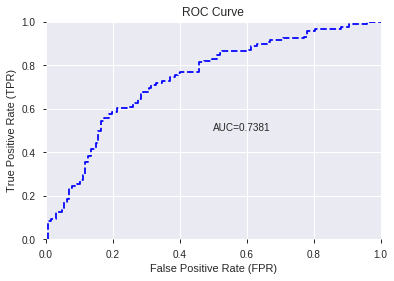

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


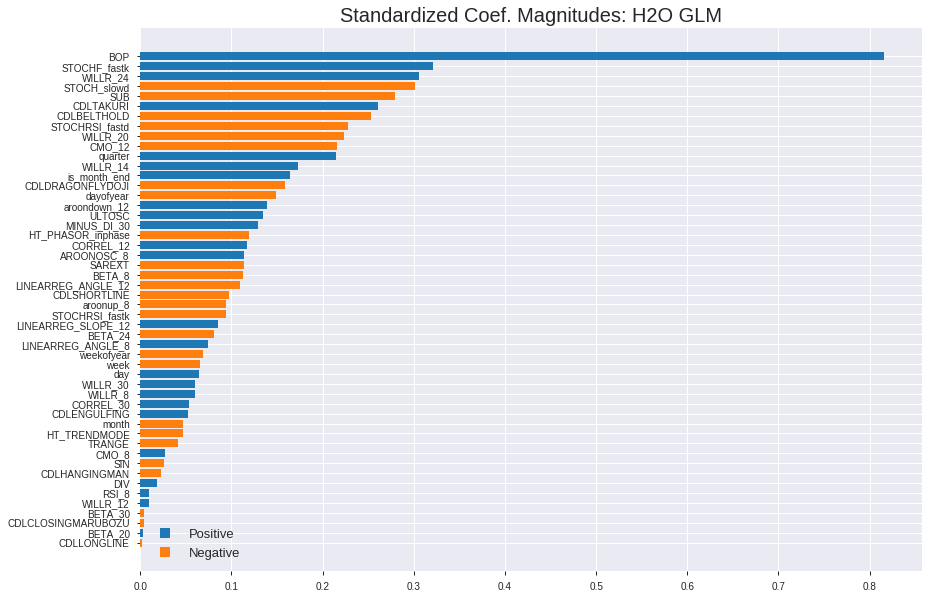

'log_likelihood'
--2019-08-24 21:06:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_210651_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_210651_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'WILLR_24',
 'STOCH_slowd',
 'SUB',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'STOCHRSI_fastd',
 'WILLR_20',
 'CMO_12',
 'quarter',
 'WILLR_14',
 'is_month_end',
 'CDLDRAGONFLYDOJI',
 'dayofyear',
 'aroondown_12',
 'ULTOSC',
 'MINUS_DI_30',
 'HT_PHASOR_inphase',
 'CORREL_12',
 'AROONOSC_8',
 'SAREXT',
 'BETA_8',
 'LINEARREG_ANGLE_12',
 'CDLSHORTLINE',
 'aroonup_8',
 'STOCHRSI_fastk',
 'LINEARREG_SLOPE_12',
 'BETA_24',
 'LINEARREG_ANGLE_8',
 'weekofyear',
 'week',
 'day',
 'WILLR_30',
 'WILLR_8',
 'CORREL_30',
 'CDLENGULFING',
 'month',
 'HT_TRENDMODE',
 'TRANGE',
 'CMO_8',
 'SIN',
 'CDLHANGINGMAN',
 'DIV',
 'RSI_8',
 'WILLR_12',
 'BETA_30',
 'CDLCLOSINGMARUBOZU',
 'BETA_20',
 'CDLLONGLINE']

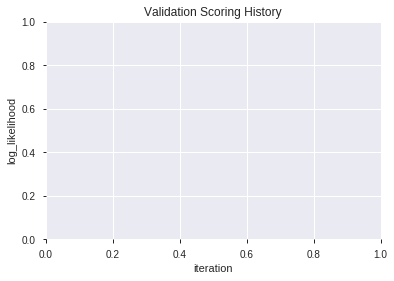

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_210701_model_4  0.706259  0.636635              0.344889  0.469950  0.220853
1  XGBoost_grid_1_AutoML_20190824_210701_model_3  0.702856  0.641642              0.373982  0.472208  0.222980
2  XGBoost_grid_1_AutoML_20190824_210701_model_6  0.699520  0.652279              0.342753  0.477089  0.227614
3               XGBoost_1_AutoML_20190824_210701  0.698919  0.653067              0.346090  0.476793  0.227331
4  XGBoost_grid_1_AutoML_20190824_210701_model_2  0.697785  0.644569              0.303984  0.474220  0.224884
5  XGBoost_grid_1_AutoML_20190824_210701_model_5  0.694315  0.672655              0.366409  0.481781  0.232113
6  XGBoost_grid_1_AutoML_20190824_210701_model_7  0.693514  0.655328              0.344588  0.477589  0.228091
7  XGBoost_grid_1_AutoML_20190824_210701_model_1  0.690845  0.649612              0.364574  0.476588  0.227136
8               XGBoost_2_AutoML_20190824_210701  0.689977  0.657219              0.404878  0.477946  0.228433
9               XGBoost_3_AutoML_20190824_210701  0.689243  0.656676              0.316996  0.478141  0.228619

variable  relative_importance  scaled_importance  percentage
0                  BOP          1823.540771           1.000000    0.354579
1         STOCHF_fastk           283.262146           0.155336    0.055079
2                  DIV           239.048096           0.131090    0.046482
3                  SUB           222.084686           0.121788    0.043183
4            CORREL_12           162.504959           0.089115    0.031598
5          STOCH_slowd           146.949188           0.080585    0.028574
6                  day           142.509857           0.078150    0.027710
7       STOCHRSI_fastd           137.689835           0.075507    0.026773
8          MINUS_DI_30           125.981834           0.069086    0.024497
9            dayofyear           123.654289           0.067810    0.024044
10                 SIN           122.732285           0.067304    0.023865
11              ULTOSC           117.839172           0.064621    0.022913
12              TRANGE           107.674957           0.059047    0.020937
13   HT_PHASOR_inphase           106.122284           0.058196    0.020635
14           CORREL_30           105.608734           0.057914    0.020535
15             BETA_24           102.401741           0.056155    0.019912
16             BETA_20            97.179146           0.053291    0.018896
17              SAREXT            95.731155           0.052497    0.018614
18             BETA_30            85.702339           0.046998    0.016664
19  LINEARREG_ANGLE_12            80.997574           0.044418    0.015750
20                week            80.557999           0.044177    0.015664
21      STOCHRSI_fastk            74.252480           0.040719    0.014438
22            WILLR_30            71.232437           0.039063    0.013851
23              BETA_8            68.577789           0.037607    0.013335
24            WILLR_12            58.795025           0.032242    0.011432
25        aroondown_12            51.215679           0.028086    0.009959
26           aroonup_8            46.018661           0.025236    0.008948
27               CMO_8            44.132370           0.024201    0.008581
28            WILLR_24            41.901802           0.022978    0.008148
29   LINEARREG_ANGLE_8            38.540947           0.021135    0.007494
30             WILLR_8            36.933998           0.020254    0.007182
31         CDLBELTHOLD            35.468781           0.019451    0.006897
32            WILLR_14            34.222248           0.018767    0.006654
33            WILLR_20            13.817746           0.007577    0.002687
34  CDLCLOSINGMARUBOZU             9.631767           0.005282    0.001873
35              CMO_12             8.320246           0.004563    0.001618

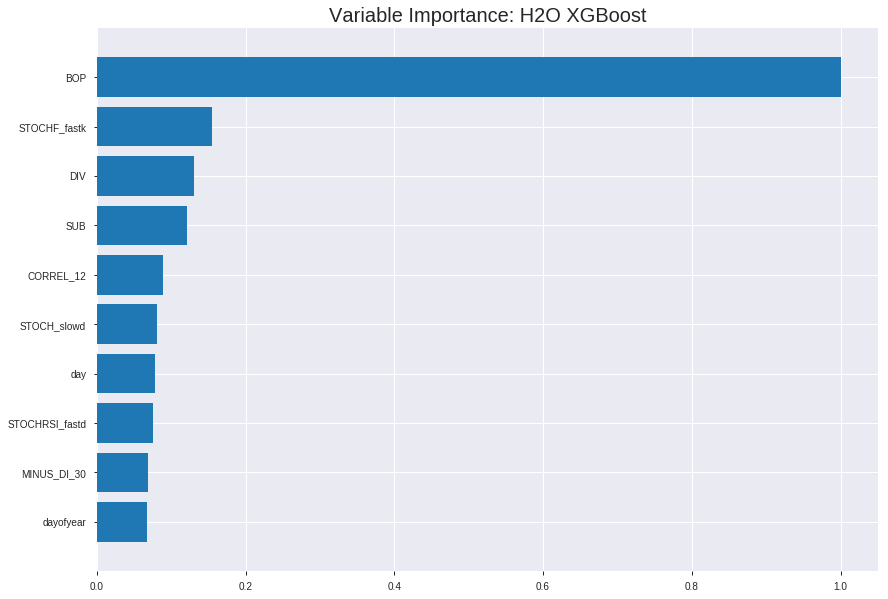

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_210701_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17611132335774818
RMSE: 0.4196561966154535
LogLoss: 0.531268315137531
Mean Per-Class Error: 0.250187412472197
AUC: 0.8247020622236868
pr_auc: 0.836626150204439
Gini: 0.6494041244473736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4322470873594284: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      445  351   0.441    (351.0/796.0)
1      103  812   0.1126   (103.0/915.0)
Total  548  1163  0.2653   (454.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432247     0.781521  247
max f2                       0.281995     0.878087  321
max f0point5                 0.610739     0.772347  147
max accuracy                 0.51742      0.753361  200
max precision                0.890927     1         0
max recall                   0.139855     1         390
max specificity              0.890927     1         0
max absolute_mcc             0.51742      0.503157  200
max min_per_class_accuracy   0.554338     0.741206  181
max mean_per_class_accuracy  0.543485     0.749813  187

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105202                   0.865182           1.86995    1.86995            1                0.874332  1                           0.874332            0.0196721       0.0196721                  86.9945    86.9945
    2        0.0204559                   0.851651           1.86995    1.86995            1                0.858199  1                           0.866496            0.0185792       0.0382514                  86.9945    86.9945
    3        0.0303916                   0.83929            1.64995    1.79802            0.882353         0.848     0.961538                    0.860449            0.0163934       0.0546448                  64.9952    79.8024
    4        0.0403273                   0.830248           1.86995    1.81574            1                0.835753  0.971014                    0.854365            0.0185792       0.073224                   86.9945    81.5744
    5        0.050263                    0.823271           1.75995    1.80471            0.941176         0.825623  0.965116                    0.848683            0.0174863       0.0907104                  75.9949    80.4715
    6        0.100526                    0.790217           1.71774    1.76123            0.918605         0.805537  0.94186                     0.82711             0.0863388       0.177049                   71.7741    76.1228
    7        0.150205                    0.76262            1.71595    1.74625            0.917647         0.77692   0.933852                    0.81051             0.0852459       0.262295                   71.595     74.6252
    8        0.200468                    0.733015           1.52205    1.69004            0.813953         0.748598  0.90379                     0.794987            0.0765027       0.338798                   52.2049    69.0038
    9        0.300409                    0.66975            1.37785    1.58618            0.736842         0.701883  0.848249                    0.764013            0.137705        0.476503                   37.7854    58.6179
    10       0.400351                    0.612765           1.39973    1.53963            0.748538         0.642537  0.823358                    0.733688            0.139891        0.616393                   39.9725    53.9634
    11       0.500292                    0.563225           1.10447    1.4527             0.590643         0.587485  0.776869                    0.704482            0.110383        0.726776                   10.4471    45.2703
    12       0.600234                    0.496855           0.995117   1.37651            0.532164         0.531006  0.736125                    0.675597            0.0994536       0.82623                    -0.488288  37.6513
    13       0.700175                    0.414928           0.667057   1.27525            0.356725         0.454999  0.68197                     0.64411             0.0666667       0.892896                   -33.2943   27.5247
    14       0.800117                    0.321514           0.677992   1.20064            0.362573         0.371506  0.642075                    0.610059            0.0677596       0.960656                   -32.2008   20.0644
    15       0.900058                    0.226433           0.30619    1.10132            0.163743         0.272892  0.588961                    0.57262             0.0306011       0.991257                   -69.381    10.1325
    16       1                           0.0941529          0.0874828  1                  0.0467836        0.178126  0.534775  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19254902301329838
RMSE: 0.438804082721775
LogLoss: 0.5700325981909995
Mean Per-Class Error: 0.2782670310760198
AUC: 0.7759979080203799
pr_auc: 0.7871763771958947
Gini: 0.5519958160407599
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4581304341554642: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  96   0.4324   (96.0/222.0)
1      37   230  0.1386   (37.0/267.0)
Total  163  326  0.272    (133.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45813      0.775717  255
max f2                       0.309869     0.873819  332
max f0point5                 0.560453     0.746677  198
max accuracy                 0.469721     0.728016  247
max precision                0.87285      1         0
max recall                   0.130969     1         398
max specificity              0.87285      1         0
max absolute_mcc             0.45813      0.453083  255
max min_per_class_accuracy   0.560453     0.715356  198
max mean_per_class_accuracy  0.530556     0.721733  215

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 53.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.843782           1.83146   1.83146            1                0.854829  1                           0.854829            0.0187266       0.0187266                  83.1461   83.1461
    2        0.0204499                   0.833703           1.46517   1.64831            0.8              0.839255  0.9                         0.847042            0.0149813       0.0337079                  46.5169   64.8315
    3        0.0306748                   0.827869           1.83146   1.70936            1                0.830916  0.933333                    0.841667            0.0187266       0.0524345                  83.1461   70.9363
    4        0.0408998                   0.81378            1.83146   1.73989            1                0.822689  0.95                        0.836922            0.0187266       0.071161                   83.1461   73.9888
    5        0.0511247                   0.797469           1.83146   1.7582             1                0.807114  0.96                        0.830961            0.0187266       0.0898876                  83.1461   75.8202
    6        0.100204                    0.769006           1.60253   1.68195            0.875            0.781516  0.918367                    0.806743            0.0786517       0.168539                   60.2528   68.1954
    7        0.151329                    0.744353           1.46517   1.60872            0.8              0.753428  0.878378                    0.788731            0.0749064       0.243446                   46.5169   60.8715
    8        0.200409                    0.716653           1.29728   1.53245            0.708333         0.731535  0.836735                    0.774724            0.0636704       0.307116                   29.7285   53.2447
    9        0.300613                    0.669542           1.19606   1.42032            0.653061         0.692741  0.77551                     0.747396            0.11985         0.426966                   19.6056   42.0316
    10       0.400818                    0.620662           1.27081   1.38294            0.693878         0.643304  0.755102                    0.721373            0.127341        0.554307                   27.0809   38.294
    11       0.501022                    0.568814           1.34556   1.37546            0.734694         0.594377  0.75102                     0.695974            0.134831        0.689139                   34.5563   37.5464
    12       0.599182                    0.50542            1.0302    1.3189             0.5625           0.539823  0.720137                    0.670393            0.101124        0.790262                   3.01966   31.8902
    13       0.699387                    0.439018           0.934419  1.26381            0.510204         0.469081  0.690058                    0.64155             0.093633        0.883895                   -6.55813  26.3815
    14       0.799591                    0.365867           0.598028  1.18038            0.326531         0.402196  0.644501                    0.611554            0.0599251       0.94382                    -40.1972  18.0379
    15       0.899796                    0.247443           0.373767  1.09055            0.204082         0.301957  0.595455                    0.577076            0.0374532       0.981273                   -62.6233  9.05516
    16       1                           0.125858           0.186884  1                  0.102041         0.199286  0.546012                    0.53922           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 21:07:08  2.431 sec   0                  0.5              0.693147            0.5             0                  1                0.465225                         0.5                0.693147              0.5               0                    1                  0.453988
    2019-08-24 21:07:08  2.483 sec   5                  0.480909         0.655503            0.768125        0.778153           1.69186          0.343074                         0.482811           0.659221              0.764627          0.784288             1.83146            0.300613
    2019-08-24 21:07:08  2.521 sec   10                 0.467514         0.629319            0.774087        0.788298           1.57469          0.303916                         0.471157           0.636458              0.768794          0.792306             1.83146            0.304703
    2019-08-24 21:07:08  2.562 sec   15                 0.457453         0.609434            0.780095        0.794569           1.86995          0.330216                         0.460376           0.61536               0.779844          0.797109             1.83146            0.278119
    2019-08-24 21:07:08  2.619 sec   20                 0.450489         0.595383            0.785227        0.80118            1.86995          0.32671                          0.452942           0.600633              0.782957          0.797069             1.83146            0.276074
    2019-08-24 21:07:08  2.680 sec   25                 0.445421         0.58499             0.790372        0.803777           1.86995          0.324956                         0.448484           0.591627              0.784172          0.799102             1.83146            0.276074
    2019-08-24 21:07:08  2.752 sec   30                 0.440727         0.575178            0.795338        0.809256           1.76606          0.322618                         0.445327           0.585021              0.784138          0.801662             1.83146            0.271984
    2019-08-24 21:07:08  2.823 sec   35                 0.437854         0.569027            0.797349        0.814533           1.86995          0.316774                         0.443418           0.58098               0.7817            0.797621             1.83146            0.276074
    2019-08-24 21:07:08  2.880 sec   40                 0.434232         0.561354            0.801898        0.817708           1.86995          0.310929                         0.440974           0.575724              0.782982          0.798981             1.83146            0.267894
    2019-08-24 21:07:08  2.930 sec   45                 0.431009         0.554628            0.806754        0.822799           1.86995          0.268264                         0.439978           0.57341               0.781962          0.796925             1.83146            0.263804
    2019-08-24 21:07:08  2.991 sec   50                 0.428479         0.549391            0.81099         0.825364           1.86995          0.274109                         0.440377           0.573876              0.7782            0.791887             1.83146            0.261759
    2019-08-24 21:07:08  3.048 sec   55                 0.42619          0.544744            0.814685        0.829348           1.86995          0.258328                         0.440005           0.572996              0.778554          0

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1823.540771484375      1.0                    0.35457889718003327
STOCHF_fastk        283.26214599609375     0.15533633819742695    0.055078987490028326
DIV                 239.048095703125       0.13109007456331134    0.046481774069907264
SUB                 222.08468627929688     0.12178761766786184    0.043183319162853985
CORREL_12           162.5049591064453      0.08911506759136793    0.031598322388671364
---                 ---                    ---                    ---
CDLBELTHOLD         35.468780517578125     0.019450500406802688   0.006896736983843886
WILLR_14            34.22224807739258      0.018766922359260127   0.006654354633609764
WILLR_20            13.81774616241455      0.007577426498211394   0.0026867955311985574
CDLCLOSINGMARUBOZU  9.631767272949219      0.005281903987871295   0.0018728516910302237
CMO_12              8.320245742797852      0.0045626869839741025  0.0016178325189552295


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6653061224489796)

('F1', 0.6928571428571428)

('auc', 0.7062591752302149)

('logloss', 0.6366345705774713)

('mean_per_class_error', 0.33547978112905374)

('rmse', 0.46994965228986935)

('mse', 0.2208526756873691)

xgboost prediction progress: |████████████████████████████████████████████| 100%


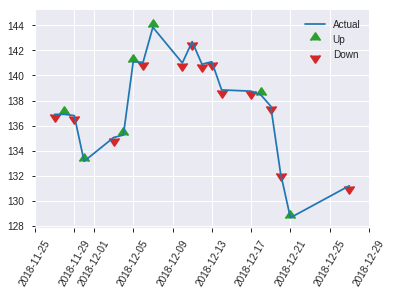


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2208526756873691
RMSE: 0.46994965228986935
LogLoss: 0.6366345705774713
Mean Per-Class Error: 0.33547978112905374
AUC: 0.7062591752302149
pr_auc: 0.6631524060578113
Gini: 0.41251835046042973
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3849638104438782: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   65   0.5118   (65.0/127.0)
1      21   97   0.178    (21.0/118.0)
Total  83   162  0.351    (86.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384964     0.692857  161
max f2                       0.114833     0.822873  244
max f0point5                 0.673278     0.668449  63
max accuracy                 0.673278     0.665306  63
max precision                0.719305     0.813953  42
max recall                   0.114833     1         244
max specificity              0.889584     0.992126  0
max absolute_mcc             0.673278     0.356567  63
max min_per_class_accuracy   0.532711     0.653543  121
max mean_per_class_accuracy  0.461848     0.66452   142

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.843248           1.38418   1.38418            0.666667         0.864106  0.666667                    0.864106            0.0169492       0.0169492                  38.4181   38.4181
    2        0.0204082                   0.815695           1.03814   1.24576            0.5              0.832712  0.6                         0.851548            0.00847458      0.0254237                  3.81356   24.5763
    3        0.0326531                   0.799521           1.38418   1.29767            0.666667         0.80711   0.625                       0.834884            0.0169492       0.0423729                  38.4181   29.7669
    4        0.0408163                   0.795111           2.07627   1.45339            1                0.797692  0.7                         0.827446            0.0169492       0.059322                   107.627   45.339
    5        0.0530612                   0.782923           2.07627   1.59713            1                0.789004  0.769231                    0.818574            0.0254237       0.0847458                  107.627   59.7132
    6        0.102041                    0.759908           1.5572    1.57797            0.75             0.773865  0.76                        0.797114            0.0762712       0.161017                   55.7203   57.7966
    7        0.15102                     0.728504           1.73023   1.62735            0.833333         0.745881  0.783784                    0.780498            0.0847458       0.245763                   73.0226   62.7348
    8        0.2                         0.696475           1.73023   1.65254            0.833333         0.717449  0.795918                    0.765057            0.0847458       0.330508                   73.0226   65.2542
    9        0.302041                    0.649839           1.16271   1.48706            0.56             0.674812  0.716216                    0.734569            0.118644        0.449153                   16.2712   48.7059
    10       0.4                         0.608667           0.951624  1.35593            0.458333         0.627097  0.653061                    0.708249            0.0932203       0.542373                   -4.83757  35.5932
    11       0.502041                    0.530536           1.16271   1.31666            0.56             0.572188  0.634146                    0.680595            0.118644        0.661017                   16.2712   31.666
    12       0.6                         0.443754           0.951624  1.25706            0.458333         0.481478  0.605442                    0.648086            0.0932203       0.754237                   -4.83757  25.7062
    13       0.697959                    0.356021           0.865113  1.20205            0.416667         0.387191  0.578947                    0.611469            0.0847458       0.838983                   -13.4887  20.2052
    14       0.8                         0.292593           0.664407  1.13347            0.32             0.32544   0.545918                    0.574986            0.0677966       0.90678                    -33.5593  13.3475
    15       0.897959                    0.214972           0.259534  1.03814            0.125            0.256537  0.5                         0.540246            0.0254237       0.932203                   -74.0466  3.81356
    16       1                           0.114833           0.664407  1                  0.32             0.166864  0.481633                    0.502146           

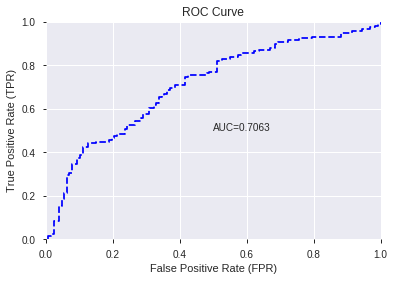

This function is available for GLM models only


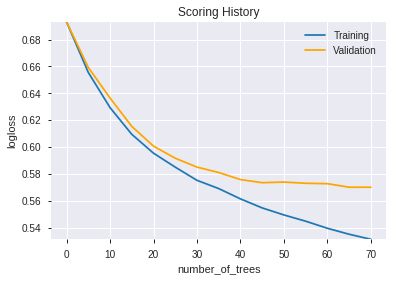

--2019-08-24 21:07:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_210701_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_210701_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'SUB',
 'CORREL_12',
 'STOCH_slowd',
 'day',
 'STOCHRSI_fastd',
 'MINUS_DI_30',
 'dayofyear',
 'SIN',
 'ULTOSC',
 'TRANGE',
 'HT_PHASOR_inphase',
 'CORREL_30',
 'BETA_24',
 'BETA_20',
 'SAREXT',
 'BETA_30',
 'LINEARREG_ANGLE_12',
 'week',
 'STOCHRSI_fastk',
 'WILLR_30',
 'BETA_8',
 'WILLR_12',
 'aroondown_12',
 'aroonup_8',
 'CMO_8',
 'WILLR_24',
 'LINEARREG_ANGLE_8',
 'WILLR_8',
 'CDLBELTHOLD',
 'WILLR_14',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'CMO_12']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

23

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_210725_model_6  0.724343  0.630959              0.341886  0.465514  0.216703
1  DeepLearning_grid_1_AutoML_20190824_210725_model_8  0.719004  0.634838              0.323702  0.467909  0.218939
2  DeepLearning_grid_1_AutoML_20190824_210725_model_9  0.716936  0.635480              0.310056  0.470263  0.221147
3               DeepLearning_1_AutoML_20190824_210725  0.709329  0.664329              0.303984  0.481541  0.231882
4  DeepLearning_grid_1_AutoML_20190824_210725_model_5  0.702589  0.670310              0.320666  0.476885  0.227419
5  DeepLearning_grid_1_AutoML_20190824_210725_model_7  0.696383  0.695193              0.353397  0.484306  0.234552
6  DeepLearning_grid_1_AutoML_20190824_210725_model_4  0.693247  0.651038              0.349159  0.474528  0.225176
7  DeepLearning_grid_1_AutoML_20190824_210725_model_3  0.661551  0.709207              0.368844  0.493865  0.243903
8  DeepLearning_grid_1_AutoML_20190824_210725_model_1  0.647338  0.959808              0.381556  0.541343  0.293052
9  DeepLearning_grid_1_AutoML_20190824_210725_model_2  0.610303  0.764326              0.401541  0.516008  0.266265

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.090838
1   CDLCLOSINGMARUBOZU             0.978369           0.978369    0.088873
2         CDLSHORTLINE             0.862674           0.862674    0.078363
3                  SUB             0.809911           0.809911    0.073570
4          CDLLONGLINE             0.751660           0.751660    0.068279
5         CDLENGULFING             0.655577           0.655577    0.059551
6               TRANGE             0.529834           0.529834    0.048129
7       STOCHRSI_fastk             0.474762           0.474762    0.043126
8          CDLBELTHOLD             0.425272           0.425272    0.038631
9                CCI_8             0.403046           0.403046    0.036612
10        STOCHF_fastk             0.389504           0.389504    0.035382
11         CDLMARUBOZU             0.372176           0.372176    0.033808
12            WILLR_30             0.349475           0.349475    0.031746
13              ULTOSC             0.336253           0.336253    0.030544
14            WILLR_24             0.334623           0.334623    0.030396
15              RSI_12             0.311081           0.311081    0.028258
16              CMO_12             0.308857           0.308857    0.028056
17             WILLR_8             0.295886           0.295886    0.026878
18            WILLR_14             0.291206           0.291206    0.026453
19               RSI_8             0.287696           0.287696    0.026134
20            WILLR_20             0.283002           0.283002    0.025707
21            WILLR_12             0.279175           0.279175    0.025360
22               CMO_8             0.278607           0.278607    0.025308

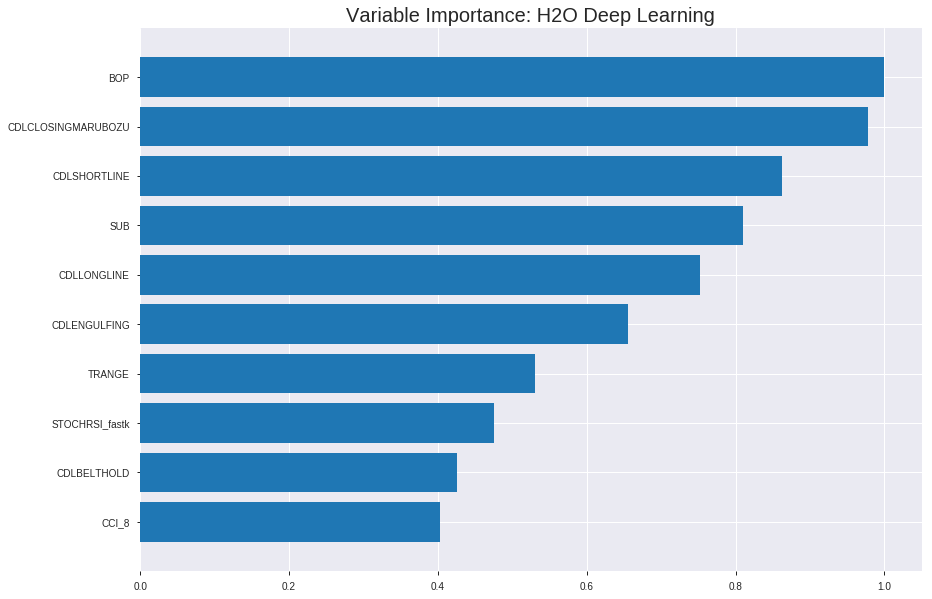

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_210725_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20071880779783124
RMSE: 0.4480165262552613
LogLoss: 0.5846345845738442
Mean Per-Class Error: 0.3110319356344564
AUC: 0.7594701650328144
pr_auc: 0.7749643941204915
Gini: 0.5189403300656288
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5065678611822991: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      387  409   0.5138   (409.0/796.0)
1      134  781   0.1464   (134.0/915.0)
Total  521  1190  0.3174   (543.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506568     0.742043  233
max f2                       0.14235      0.859699  372
max f0point5                 0.574974     0.714457  183
max accuracy                 0.535327     0.694915  214
max precision                0.981879     1         0
max recall                   0.102537     1         387
max specificity              0.981879     1         0
max absolute_mcc             0.535327     0.385967  214
max min_per_class_accuracy   0.563003     0.685246  191
max mean_per_class_accuracy  0.57339      0.688968  184

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 56.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105202                   0.93482            1.76606   1.76606            0.944444         0.95333   0.944444                    0.95333             0.0185792       0.0185792                  76.606     76.606
    2        0.0204559                   0.908144           1.53995   1.65624            0.823529         0.922134  0.885714                    0.938178            0.0153005       0.0338798                  53.9955    65.6237
    3        0.0303916                   0.887444           1.75995   1.69014            0.941176         0.896292  0.903846                    0.924485            0.0174863       0.0513661                  75.9949    69.0143
    4        0.0403273                   0.869707           1.75995   1.70734            0.941176         0.876734  0.913043                    0.91272             0.0174863       0.0688525                  75.9949    70.7341
    5        0.050263                    0.860296           1.64995   1.696              0.882353         0.864947  0.906977                    0.903276            0.0163934       0.0852459                  64.9952    69.5997
    6        0.100526                    0.821107           1.63077   1.66338            0.872093         0.839645  0.889535                    0.871461            0.0819672       0.167213                   63.0766    66.3382
    7        0.150205                    0.788302           1.53995   1.62256            0.823529         0.803082  0.867704                    0.848845            0.0765027       0.243716                   53.9955    62.256
    8        0.200468                    0.756867           1.45682   1.581              0.77907          0.774291  0.845481                    0.830152            0.073224        0.31694                    45.6818    58.1003
    9        0.300409                    0.676554           1.27944   1.48068            0.684211         0.713864  0.791829                    0.791465            0.127869        0.444809                   27.9436    48.0677
    10       0.400351                    0.608492           1.20289   1.41133            0.643275         0.64325   0.754745                    0.754465            0.120219        0.565027                   20.2889    41.1331
    11       0.500292                    0.56638            1.10447   1.35003            0.590643         0.58593   0.721963                    0.720798            0.110383        0.67541                    10.4471    35.0031
    12       0.600234                    0.541693           0.995117  1.29094            0.532164         0.551498  0.69036                     0.692609            0.0994536       0.774863                   -0.488288  29.0936
    13       0.700175                    0.503283           0.809216  1.22218            0.432749         0.526494  0.653589                    0.668898            0.0808743       0.855738                   -19.0784   22.2176
    14       0.800117                    0.415401           0.667057  1.15284            0.356725         0.464313  0.616508                    0.643343            0.0666667       0.922404                   -33.2943   15.2837
    15       0.900058                    0.265962           0.481156  1.07825            0.25731          0.34282   0.576623                    0.609973            0.0480874       0.970492                   -51.8844   7.82542
    16       1                           0.0129695          0.295255  1                  0.157895         0.169063  0.534775                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1947712728208943
RMSE: 0.4413289847958032
LogLoss: 0.5745147141898724
Mean Per-Class Error: 0.27560987954246374
AUC: 0.7772969598812295
pr_auc: 0.7854105652030163
Gini: 0.554593919762459
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5189249947395611: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  92   0.4144   (92.0/222.0)
1      41   226  0.1536   (41.0/267.0)
Total  171  318  0.272    (133.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518925     0.77265   247
max f2                       0.191998     0.866271  366
max f0point5                 0.556944     0.752143  210
max accuracy                 0.524776     0.728016  245
max precision                0.846986     0.904762  39
max recall                   0.104227     1         391
max specificity              0.975453     0.995495  0
max absolute_mcc             0.518925     0.451058  247
max min_per_class_accuracy   0.556944     0.722846  210
max mean_per_class_accuracy  0.550806     0.72439   215

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 56.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.933117           1.46517   1.46517            0.8              0.962881  0.8                         0.962881            0.0149813       0.0149813                  46.5169   46.5169
    2        0.0204499                   0.919255           1.46517   1.46517            0.8              0.928754  0.8                         0.945817            0.0149813       0.0299625                  46.5169   46.5169
    3        0.0306748                   0.899156           1.83146   1.58727            1                0.912223  0.866667                    0.934619            0.0187266       0.0486891                  83.1461   58.7266
    4        0.0408998                   0.890984           1.46517   1.55674            0.8              0.895831  0.85                        0.924922            0.0149813       0.0636704                  46.5169   55.6742
    5        0.0511247                   0.878998           1.83146   1.61169            1                0.885587  0.88                        0.917055            0.0187266       0.082397                   83.1461   61.1685
    6        0.100204                    0.839276           1.60253   1.6072             0.875            0.856825  0.877551                    0.887555            0.0786517       0.161049                   60.2528   60.72
    7        0.151329                    0.808936           1.61169   1.60872            0.88             0.825658  0.878378                    0.866644            0.082397        0.243446                   61.1685   60.8715
    8        0.200409                    0.774895           1.52622   1.58851            0.833333         0.793547  0.867347                    0.848743            0.0749064       0.318352                   52.6217   58.8512
    9        0.300613                    0.684725           1.42032   1.53245            0.77551          0.734261  0.836735                    0.810582            0.142322        0.460674                   42.0316   53.2447
    10       0.400818                    0.604277           1.15868   1.439              0.632653         0.640229  0.785714                    0.767994            0.116105        0.576779                   15.8679   43.9005
    11       0.501022                    0.562576           1.19606   1.39042            0.653061         0.581098  0.759184                    0.730614            0.11985         0.696629                   19.6056   39.0415
    12       0.599182                    0.538746           0.953886  1.3189             0.520833         0.548915  0.720137                    0.700848            0.093633        0.790262                   -4.61142  31.8902
    13       0.699387                    0.480882           0.710158  1.23168            0.387755         0.514581  0.672515                    0.674161            0.071161        0.861423                   -28.9842  23.1684
    14       0.799591                    0.380388           0.523274  1.14291            0.285714         0.437359  0.624041                    0.644485            0.0524345       0.913858                   -47.6726  14.2906
    15       0.899796                    0.219956           0.560651  1.07806            0.306122         0.312332  0.588636                    0.607495            0.0561798       0.970037                   -43.9349  7.80644
    16       1                           0.0326638          0.299014  1                  0.163265         0.144867  0.546012                    0.561138           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 21:11:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 21:11:07  1 min 53.846 sec  1078 obs/sec      1.41087   1             2414       0.486425         0.668365            0.0489616      0.673431        0.676273           1.4544           0.414962                         0.474993           0.643388              0.0898189        0.699717          0.71244              1.83146            0.353783
    2019-08-24 21:11:14  2 min  0.301 sec  2433 obs/sec      11.4091   8             19521      0.458326         0.606758            0.155664       0.734067        0.750201           1.76606          0.331385                         0.450332           0.596617              0.181875         0.765859          0.785672             1.83146            0.308793
    2019-08-24 21:11:21  2 min  7.355 sec  3023 obs/sec      25.5535   18            43722      0.45443          0.598701            0.169958       0.743759        0.760095           1.76606          0.324372                         0.446574           0.587645              0.195473         0.779406          0.780934             1.46517            0.271984
    2019-08-24 21:11:27  2 min 13.778 sec  3234 obs/sec      38.3431   27            65605      0.453529         0.596524            0.173247       0.745256        0.762534           1.76606          0.322618                         0.446543           0.585025              0.195586         0.769646          0.783986             1.46517            0.290389
    2019-08-24 21:11:33  2 min 20.035 sec  3377 obs/sec      51.1444   36            87508      0.450504         0.589983            0.184238       0.7492          0.766215           1.76606          0.313267                         0.442458           0.577294              0.210235         0.775475          0.783212             1.46517            0.278119
    2019-08-24 21:11:40  2 min 26.841 sec  3479 obs/sec      65.315    46            111754     0.449202         0.586987            0.188946       0.754251        0.77035            1.76606          0.335476                         0.443765           0.581586              0.205562         0.778006          0.785937             1.46517            0.271984
    2019-08-24 21:11:46  2 min 32.923 sec  3555 obs/sec      78.1116   55            133649     0.448017         0.584635            0.193222       0.75947         0.774964           1.76606          0.317358                         0.441329           0.574515              0.214261         0.777297          0.785411             1.46517            0.271984

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.09083769312686449
CDLCLOSINGMARUBOZU  0.9783685803413391     0.9783685803413391   0.08887274486601263
CDLSHORTLINE        0.8626742959022522     0.8626742959022522   0.07836334295960268
SUB                 0.8099113702774048     0.8099113702774048   0.07357048051321721
CDLLONGLINE         0.7516601085662842     0.7516601085662842   0.06827907027764976
---                 ---                    ---                  ---
WILLR_14            0.2912064492702484     0.2912064492702484   0.026452522075374654
RSI_8               0.28769561648368835    0.28769561648368835  0.026133606124089378
WILLR_20            0.2830016314983368     0.2830016314983368   0.025707215356447904
WILLR_12            0.27917513251304626    0.27917513251304626  0.025359625015871825
CMO_8               0.27860745787620544    0.27860745787620544  0.025308058761414575


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6857142857142857)

('F1', 0.7133333333333334)

('auc', 0.7243427198718805)

('logloss', 0.6309586096591986)

('mean_per_class_error', 0.3100560523154945)

('rmse', 0.4655136655531762)

('mse', 0.21670297281675438)

deeplearning prediction progress: |███████████████████████████████████████| 100%


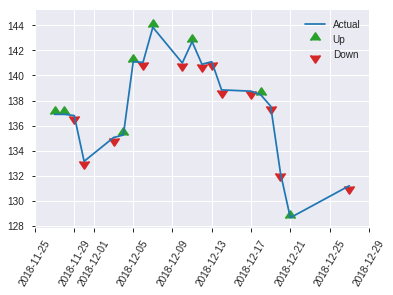


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21670297281675438
RMSE: 0.4655136655531762
LogLoss: 0.6309586096591986
Mean Per-Class Error: 0.3100560523154945
AUC: 0.7243427198718805
pr_auc: 0.6703097771814746
Gini: 0.44868543974376096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37384525291385756: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   75   0.5906   (75.0/127.0)
1      11   107  0.0932   (11.0/118.0)
Total  63   182  0.351    (86.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373845     0.713333  179
max f2                       0.102876     0.830986  235
max f0point5                 0.590211     0.667331  95
max accuracy                 0.496998     0.685714  146
max precision                0.972328     1         0
max recall                   0.102876     1         235
max specificity              0.972328     1         0
max absolute_mcc             0.496998     0.388839  146
max min_per_class_accuracy   0.543929     0.661417  119
max mean_per_class_accuracy  0.496998     0.689944  146

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 53.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0122449                   0.962182           1.38418   1.38418            0.666667         0.968393  0.666667                    0.968393            0.0169492       0.0169492                  38.4181    38.4181
    2        0.0204082                   0.936175           2.07627   1.66102            1                0.9526    0.8                         0.962076            0.0169492       0.0338983                  107.627    66.1017
    3        0.0326531                   0.913682           1.38418   1.5572             0.666667         0.920986  0.75                        0.946667            0.0169492       0.0508475                  38.4181    55.7203
    4        0.0408163                   0.899083           2.07627   1.66102            1                0.911589  0.8                         0.939651            0.0169492       0.0677966                  107.627    66.1017
    5        0.0530612                   0.878532           1.38418   1.59713            0.666667         0.889571  0.769231                    0.928095            0.0169492       0.0847458                  38.4181    59.7132
    6        0.102041                    0.826897           1.73023   1.66102            0.833333         0.8556    0.8                         0.893297            0.0847458       0.169492                   73.0226    66.1017
    7        0.15102                     0.796258           1.21116   1.51512            0.583333         0.816302  0.72973                     0.868326            0.059322        0.228814                   21.1158    51.5117
    8        0.2                         0.754579           1.5572    1.52542            0.75             0.770961  0.734694                    0.844481            0.0762712       0.305085                   55.7203    52.5424
    9        0.302041                    0.665236           1.16271   1.40289            0.56             0.709568  0.675676                    0.798903            0.118644        0.423729                   16.2712    40.2886
    10       0.4                         0.586512           1.47069   1.41949            0.708333         0.618479  0.683673                    0.754717            0.144068        0.567797                   47.0692    41.9492
    11       0.502041                    0.539775           0.99661   1.33354            0.48             0.562729  0.642276                    0.715695            0.101695        0.669492                   -0.338983  33.354
    12       0.6                         0.498409           1.21116   1.31356            0.583333         0.520592  0.632653                    0.683842            0.118644        0.788136                   21.1158    31.3559
    13       0.697959                    0.436451           0.778602  1.23848            0.375            0.467673  0.596491                    0.653502            0.0762712       0.864407                   -22.1398   23.8478
    14       0.8                         0.32506            0.581356  1.15466            0.28             0.375989  0.556122                    0.618105            0.059322        0.923729                   -41.8644   15.4661
    15       0.897959                    0.184209           0.259534  1.05701            0.125            0.236601  0.509091                    0.576486            0.0254237       0.949153                   -74.0466   5.70108
    16       1                           0.0683661          0.498305  1                  0.24             0.126357  0.481633                    0

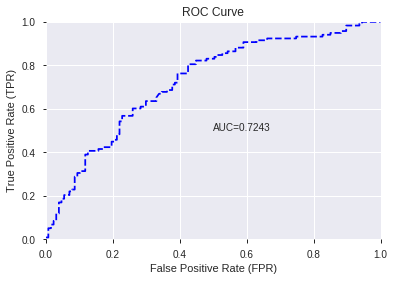

This function is available for GLM models only


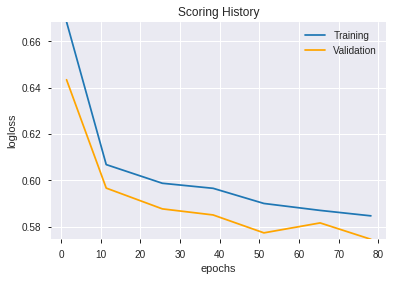

--2019-08-24 21:15:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_210725_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_210725_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'SUB',
 'CDLLONGLINE',
 'CDLENGULFING',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'CCI_8',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'WILLR_30',
 'ULTOSC',
 'WILLR_24',
 'RSI_12',
 'CMO_12',
 'WILLR_8',
 'WILLR_14',
 'RSI_8',
 'WILLR_20',
 'WILLR_12',
 'CMO_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_211546_model_1  0.743627  0.591776              0.307053  0.451757  0.204085

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.839836           1.000000    0.169145
1         STOCHF_fastk             0.381287           0.454002    0.076792
2             WILLR_24             0.374420           0.445825    0.075409
3                CCI_8             0.373511           0.444743    0.075226
4             WILLR_20             0.335540           0.399530    0.067579
5                  SUB             0.318973           0.379804    0.064242
6          CDLMARUBOZU             0.314926           0.374986    0.063427
7               CMO_12             0.272889           0.324931    0.054961
8               RSI_12             0.245574           0.292407    0.049459
9              WILLR_8             0.227215           0.270547    0.045762
10  CDLCLOSINGMARUBOZU             0.209423           0.249362    0.042178
11            WILLR_30             0.176362           0.209995    0.035520
12            WILLR_12             0.173996           0.207179    0.035043
13               CMO_8             0.162668           0.193690    0.032762
14               RSI_8             0.128752           0.153307    0.025931
15         CDLBELTHOLD             0.107658           0.128190    0.021683
16        CDLSHORTLINE             0.099909           0.118963    0.020122
17      STOCHRSI_fastk             0.061017           0.072654    0.012289
18              ULTOSC             0.044982           0.053561    0.009060
19            WILLR_14             0.043450           0.051737    0.008751
20        CDLENGULFING             0.037842           0.045059    0.007622
21              TRANGE             0.030326           0.036110    0.006108
22         CDLLONGLINE             0.004622           0.005503    0.000931

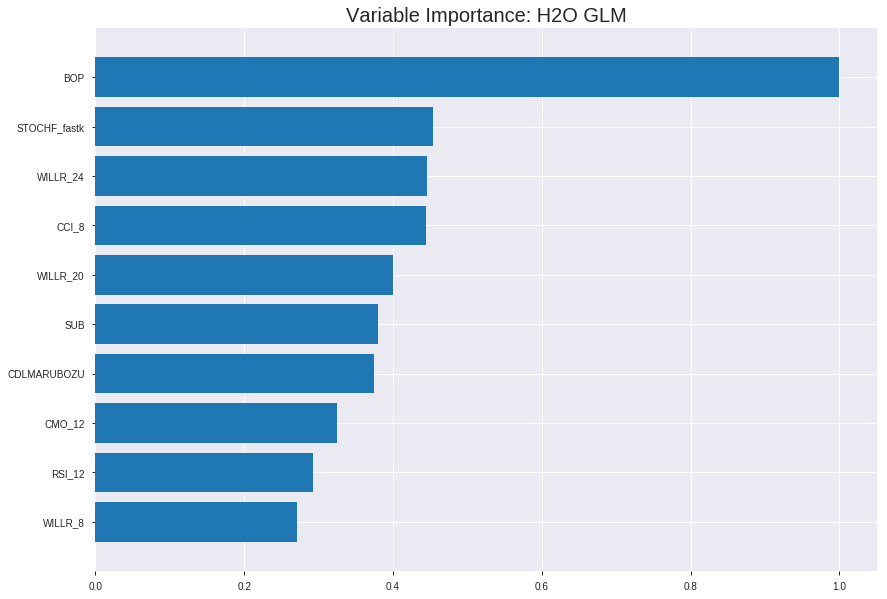

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_211546_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2057637139809793
RMSE: 0.45361185388058295
LogLoss: 0.5976417126473709
Null degrees of freedom: 1710
Residual degrees of freedom: 1687
Null deviance: 2363.666519940619
Residual deviance: 2045.1299406793032
AIC: 2093.129940679303
AUC: 0.739079962654804
pr_auc: 0.7585880993053931
Gini: 0.47815992530960805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3756486922587903: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      335  461   0.5791   (461.0/796.0)
1      120  795   0.1311   (120.0/915.0)
Total  455  1256  0.3396   (581.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375649     0.732381  276
max f2                       0.135615     0.855349  385
max f0point5                 0.558179     0.70815   184
max accuracy                 0.50847      0.686148  211
max precision                0.939954     1         0
max recall                   0.109617     1         393
max specificity              0.939954     1         0
max absolute_mcc             0.50847      0.366829  211
max min_per_class_accuracy   0.550053     0.679648  188
max mean_per_class_accuracy  0.558179     0.683836  184

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.901406           1.86995   1.86995            1                0.911003  1                           0.911003            0.0196721       0.0196721                  86.9945   86.9945
    2        0.0204559                   0.881849           1.86995   1.86995            1                0.8905    1                           0.901044            0.0185792       0.0382514                  86.9945   86.9945
    3        0.0303916                   0.863246           1.75995   1.83398            0.941176         0.873293  0.980769                    0.891972            0.0174863       0.0557377                  75.9949   83.3985
    4        0.0403273                   0.849403           1.86995   1.84284            1                0.855748  0.985507                    0.883047            0.0185792       0.0743169                  86.9945   84.2845
    5        0.050263                    0.838818           1.31996   1.73948            0.705882         0.843674  0.930233                    0.875264            0.0131148       0.0874317                  31.9961   73.9484
    6        0.100526                    0.794397           1.54379   1.64164            0.825581         0.812921  0.877907                    0.844093            0.0775956       0.165027                   54.3792   64.1638
    7        0.150205                    0.761081           1.27596   1.52069            0.682353         0.777123  0.81323                     0.821943            0.063388        0.228415                   27.5963   52.0695
    8        0.200468                    0.732614           1.39159   1.48832            0.744186         0.746001  0.795918                    0.802902            0.0699454       0.298361                   39.1587   48.8324
    9        0.300409                    0.67908            1.31224   1.42974            0.701754         0.705658  0.764591                    0.770551            0.131148        0.429508                   31.2242   42.9744
    10       0.400351                    0.620517           1.30131   1.39768            0.695906         0.649098  0.747445                    0.740232            0.130055        0.559563                   30.1307   39.7682
    11       0.500292                    0.55265            1.0826    1.33474            0.578947         0.584969  0.713785                    0.709215            0.108197        0.66776                    8.25999   33.4739
    12       0.600234                    0.489812           0.94044   1.26909            0.502924         0.52405   0.678676                    0.678385            0.0939891       0.761749                   -5.95596  26.9087
    13       0.700175                    0.398357           0.798281  1.20188            0.426901         0.444159  0.642738                    0.644952            0.0797814       0.84153                    -20.1719  20.1885
    14       0.800117                    0.327371           0.688927  1.13781            0.368421         0.362023  0.608473                    0.609611            0.0688525       0.910383                   -31.1073  13.7812
    15       0.900058                    0.249236           0.568638  1.07461            0.304094         0.289803  0.574675                    0.5741              0.0568306       0.967213                   -43.1362  7.46115
    16       1                           0.0669473          0.328061  1                  0.175439         0.180604  0.534775                    0.534774         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.194839532361848
RMSE: 0.44140631210014203
LogLoss: 0.5744586052009517
Null degrees of freedom: 488
Residual degrees of freedom: 465
Null deviance: 673.9994524945296
Residual deviance: 561.8205158865308
AIC: 609.8205158865308
AUC: 0.7688109457772379
pr_auc: 0.7799374881491433
Gini: 0.5376218915544757
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3945467636373737: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  110  0.4955   (110.0/222.0)
1      29   238  0.1086   (29.0/267.0)
Total  141  348  0.2843   (139.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394547     0.773984  279
max f2                       0.123676     0.863519  388
max f0point5                 0.561727     0.74477   189
max accuracy                 0.419528     0.723926  264
max precision                0.923238     1         0
max recall                   0.123676     1         388
max specificity              0.923238     1         0
max absolute_mcc             0.419528     0.445575  264
max min_per_class_accuracy   0.54045      0.700375  203
max mean_per_class_accuracy  0.511118     0.713837  227

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 52.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.899575           1.83146   1.83146            1                0.909376  1                           0.909376            0.0187266       0.0187266                  83.1461   83.1461
    2        0.0204499                   0.858159           1.83146   1.83146            1                0.874971  1                           0.892173            0.0187266       0.0374532                  83.1461   83.1461
    3        0.0306748                   0.835954           1.83146   1.83146            1                0.847337  1                           0.877228            0.0187266       0.0561798                  83.1461   83.1461
    4        0.0408998                   0.827216           1.46517   1.73989            0.8              0.832223  0.95                        0.865977            0.0149813       0.071161                   46.5169   73.9888
    5        0.0511247                   0.812183           1.09888   1.61169            0.6              0.82064   0.88                        0.856909            0.011236        0.082397                   9.88764   61.1685
    6        0.100204                    0.774136           1.52622   1.56982            0.833333         0.78868   0.857143                    0.823491            0.0749064       0.157303                   52.6217   56.9823
    7        0.151329                    0.747661           1.53843   1.55922            0.84             0.76145   0.851351                    0.802531            0.0786517       0.235955                   53.8427   55.9217
    8        0.200409                    0.720824           1.3736    1.51376            0.75             0.730574  0.826531                    0.784909            0.0674157       0.303371                   37.3596   51.3758
    9        0.300613                    0.664892           1.19606   1.40786            0.653061         0.692372  0.768707                    0.754063            0.11985         0.423221                   19.6056   40.7858
    10       0.400818                    0.60365            1.53245   1.439              0.836735         0.635743  0.785714                    0.724483            0.153558        0.576779                   53.2447   43.9005
    11       0.501022                    0.551819           1.08393   1.36799            0.591837         0.573512  0.746939                    0.694289            0.108614        0.685393                   8.39257   36.7989
    12       0.599182                    0.497494           1.0302    1.31265            0.5625           0.526266  0.716724                    0.666763            0.101124        0.786517                   3.01966   31.2651
    13       0.699387                    0.396755           0.897042  1.2531             0.489796         0.449539  0.684211                    0.63564             0.0898876       0.876404                   -10.2958  25.3105
    14       0.799591                    0.323333           0.598028  1.17101            0.326531         0.366205  0.639386                    0.601875            0.0599251       0.93633                    -40.1972  17.1011
    15       0.899796                    0.229297           0.261637  1.06974            0.142857         0.280117  0.584091                    0.566043            0.0262172       0.962547                   -73.8363  6.97395
    16       1                           0.0662532          0.373767  1                  0.204082         0.160755  0.546012                    0.525431         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 21:15:46  0.000 sec   2            .18E2     24            1.366761884282312   1.3624601516259351
     2019-08-24 21:15:46  0.008 sec   4            .11E2     24            1.3596799335856566  1.3547020957820894
     2019-08-24 21:15:47  0.016 sec   6            .71E1     24            1.350256739420434   1.3442463456313758
     2019-08-24 21:15:47  0.024 sec   8            .44E1     24            1.3385202277798105  1.3309971575242012
     2019-08-24 21:15:47  0.032 sec   10           .27E1     24            1.324756785161752   1.3151123220413705
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 21:15:47  0.124 sec   41           .83E-3    24            1.1951163797045994  1.1489584666643584
     2019-08-24 21:15:47  0.127 sec   42           .52E-3    24            1.195024794407329   1.1490484873034819
     2019-08-24 21:15:47  0.130 sec   43           .32E-3    24            1.1949775258106006  1.1491530719698109
     2019-08-24 21:15:47  0.133 sec   44           .2E-3     24            1.1949561808414713  1.1492356315537102
     2019-08-24 21:15:47  0.135 sec   45           .12E-3    24            1.1949465379196729  1.1492962957607178


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6979591836734694)

('F1', 0.7317073170731707)

('auc', 0.7436273855598559)

('logloss', 0.5917763685645678)

('mean_per_class_error', 0.29764446817029233)

('rmse', 0.4517572790591666)

('mse', 0.20408463918294173)

glm prediction progress: |████████████████████████████████████████████████| 100%


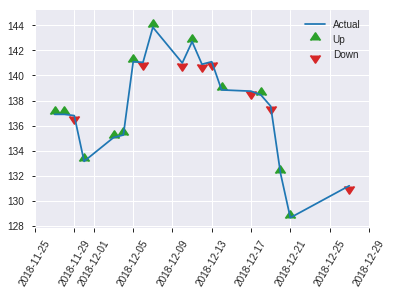


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20408463918294173
RMSE: 0.4517572790591666
LogLoss: 0.5917763685645678
Null degrees of freedom: 244
Residual degrees of freedom: 221
Null deviance: 342.0840315976776
Residual deviance: 289.9704205966383
AIC: 337.9704205966383
AUC: 0.7436273855598559
pr_auc: 0.6980114211836899
Gini: 0.4872547711197117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3613754429881681: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   64   0.5039   (64.0/127.0)
1      13   105  0.1102   (13.0/118.0)
Total  76   169  0.3143   (77.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361375     0.731707  168
max f2                       0.201266     0.843109  209
max f0point5                 0.430401     0.676638  145
max accuracy                 0.430401     0.697959  145
max precision                0.882285     1         0
max recall                   0.131548     1         232
max specificity              0.882285     1         0
max absolute_mcc             0.361375     0.416831  168
max min_per_class_accuracy   0.503292     0.661417  121
max mean_per_class_accuracy  0.421901     0.702356  149

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 47.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.86096            2.07627   2.07627            1                0.870505  1                           0.870505            0.0254237       0.0254237                  107.627   107.627
    2        0.0204082                   0.816975           1.03814   1.66102            0.5              0.843148  0.8                         0.859562            0.00847458      0.0338983                  3.81356   66.1017
    3        0.0326531                   0.801953           2.07627   1.81674            1                0.80864   0.875                       0.840466            0.0254237       0.059322                   107.627   81.6737
    4        0.0408163                   0.787766           1.03814   1.66102            0.5              0.796193  0.8                         0.831612            0.00847458      0.0677966                  3.81356   66.1017
    5        0.0530612                   0.784404           2.07627   1.75684            1                0.785613  0.846154                    0.820997            0.0254237       0.0932203                  107.627   75.6845
    6        0.102041                    0.7494             1.73023   1.74407            0.833333         0.761015  0.84                        0.792205            0.0847458       0.177966                   73.0226   74.4068
    7        0.15102                     0.713582           1.21116   1.57123            0.583333         0.731668  0.756757                    0.772572            0.059322        0.237288                   21.1158   57.1232
    8        0.2                         0.693199           1.21116   1.48305            0.583333         0.702143  0.714286                    0.755324            0.059322        0.29661                    21.1158   48.3051
    9        0.302041                    0.625486           1.57797   1.51512            0.76             0.663358  0.72973                     0.724254            0.161017        0.457627                   57.7966   51.5117
    10       0.4                         0.564163           0.951624  1.37712            0.458333         0.592049  0.663265                    0.691877            0.0932203       0.550847                   -4.83757  37.7119
    11       0.502041                    0.498334           1.24576   1.35042            0.6              0.52852   0.650407                    0.658675            0.127119        0.677966                   24.5763   35.042
    12       0.6                         0.427364           1.29767   1.34181            0.625            0.454845  0.646259                    0.625396            0.127119        0.805085                   29.7669   34.1808
    13       0.697959                    0.342246           0.865113  1.2749             0.416667         0.392176  0.614035                    0.592664            0.0847458       0.889831                   -13.4887  27.4903
    14       0.8                         0.260693           0.498305  1.17585            0.24             0.309826  0.566327                    0.556587            0.0508475       0.940678                   -50.1695  17.5847
    15       0.897959                    0.173393           0.346045  1.08532            0.166667         0.209721  0.522727                    0.518747            0.0338983       0.974576                   -65.3955  8.53236
    16       1                           0.0532354          0.249153  1                  0.12             0.122871  0.481633                    0.478352          

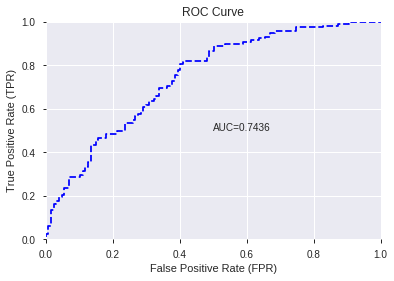

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


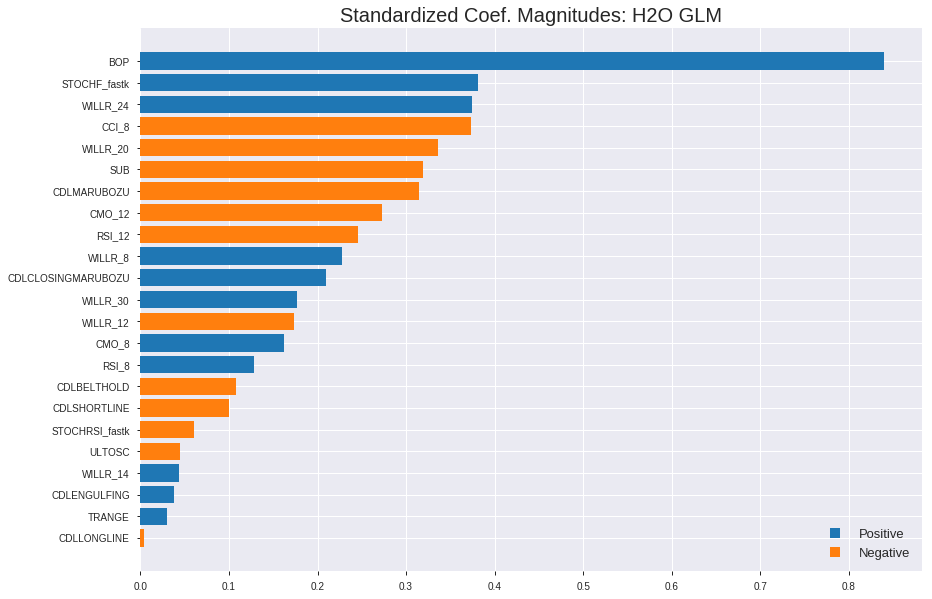

'log_likelihood'
--2019-08-24 21:15:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.32.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.32.24|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_211546_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_211546_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'WILLR_24',
 'CCI_8',
 'WILLR_20',
 'SUB',
 'CDLMARUBOZU',
 'CMO_12',
 'RSI_12',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'WILLR_30',
 'WILLR_12',
 'CMO_8',
 'RSI_8',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'ULTOSC',
 'WILLR_14',
 'CDLENGULFING',
 'TRANGE',
 'CDLLONGLINE']

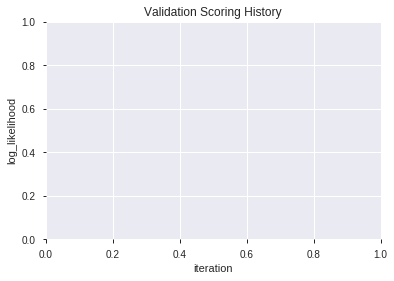

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_211555_model_6  0.697918  0.637886              0.358535  0.471764  0.222561
1  XGBoost_grid_1_AutoML_20190824_211555_model_4  0.696050  0.637476              0.330642  0.471375  0.222194
2  XGBoost_grid_1_AutoML_20190824_211555_model_5  0.689243  0.668803              0.340651  0.483312  0.233591
3  XGBoost_grid_1_AutoML_20190824_211555_model_7  0.689110  0.651626              0.347324  0.476878  0.227412
4  XGBoost_grid_1_AutoML_20190824_211555_model_2  0.687709  0.645233              0.386094  0.475154  0.225771
5               XGBoost_3_AutoML_20190824_211555  0.687308  0.643403              0.330342  0.474275  0.224937
6  XGBoost_grid_1_AutoML_20190824_211555_model_3  0.684105  0.648434              0.381256  0.475944  0.226523
7               XGBoost_2_AutoML_20190824_211555  0.681503  0.652632              0.375184  0.478068  0.228549
8  XGBoost_grid_1_AutoML_20190824_211555_model_1  0.681036  0.656427              0.345189  0.479549  0.229967
9               XGBoost_1_AutoML_20190824_211555  0.670025  0.667135              0.363673  0.484203  0.234452

variable  relative_importance  scaled_importance  percentage
0                  BOP          2046.552612           1.000000    0.231338
1         STOCHF_fastk           787.099731           0.384598    0.088972
2                  SUB           706.936157           0.345428    0.079910
3                CCI_8           663.977966           0.324437    0.075055
4               ULTOSC           643.950134           0.314651    0.072791
5               TRANGE           615.613281           0.300805    0.069588
6                CMO_8           381.533508           0.186427    0.043128
7             WILLR_12           367.344208           0.179494    0.041524
8              WILLR_8           363.691040           0.177709    0.041111
9             WILLR_30           346.959900           0.169534    0.039220
10            WILLR_14           339.799652           0.166035    0.038410
11            WILLR_24           333.214081           0.162817    0.037666
12              CMO_12           309.002380           0.150987    0.034929
13            WILLR_20           285.127533           0.139321    0.032230
14      STOCHRSI_fastk           156.560379           0.076500    0.017697
15         CDLBELTHOLD           102.938477           0.050298    0.011636
16              RSI_12            89.555023           0.043759    0.010123
17               RSI_8            86.380981           0.042208    0.009764
18         CDLLONGLINE            59.329777           0.028990    0.006707
19         CDLMARUBOZU            44.166233           0.021581    0.004992
20        CDLSHORTLINE            39.018272           0.019065    0.004411
21  CDLCLOSINGMARUBOZU            38.927689           0.019021    0.004400
22        CDLENGULFING            38.923679           0.019019    0.004400

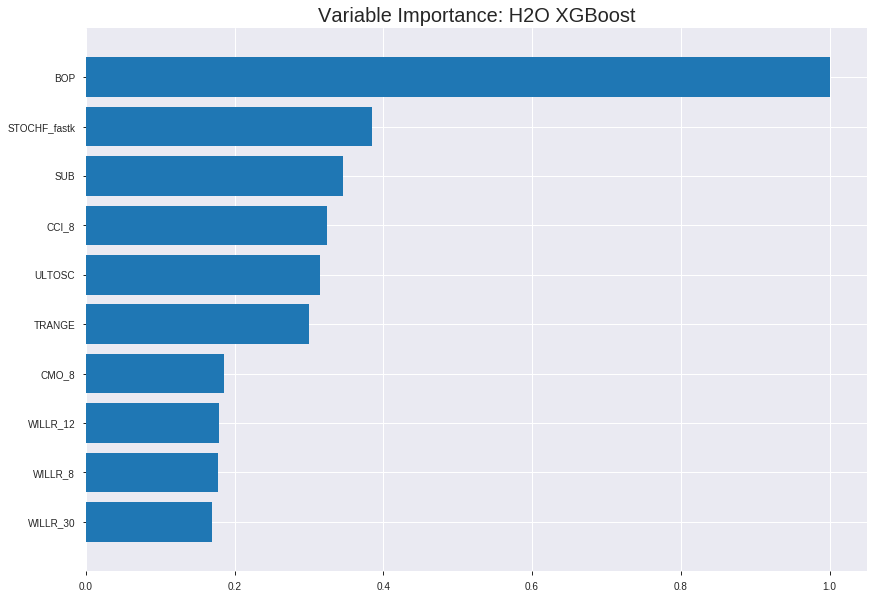

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_211555_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.151241382281862
RMSE: 0.3888976501367192
LogLoss: 0.47406742173917044
Mean Per-Class Error: 0.19375635005629244
AUC: 0.8887085701732708
pr_auc: 0.9043717800235871
Gini: 0.7774171403465415
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.453731765349706: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      530  266   0.3342   (266.0/796.0)
1      95   820   0.1038   (95.0/915.0)
Total  625  1086  0.211    (361.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453732     0.81959   240
max f2                       0.316934     0.890084  305
max f0point5                 0.588882     0.841051  171
max accuracy                 0.54767      0.805961  195
max precision                0.9252       1         0
max recall                   0.200023     1         355
max specificity              0.9252       1         0
max absolute_mcc             0.588882     0.612899  171
max min_per_class_accuracy   0.54653      0.803279  196
max mean_per_class_accuracy  0.54767      0.806244  195

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.888678           1.86995    1.86995            1                0.899159  1                           0.899159            0.0196721       0.0196721                  86.9945   86.9945
    2        0.0204559                   0.874668           1.86995    1.86995            1                0.88079   1                           0.890237            0.0185792       0.0382514                  86.9945   86.9945
    3        0.0303916                   0.863851           1.86995    1.86995            1                0.868222  1                           0.88304             0.0185792       0.0568306                  86.9945   86.9945
    4        0.0403273                   0.856897           1.86995    1.86995            1                0.860164  1                           0.877404            0.0185792       0.0754098                  86.9945   86.9945
    5        0.050263                    0.852067           1.86995    1.86995            1                0.854688  1                           0.872913            0.0185792       0.0939891                  86.9945   86.9945
    6        0.100526                    0.818816           1.8482     1.85907            0.988372         0.834691  0.994186                    0.853802            0.0928962       0.186885                   84.8202   85.9074
    7        0.150205                    0.783273           1.78195    1.83357            0.952941         0.800076  0.980545                    0.836033            0.0885246       0.27541                    78.1948   83.3565
    8        0.200468                    0.747677           1.71774    1.80452            0.918605         0.765115  0.965015                    0.818252            0.0863388       0.361749                   71.7741   80.4525
    9        0.300409                    0.678426           1.65124    1.75353            0.883041         0.7136    0.937743                    0.783435            0.165027        0.526776                   65.1238   75.3529
    10       0.400351                    0.616755           1.41066    1.66794            0.754386         0.649881  0.891971                    0.750096            0.140984        0.66776                    41.0661   66.7937
    11       0.500292                    0.556775           1.15915    1.5663             0.619883         0.586527  0.837617                    0.71742             0.115847        0.783607                   15.9147   56.6298
    12       0.600234                    0.481168           0.842022   1.4457             0.450292         0.52088   0.773126                    0.684695            0.084153        0.86776                    -15.7978  44.5703
    13       0.700175                    0.402088           0.568638   1.32051            0.304094         0.4422    0.706177                    0.650082            0.0568306       0.92459                    -43.1362  32.0512
    14       0.800117                    0.313859           0.524897   1.22113            0.280702         0.359304  0.653031                    0.613761            0.052459        0.977049                   -47.5103  22.1133
    15       0.900058                    0.209553           0.207772   1.10861            0.111111         0.261124  0.592857                    0.574605            0.020765        0.997814                   -79.2228  10.861
    16       1                           0.0796011          0.0218707  1                  0.0116959        0.164916  0.534775                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1908878217967824
RMSE: 0.43690710888789897
LogLoss: 0.5663893522294693
Mean Per-Class Error: 0.27859601174207915
AUC: 0.7797010493639707
pr_auc: 0.7792828819435331
Gini: 0.5594020987279413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45191845297813416: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  93   0.4189   (93.0/222.0)
1      41   226  0.1536   (41.0/267.0)
Total  170  319  0.274    (134.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451918     0.771331  252
max f2                       0.200563     0.866271  362
max f0point5                 0.60086      0.754215  164
max accuracy                 0.454724     0.725971  250
max precision                0.809574     0.909091  34
max recall                   0.110364     1         395
max specificity              0.902819     0.995495  0
max absolute_mcc             0.451918     0.446963  252
max min_per_class_accuracy   0.554337     0.719101  197
max mean_per_class_accuracy  0.552357     0.721404  199

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 53.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.881341           1.09888   1.09888            0.6              0.893162  0.6                         0.893162            0.011236        0.011236                   9.88764   9.88764
    2        0.0204499                   0.868377           1.83146   1.46517            1                0.876287  0.8                         0.884725            0.0187266       0.0299625                  83.1461   46.5169
    3        0.0306748                   0.854377           1.83146   1.58727            1                0.860998  0.866667                    0.876816            0.0187266       0.0486891                  83.1461   58.7266
    4        0.0408998                   0.848704           1.46517   1.55674            0.8              0.851881  0.85                        0.870582            0.0149813       0.0636704                  46.5169   55.6742
    5        0.0511247                   0.836893           1.46517   1.53843            0.8              0.843674  0.84                        0.8652              0.0149813       0.0786517                  46.5169   53.8427
    6        0.100204                    0.801965           1.67884   1.6072             0.916667         0.818318  0.877551                    0.842238            0.082397        0.161049                   67.8839   60.72
    7        0.151329                    0.773096           1.53843   1.58397            0.84             0.78445   0.864865                    0.822715            0.0786517       0.2397                     53.8427   58.3966
    8        0.200409                    0.748932           1.44991   1.55114            0.791667         0.759191  0.846939                    0.807158            0.071161        0.310861                   44.9906   55.1135
    9        0.300613                    0.694545           1.34556   1.48261            0.734694         0.720888  0.809524                    0.778401            0.134831        0.445693                   34.5563   48.2611
    10       0.400818                    0.623747           1.30819   1.439              0.714286         0.659722  0.785714                    0.748731            0.131086        0.576779                   30.8186   43.9005
    11       0.501022                    0.567962           1.19606   1.39042            0.653061         0.592266  0.759184                    0.717438            0.11985         0.696629                   19.6056   39.0415
    12       0.599182                    0.497418           0.992041  1.32515            0.541667         0.535682  0.723549                    0.687663            0.0973783       0.794007                   -0.79588  32.5152
    13       0.699387                    0.406124           0.784912  1.24775            0.428571         0.453128  0.681287                    0.65406             0.0786517       0.872659                   -21.5088  24.775
    14       0.799591                    0.315487           0.672781  1.17569            0.367347         0.359729  0.641944                    0.617174            0.0674157       0.940075                   -32.7219  17.5695
    15       0.899796                    0.222709           0.299014  1.07806            0.163265         0.271398  0.588636                    0.578667            0.0299625       0.970037                   -70.0986  7.80644
    16       1                           0.0811535          0.299014  1                  0.163265         0.16398   0.546012                    0.537114            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 21:16:05  6.771 sec   0                  0.5              0.693147            0.5             0                  1                0.465225                         0.5                0.693147              0.5               0                    1                  0.453988
    2019-08-24 21:16:05  6.826 sec   5                  0.476397         0.646808            0.808045        0.81699            1.86995          0.278784                         0.480003           0.653764              0.768288          0.765562             1.83146            0.265849
    2019-08-24 21:16:05  6.862 sec   10                 0.458416         0.612054            0.822763        0.844819           1.86995          0.271771                         0.466337           0.627078              0.770009          0.772713             1.83146            0.296524
    2019-08-24 21:16:05  6.900 sec   15                 0.445468         0.586863            0.830415        0.848974           1.86995          0.263004                         0.455751           0.606274              0.777137          0.776221             1.83146            0.284254
    2019-08-24 21:16:06  6.938 sec   20                 0.434207         0.564783            0.841739        0.863366           1.86995          0.233781                         0.448725           0.592186              0.781953          0.787659             1.46517            0.267894
    2019-08-24 21:16:06  6.976 sec   25                 0.426194         0.548641            0.845604        0.868121           1.86995          0.236119                         0.444454           0.583242              0.780494          0.784246             1.46517            0.276074
    2019-08-24 21:16:06  7.015 sec   30                 0.419262         0.53439             0.850659        0.872244           1.86995          0.231444                         0.441011           0.575705              0.782223          0.787624             1.46517            0.267894
    2019-08-24 21:16:06  7.062 sec   35                 0.413822         0.523419            0.857832        0.877829           1.86995          0.220923                         0.440276           0.573812              0.780612          0.785854             1.46517            0.271984
    2019-08-24 21:16:06  7.116 sec   40                 0.408479         0.512665            0.86384         0.883008           1.86995          0.217417                         0.439593           0.572099              0.778444          0.78526              1.46517            0.267894
    2019-08-24 21:16:06  7.159 sec   45                 0.404178         0.503682            0.868072        0.886701           1.86995          0.212741                         0.438019           0.568456              0.780292          0.785854             1.46517            0.276074
    2019-08-24 21:16:06  7.202 sec   50                 0.399511         0.494408            0.873703        0.891935           1.86995          0.214494                         0.437225           0.567116              0.780823          0.780289             1.09888            0.274029
    2019-08-24 21:16:06  7.244 sec   55                 0.395369         0.486426            0.879375        0.896525           1.86995          0.214494                         0.437034           0.566481              0.779161          0

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
BOP                 2046.5526123046875     1.0                   0.23133768778310612
STOCHF_fastk        787.0997314453125      0.3845978484564512    0.08897197698827286
SUB                 706.9361572265625      0.345427795491883     0.07991046750510786
CCI_8               663.9779663085938      0.32443728165916397   0.07505457056966734
ULTOSC              643.9501342773438      0.31465115062552496   0.07279066964400278
---                 ---                    ---                   ---
CDLLONGLINE         59.329776763916016     0.028990105803878105  0.006706504045256766
CDLMARUBOZU         44.16623306274414      0.021580795332208514  0.004992451292673567
CDLSHORTLINE        39.018272399902344     0.019065364928958575  0.0044105374394064
CDLCLOSINGMARUBOZU  38.92768859863281      0.019021103276106406  0.0044002980509781206
CDLENGULFING        38.92367935180664      0.019019144251548683  0.004399844854766627


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.673469387755102)

('F1', 0.6979865771812079)

('auc', 0.697918056853063)

('logloss', 0.6378860417674671)

('mean_per_class_error', 0.3227679167222741)

('rmse', 0.47176397666979636)

('mse', 0.22256124968330016)

xgboost prediction progress: |████████████████████████████████████████████| 100%


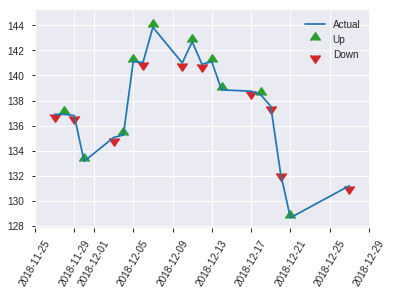


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22256124968330016
RMSE: 0.47176397666979636
LogLoss: 0.6378860417674671
Mean Per-Class Error: 0.3227679167222741
AUC: 0.697918056853063
pr_auc: 0.6442301836452985
Gini: 0.3958361137061259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2926980257034302: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   76   0.5984   (76.0/127.0)
1      14   104  0.1186   (14.0/118.0)
Total  65   180  0.3673   (90.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.292698     0.697987  179
max f2                       0.126874     0.830966  231
max f0point5                 0.411032     0.655271  145
max accuracy                 0.411032     0.673469  145
max precision                0.896461     1         0
max recall                   0.0861989    1         243
max specificity              0.896461     1         0
max absolute_mcc             0.411032     0.360929  145
max min_per_class_accuracy   0.510671     0.653543  121
max mean_per_class_accuracy  0.411032     0.677232  145

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 48.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.850747           1.38418   1.38418            0.666667         0.875785  0.666667                    0.875785            0.0169492       0.0169492                  38.4181   38.4181
    2        0.0204082                   0.835975           1.03814   1.24576            0.5              0.83878   0.6                         0.860983            0.00847458      0.0254237                  3.81356   24.5763
    3        0.0326531                   0.829966           2.07627   1.5572             1                0.832635  0.75                        0.850352            0.0254237       0.0508475                  107.627   55.7203
    4        0.0408163                   0.824924           2.07627   1.66102            1                0.829774  0.8                         0.846237            0.0169492       0.0677966                  107.627   66.1017
    5        0.0530612                   0.820123           2.07627   1.75684            1                0.821922  0.846154                    0.840626            0.0254237       0.0932203                  107.627   75.6845
    6        0.102041                    0.769831           1.21116   1.49492            0.583333         0.794145  0.72                        0.818315            0.059322        0.152542                   21.1158   49.4915
    7        0.15102                     0.742679           1.5572    1.51512            0.75             0.756758  0.72973                     0.798351            0.0762712       0.228814                   55.7203   51.5117
    8        0.2                         0.719844           1.03814   1.39831            0.5              0.730318  0.673469                    0.781689            0.0508475       0.279661                   3.81356   39.8305
    9        0.302041                    0.646404           1.24576   1.34677            0.6              0.679138  0.648649                    0.747044            0.127119        0.40678                    24.5763   34.677
    10       0.4                         0.563748           1.21116   1.31356            0.583333         0.605969  0.632653                    0.712495            0.118644        0.525424                   21.1158   31.3559
    11       0.502041                    0.506023           1.32881   1.31666            0.64             0.529697  0.634146                    0.675341            0.135593        0.661017                   32.8814   31.666
    12       0.6                         0.410095           1.21116   1.29944            0.583333         0.452413  0.62585                     0.638945            0.118644        0.779661                   21.1158   29.9435
    13       0.697959                    0.314256           0.69209   1.21419            0.333333         0.367053  0.584795                    0.600784            0.0677966       0.847458                   -30.791   21.4194
    14       0.8                         0.252756           0.581356  1.13347            0.28             0.281319  0.545918                    0.560036            0.059322        0.90678                    -41.8644  13.3475
    15       0.897959                    0.167043           0.519068  1.06645            0.25             0.212924  0.513636                    0.52217             0.0508475       0.957627                   -48.0932  6.64484
    16       1                           0.0819663          0.415254  1                  0.2              0.127994  0.481633                    0.481948           

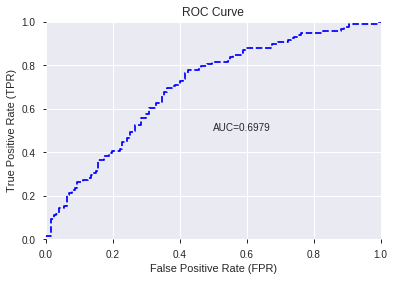

This function is available for GLM models only


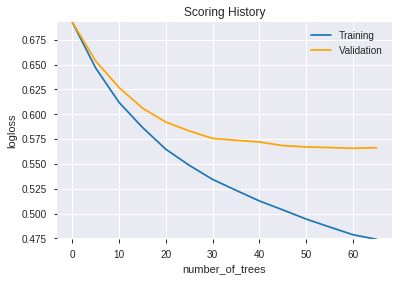

--2019-08-24 21:16:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_211555_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_211555_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'ULTOSC',
 'TRANGE',
 'CMO_8',
 'WILLR_12',
 'WILLR_8',
 'WILLR_30',
 'WILLR_14',
 'WILLR_24',
 'CMO_12',
 'WILLR_20',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'RSI_12',
 'RSI_8',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

67

['BBANDS_upperband_14_4_5',
 'BBANDS_upperband_14_7_4',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_20_2_3',
 'BBANDS_upperband_24_5_4',
 'BBANDS_upperband_30_1_3',
 'BBANDS_upperband_30_2_2',
 'BOP',
 'MACDFIX_hist_8',
 'MFI_8',
 'MINUS_DI_8',
 'PLUS_DM_8',
 'ROCP_8',
 'ROCR_8',
 'RSI_8',
 'ADX_12',
 'ADXR_12',
 'CCI_12',
 'MFI_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'ROCR_12',
 'ADXR_14',
 'aroondown_14',
 'CCI_14',
 'DX_14',
 'MACDFIX_signal_14',
 'MFI_14',
 'MINUS_DI_14',
 'ROCR_14',
 'TRIX_14',
 'CCI_20',
 'DX_20',
 'MINUS_DM_20',
 'PLUS_DM_20',
 'ROCR_20',
 'WILLR_20',
 'AROONOSC_24',
 'MFI_24',
 'ROC_24',
 'WILLR_24',
 'aroonup_30',
 'CCI_30',
 'PLUS_DI_30',
 'PLUS_DM_30',
 'ROC_30',
 'WILLR_30',
 'MACD_hist',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'NATR_12',
 'ATR_14',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'STDDEV_8',
 'VAR_8',
 'LINEARREG_SLOPE_12',
 'BETA_14',
 'CORREL_14',
 'LINEARREG_SLOPE_14',
 'VAR_14

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_211721_model_7  0.706326  0.811983              0.327939  0.522447  0.272951
1  DeepLearning_grid_1_AutoML_20190824_211721_model_9  0.703723  0.650561              0.340952  0.479039  0.229478
2  DeepLearning_grid_1_AutoML_20190824_211721_model_5  0.699586  0.668307              0.322468  0.488019  0.238163
3  DeepLearning_grid_1_AutoML_20190824_211721_model_6  0.686507  0.731546              0.344588  0.491895  0.241960
4  DeepLearning_grid_1_AutoML_20190824_211721_model_8  0.685306  0.723468              0.349726  0.498645  0.248647
5  DeepLearning_grid_1_AutoML_20190824_211721_model_4  0.662952  0.860409              0.350327  0.525788  0.276453
6               DeepLearning_1_AutoML_20190824_211721  0.653076  0.699639              0.401842  0.499137  0.249138
7  DeepLearning_grid_1_AutoML_20190824_211721_model_3  0.590618  0.972474              0.472441  0.560154  0.313772
8  DeepLearning_grid_1_AutoML_20190824_211721_model_2  0.555852  1.551343              0.492126  0.604945  0.365958
9  DeepLearning_grid_1_AutoML_20190824_211721_model_1  0.554284  2.468109              0.454558  0.624353  0.389817

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.018349
1                    TRANGE             0.867633           0.867633    0.015920
2                   ROCR_20             0.853180           0.853180    0.015655
3               CDLLONGLINE             0.852321           0.852321    0.015639
4                    ROC_24             0.850240           0.850240    0.015601
..                      ...                  ...                ...         ...
62           MACDFIX_hist_8             0.776617           0.776617    0.014250
63  BBANDS_upperband_14_4_5             0.773216           0.773216    0.014187
64                CORREL_14             0.769590           0.769590    0.014121
65                  ADXR_14             0.768406           0.768406    0.014099
66  BBANDS_upperband_30_2_2             0.762778           0.762778    0.013996

[67 rows x 4 columns]

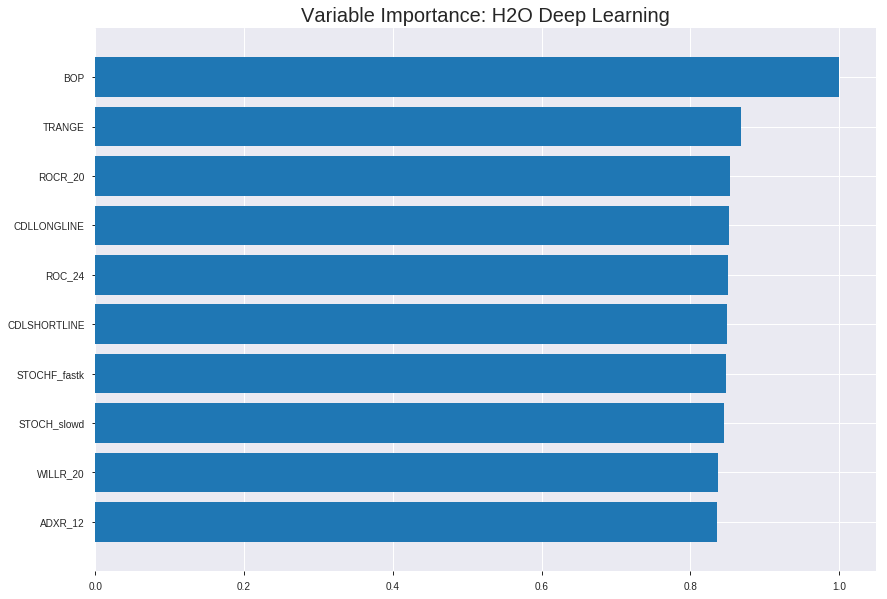

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_211721_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21490098831197724
RMSE: 0.4635741454308871
LogLoss: 0.6223540010413754
Mean Per-Class Error: 0.2978245050388555
AUC: 0.7665980174094515
pr_auc: 0.7728162037401435
Gini: 0.5331960348189031
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5591100829201465: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      365  431   0.5415   (431.0/796.0)
1      98   817   0.1071   (98.0/915.0)
Total  463  1248  0.3092   (529.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.55911      0.755432  247
max f2                       0.435366     0.862168  312
max f0point5                 0.676289     0.722642  170
max accuracy                 0.634933     0.704851  197
max precision                0.995484     1         0
max recall                   0.0120369    1         398
max specificity              0.995484     1         0
max absolute_mcc             0.634933     0.405263  197
max min_per_class_accuracy   0.656656     0.696175  184
max mean_per_class_accuracy  0.641673     0.702175  193

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 65.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.981836           1.66217   1.66217            0.888889         0.98948   0.888889                    0.98948             0.0174863       0.0174863                  66.2174   66.2174
    2        0.0204559                   0.972343           1.86995   1.76309            1                0.977628  0.942857                    0.983723            0.0185792       0.0360656                  86.9945   76.3091
    3        0.0303916                   0.962843           1.64995   1.7261             0.882353         0.967508  0.923077                    0.978422            0.0163934       0.052459                   64.9952   72.6103
    4        0.0403273                   0.951368           1.53995   1.68024            0.823529         0.957221  0.898551                    0.973199            0.0153005       0.0677596                  53.9955   68.0241
    5        0.050263                    0.942957           1.75995   1.696              0.941176         0.947789  0.906977                    0.968176            0.0174863       0.0852459                  75.9949   69.5997
    6        0.100526                    0.905377           1.60902   1.65251            0.860465         0.922756  0.883721                    0.945466            0.0808743       0.16612                    60.9023   65.251
    7        0.150205                    0.867796           1.45196   1.58618            0.776471         0.886974  0.848249                    0.92612             0.0721311       0.238251                   45.1958   58.6179
    8        0.200468                    0.830736           1.45682   1.55374            0.77907          0.849531  0.830904                    0.906917            0.073224        0.311475                   45.6818   55.3745
    9        0.300409                    0.765689           1.33411   1.48068            0.71345          0.795287  0.791829                    0.86978             0.133333        0.444809                   33.4113   48.0677
    10       0.400351                    0.713192           1.2685    1.42771            0.678363         0.738591  0.763504                    0.83703             0.126776        0.571585                   26.8501   42.771
    11       0.500292                    0.661832           1.10447   1.36314            0.590643         0.686318  0.728972                    0.806923            0.110383        0.681967                   10.4471   36.3138
    12       0.600234                    0.617876           0.907634  1.28729            0.48538          0.638776  0.688413                    0.778926            0.0907104       0.772678                   -9.23657  28.7294
    13       0.700175                    0.571793           0.951376  1.23935            0.508772         0.594017  0.662771                    0.752532            0.095082        0.86776                    -4.86243  23.9346
    14       0.800117                    0.52309            0.645186  1.16513            0.345029         0.54875   0.623083                    0.727078            0.0644809       0.93224                    -35.4814  16.513
    15       0.900058                    0.436484           0.47022   1.08797            0.251462         0.485426  0.581818                    0.700245            0.0469945       0.979235                   -52.978   8.79682
    16       1                           0.00894003         0.207772  1                  0.111111         0.279029  0.534775                    0.658148            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2316109423776134
RMSE: 0.48125974522872095
LogLoss: 0.6660715376607792
Mean Per-Class Error: 0.33763538819718597
AUC: 0.7193963626547896
pr_auc: 0.7451354197357205
Gini: 0.43879272530957913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5495258909882345: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   133  0.5991   (133.0/222.0)
1      28   239  0.1049   (28.0/267.0)
Total  117  372  0.3292   (161.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.549526     0.748044  296
max f2                       0.0205576    0.86018   395
max f0point5                 0.594428     0.691725  261
max accuracy                 0.594428     0.676892  261
max precision                0.986987     1         0
max recall                   0.0205576    1         395
max specificity              0.986987     1         0
max absolute_mcc             0.549526     0.345467  296
max min_per_class_accuracy   0.669427     0.64794   202
max mean_per_class_accuracy  0.594428     0.662365  261

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 67.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.974733           1.46517   1.46517            0.8              0.98022   0.8                         0.98022             0.0149813       0.0149813                  46.5169   46.5169
    2        0.0204499                   0.968574           1.83146   1.64831            1                0.970803  0.9                         0.975511            0.0187266       0.0337079                  83.1461   64.8315
    3        0.0306748                   0.962548           1.46517   1.58727            0.8              0.966498  0.866667                    0.972507            0.0149813       0.0486891                  46.5169   58.7266
    4        0.0408998                   0.959259           1.46517   1.55674            0.8              0.961059  0.85                        0.969645            0.0149813       0.0636704                  46.5169   55.6742
    5        0.0511247                   0.953827           1.83146   1.61169            1                0.955493  0.88                        0.966815            0.0187266       0.082397                   83.1461   61.1685
    6        0.100204                    0.925924           1.60253   1.6072             0.875            0.941315  0.877551                    0.954325            0.0786517       0.161049                   60.2528   60.72
    7        0.151329                    0.889252           1.61169   1.60872            0.88             0.909722  0.878378                    0.939257            0.082397        0.243446                   61.1685   60.8715
    8        0.200409                    0.867602           1.29728   1.53245            0.708333         0.880427  0.836735                    0.924849            0.0636704       0.307116                   29.7285   53.2447
    9        0.300613                    0.804726           1.15868   1.40786            0.632653         0.840671  0.768707                    0.89679             0.116105        0.423221                   15.8679   40.7858
    10       0.400818                    0.74756            0.934419  1.2895             0.510204         0.776414  0.704082                    0.866696            0.093633        0.516854                   -6.55813  28.9498
    11       0.501022                    0.68268            1.15868   1.26333            0.632653         0.716382  0.689796                    0.836633            0.116105        0.632959                   15.8679   26.3334
    12       0.599182                    0.62576            1.06835   1.23139            0.583333         0.647498  0.672355                    0.805648            0.104869        0.737828                   6.83521   23.1392
    13       0.699387                    0.57963            0.971795  1.1942             0.530612         0.605601  0.652047                    0.776987            0.0973783       0.835206                   -2.82045  19.4198
    14       0.799591                    0.528377           0.822288  1.14759            0.44898          0.553993  0.626598                    0.749041            0.082397        0.917603                   -17.7712  14.759
    15       0.899796                    0.416101           0.373767  1.06141            0.204082         0.470521  0.579545                    0.718024            0.0374532       0.955056                   -62.6233  6.14147
    16       1                           0.00336267         0.448521  1                  0.244898         0.248772  0.546012                    0.671003            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 21:22:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 21:22:52  7.378 sec         204 obs/sec       0.724722  1             1240       0.538774         0.820629            -0.166754      0.584506        0.619811           1.76606          0.465225                         0.540845           0.819342              -0.180048        0.56901           0.605679             1.83146            0.437628
    2019-08-24 21:23:04  19.995 sec        434 obs/sec       4.42782   6             7576       0.463574         0.622354            0.136218       0.766598        0.772816           1.66217          0.309176                         0.48126            0.666072              0.0656436        0.719396          0.745135             1.46517            0.329243
    2019-08-24 21:23:18  33.504 sec        507 obs/sec       8.82992   12            15108      0.427162         0.538471            0.266581       0.799031        0.826978           1.86995          0.308007                         0.4936             0.727401              0.0171143        0.685587          0.707597             1.09888            0.372188
    2019-08-24 21:23:31  46.576 sec        544 obs/sec       13.2274   18            22632      0.515429         0.78883             -0.0678337     0.849789        0.861667           1.86995          0.246055                         0.577672           1.06413               -0.346221        0.658358          0.685421             1.46517            0.384458
    2019-08-24 21:23:44  59.454 sec        567 obs/sec       17.6569   24            30211      0.375722         0.431514            0.432587       0.892719        0.865134           1.86995          0.190532                         0.523757           0.908372              -0.106657        0.667527          0.691832             1.46517            0.400818
    2019-08-24 21:23:57  1 min 12.127 sec  583 obs/sec       22.062    30            37748      0.333819         0.346623            0.552092       0.924028        0.889306           1.86995          0.165985                         0.531645           1.02915               -0.140243        0.655844          0.667752             1.46517            0.392638
    2019-08-24 21:23:58  1 min 13.362 sec  583 obs/sec       22.062    30            37748      0.463574         0.622354            0.136218       0.766598        0.772816           1.66217          0.309176                         0.48126            0.666072              0.0656436        0.719396          0.745135             1.46517            0.329243

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.018348541939205865
TRANGE                   0.8676334619522095     0.8676334619522095   0.015919808964488493
ROCR_20                  0.8531803488731384     0.8531803488731384   0.01565461541300507
CDLLONGLINE              0.8523210287094116     0.8523210287094116   0.015638848140941724
ROC_24                   0.8502400517463684     0.8502400517463684   0.015600665247860806
---                      ---                    ---                  ---
MACDFIX_hist_8           0.7766173481941223     0.7766173481941223   0.014249795984054698
BBANDS_upperband_14_4_5  0.773215651512146      0.773215651512146    0.014187379809820998
CORREL_14                0.7695901393890381     0.7695901393890381   0.014120856948579053
ADXR_14                  0.7684061527252197     0.7684061527252197   0.01409913251962252
BBANDS_upperband_30_2_2  0.7627784609794617     0.7627784609794617   0.013995872581604557


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.673469387755102)

('F1', 0.7112676056338029)

('auc', 0.7063259041772321)

('logloss', 0.8119834459157271)

('mean_per_class_error', 0.32637127986120373)

('rmse', 0.5224473329293327)

('mse', 0.272951215684973)

deeplearning prediction progress: |███████████████████████████████████████| 100%


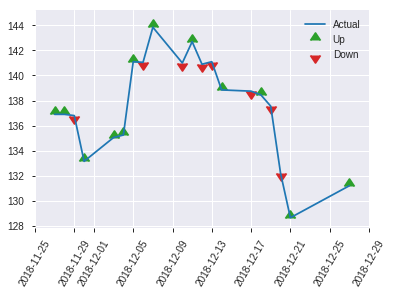


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.272951215684973
RMSE: 0.5224473329293327
LogLoss: 0.8119834459157271
Mean Per-Class Error: 0.32637127986120373
AUC: 0.7063259041772321
pr_auc: 0.6365367846849839
Gini: 0.41265180835446413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6543105793064222: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   65   0.5118   (65.0/127.0)
1      17   101  0.1441   (17.0/118.0)
Total  79   166  0.3347   (82.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.654311     0.711268  165
max f2                       0.219995     0.835714  227
max f0point5                 0.790222     0.660066  121
max accuracy                 0.790222     0.673469  121
max precision                0.962898     0.769231  12
max recall                   0.0463315    1         240
max specificity              0.991015     0.992126  0
max absolute_mcc             0.654311     0.367863  165
max min_per_class_accuracy   0.790658     0.669291  120
max mean_per_class_accuracy  0.790222     0.673629  121

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 70.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.980766           0         0                  0                0.985157  0                           0.985157            0               0                          -100      -100
    2        0.0204082                   0.976832           2.07627   0.830508           1                0.978794  0.4                         0.982612            0.0169492       0.0169492                  107.627   -16.9492
    3        0.0326531                   0.971954           2.07627   1.29767            1                0.974924  0.625                       0.979729            0.0254237       0.0423729                  107.627   29.7669
    4        0.0408163                   0.96832            2.07627   1.45339            1                0.970468  0.7                         0.977877            0.0169492       0.059322                   107.627   45.339
    5        0.0530612                   0.962677           2.07627   1.59713            1                0.964915  0.769231                    0.974886            0.0254237       0.0847458                  107.627   59.7132
    6        0.102041                    0.951936           1.21116   1.41186            0.583333         0.957852  0.68                        0.966709            0.059322        0.144068                   21.1158   41.1864
    7        0.15102                     0.936901           1.21116   1.34677            0.583333         0.944122  0.648649                    0.959384            0.059322        0.20339                    21.1158   34.677
    8        0.2                         0.920305           1.73023   1.44068            0.833333         0.929119  0.693878                    0.951972            0.0847458       0.288136                   73.0226   44.0678
    9        0.302041                    0.878159           1.41186   1.43094            0.68             0.901055  0.689189                    0.93477             0.144068        0.432203                   41.1864   43.0944
    10       0.4                         0.836448           1.21116   1.37712            0.583333         0.853355  0.663265                    0.914832            0.118644        0.550847                   21.1158   37.7119
    11       0.502041                    0.787732           1.24576   1.35042            0.6              0.810405  0.650407                    0.893607            0.127119        0.677966                   24.5763   35.042
    12       0.6                         0.73006            0.69209   1.24294            0.333333         0.758813  0.598639                    0.8716              0.0677966       0.745763                   -30.791   24.2938
    13       0.697959                    0.618253           1.21116   1.23848            0.583333         0.683159  0.596491                    0.845152            0.118644        0.864407                   21.1158   23.8478
    14       0.8                         0.488568           0.332203  1.12288            0.16             0.55709   0.540816                    0.808409            0.0338983       0.898305                   -66.7797  12.2881
    15       0.897959                    0.292989           0.605579  1.06645            0.291667         0.416316  0.513636                    0.765636            0.059322        0.957627                   -39.4421  6.64484
    16       1                           0.00235828         0.415254  1                  0.2              0.146927  0.481633                    0.702502            0.

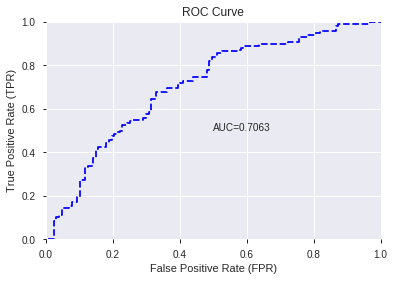

This function is available for GLM models only


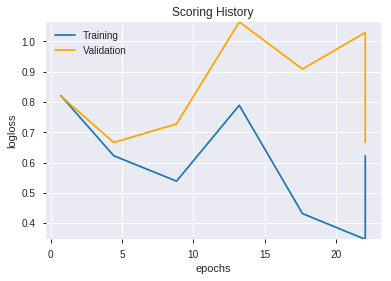

--2019-08-24 21:26:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_211721_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_211721_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'ROCR_20',
 'CDLLONGLINE',
 'ROC_24',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'STOCH_slowd',
 'WILLR_20',
 'ADXR_12',
 'BETA_14',
 'ROCR_14',
 'MINUS_DM_20',
 'BBANDS_middleband_20_2_3',
 'CORREL_20',
 'VAR_8',
 'MINUS_DI_8',
 'MFI_24',
 'STOCH_slowk',
 'LINEARREG_SLOPE_14',
 'WILLR_30',
 'ROCR_12',
 'ROCR_8',
 'ROCP_8',
 'LINEARREG_SLOPE_12',
 'PLUS_DM_30',
 'DX_14',
 'CCI_12',
 'DX_20',
 'CCI_30',
 'CCI_20',
 'BBANDS_upperband_14_7_4',
 'AROONOSC_24',
 'BBANDS_upperband_20_1_3',
 'CDLBELTHOLD',
 'MACD_hist',
 'MFI_12',
 'RSI_8',
 'ATR_14',
 'BBANDS_upperband_30_1_3',
 'MACDFIX_signal_14',
 'WILLR_24',
 'NATR_12',
 'STOCHF_fastd',
 'MINUS_DI_14',
 'PLUS_DI_30',
 'MFI_8',
 'STDDEV_8',
 'aroondown_14',
 'MINUS_DI_12',
 'aroonup_30',
 'PLUS_DM_20',
 'CDLSPINNINGTOP',
 'TRIX_14',
 'PLUS_DM_8',
 'ADX_12',
 'MINUS_DM_12',
 'VAR_14',
 'BBANDS_upperband_24_5_4',
 'CCI_14',
 'MFI_14',
 'ROC_30',
 'MACDFIX_hist_8',
 'BBANDS_upperband_14_4_5',
 'CORREL_14',
 'ADXR_14',
 'BBANDS_up

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190824_212652_model_1  0.728613  0.617233               0.29641  0.46207  0.213508

variable  relative_importance  scaled_importance  percentage
0              BOP             0.678283           1.000000    0.094992
1     STOCHF_fastk             0.413956           0.610300    0.057974
2           TRANGE             0.313814           0.462659    0.043949
3        PLUS_DM_8             0.276392           0.407487    0.038708
4          ROCR_12             0.274419           0.404579    0.038432
..             ...                  ...                ...         ...
62     MINUS_DI_14             0.008981           0.013241    0.001258
63     STOCH_slowd             0.008864           0.013069    0.001241
64          CCI_14             0.007932           0.011694    0.001111
65          ROC_24             0.006562           0.009675    0.000919
66  MACDFIX_hist_8             0.004632           0.006829    0.000649

[67 rows x 4 columns]

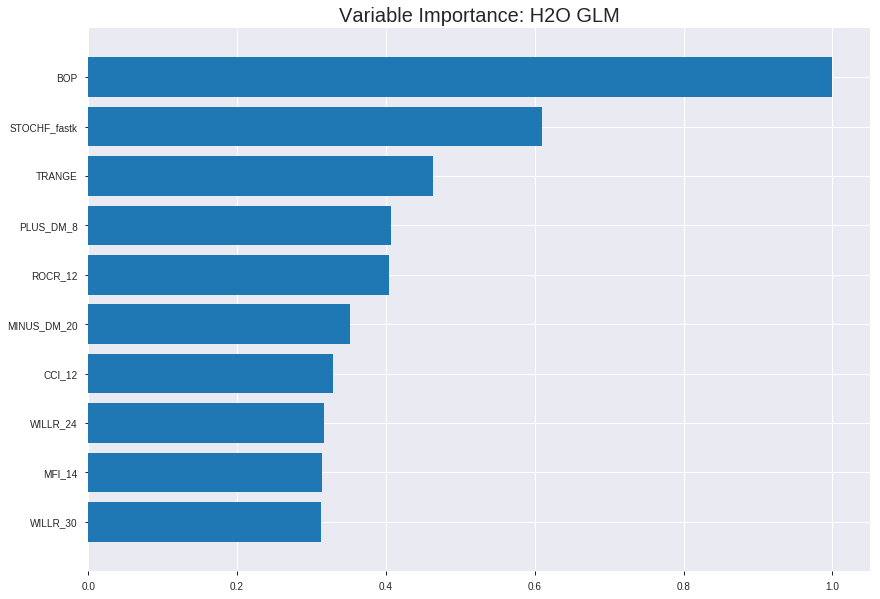

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_212652_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19959838081449405
RMSE: 0.4467643459526443
LogLoss: 0.5839264280527577
Null degrees of freedom: 1710
Residual degrees of freedom: 1643
Null deviance: 2363.666519940619
Residual deviance: 1998.1962367965373
AIC: 2134.196236796537
AUC: 0.7561420490430294
pr_auc: 0.7645874636346905
Gini: 0.5122840980860588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3867534511031723: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      365  431   0.5415   (431.0/796.0)
1      112  803   0.1224   (112.0/915.0)
Total  477  1234  0.3174   (543.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386753     0.747324  266
max f2                       0.220734     0.86276   347
max f0point5                 0.577064     0.712382  169
max accuracy                 0.483753     0.697253  215
max precision                0.939019     1         0
max recall                   0.0963478    1         394
max specificity              0.939019     1         0
max absolute_mcc             0.483753     0.389369  215
max min_per_class_accuracy   0.548789     0.680905  184
max mean_per_class_accuracy  0.483753     0.691288  215

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.886499           1.76606   1.76606            0.944444         0.90818   0.944444                    0.90818             0.0185792       0.0185792                  76.606    76.606
    2        0.0204559                   0.869284           1.75995   1.76309            0.941176         0.87596   0.942857                    0.89253             0.0174863       0.0360656                  75.9949   76.3091
    3        0.0303916                   0.859617           1.64995   1.7261             0.882353         0.863849  0.923077                    0.883154            0.0163934       0.052459                   64.9952   72.6103
    4        0.0403273                   0.852614           1.64995   1.70734            0.882353         0.855907  0.913043                    0.876441            0.0163934       0.0688525                  64.9952   70.7341
    5        0.050263                    0.837032           1.42996   1.65251            0.764706         0.843735  0.883721                    0.869975            0.0142077       0.0830601                  42.9958   65.251
    6        0.100526                    0.798437           1.58728   1.61989            0.848837         0.817973  0.866279                    0.843974            0.0797814       0.162842                   58.7279   61.9895
    7        0.150205                    0.770479           1.38596   1.54252            0.741176         0.784237  0.824903                    0.824217            0.0688525       0.231694                   38.5959   54.2523
    8        0.200468                    0.739429           1.43507   1.51558            0.767442         0.754075  0.810496                    0.80663             0.0721311       0.303825                   43.5074   51.5583
    9        0.300409                    0.679502           1.37785   1.46976            0.736842         0.70742   0.785992                    0.773624            0.137705        0.44153                    37.7854   46.9762
    10       0.400351                    0.617878           1.23569   1.41133            0.660819         0.650075  0.754745                    0.742782            0.123497        0.565027                   23.5695   41.1331
    11       0.500292                    0.557093           1.0826    1.34566            0.578947         0.589414  0.719626                    0.712144            0.108197        0.673224                   8.25999   34.5662
    12       0.600234                    0.479132           1.03886   1.29458            0.555556         0.518884  0.692308                    0.679966            0.103825        0.777049                   3.88585   29.4578
    13       0.700175                    0.402286           0.842022  1.22998            0.450292         0.440875  0.657763                    0.645838            0.084153        0.861202                   -15.7978  22.9981
    14       0.800117                    0.320059           0.656121  1.1583             0.350877         0.360806  0.61943                     0.610235            0.0655738       0.926776                   -34.3879  15.8301
    15       0.900058                    0.241734           0.492091  1.08433            0.263158         0.284714  0.57987                     0.57409             0.0491803       0.975956                   -50.7909  8.43255
    16       1                           0.0554566          0.240578  1                  0.128655         0.180712  0.534775                    0.534775           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19336685979233753
RMSE: 0.4397349881375572
LogLoss: 0.5710269100941745
Null degrees of freedom: 488
Residual degrees of freedom: 421
Null deviance: 673.9994524945296
Residual deviance: 558.4643180721026
AIC: 694.4643180721026
AUC: 0.7733323210851301
pr_auc: 0.7880171716400098
Gini: 0.5466646421702601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40159496780060544: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      107  115  0.518    (115.0/222.0)
1      27   240  0.1011   (27.0/267.0)
Total  134  355  0.2904   (142.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401595     0.771704  278
max f2                       0.194007     0.865007  370
max f0point5                 0.569175     0.742534  183
max accuracy                 0.454976     0.713701  253
max precision                0.928712     1         0
max recall                   0.0686601    1         398
max specificity              0.928712     1         0
max absolute_mcc             0.401595     0.425137  278
max min_per_class_accuracy   0.551159     0.698198  192
max mean_per_class_accuracy  0.569175     0.711686  183

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 53.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.860926           1.46517   1.46517            0.8              0.898122  0.8                         0.898122            0.0149813       0.0149813                  46.5169   46.5169
    2        0.0204499                   0.85055            1.83146   1.64831            1                0.85556   0.9                         0.876841            0.0187266       0.0337079                  83.1461   64.8315
    3        0.0306748                   0.84544            1.83146   1.70936            1                0.84841   0.933333                    0.867364            0.0187266       0.0524345                  83.1461   70.9363
    4        0.0408998                   0.835624           1.46517   1.64831            0.8              0.840107  0.9                         0.86055             0.0149813       0.0674157                  46.5169   64.8315
    5        0.0511247                   0.821614           1.83146   1.68494            1                0.828298  0.92                        0.854099            0.0187266       0.0861423                  83.1461   68.4944
    6        0.100204                    0.78363            1.60253   1.64458            0.875            0.80063   0.897959                    0.82791             0.0786517       0.164794                   60.2528   64.4577
    7        0.151329                    0.758874           1.53843   1.60872            0.84             0.772732  0.878378                    0.809269            0.0786517       0.243446                   53.8427   60.8715
    8        0.200409                    0.734221           1.29728   1.53245            0.708333         0.747     0.836735                    0.794019            0.0636704       0.307116                   29.7285   53.2447
    9        0.300613                    0.682335           1.45769   1.50753            0.795918         0.709553  0.823129                    0.765864            0.146067        0.453184                   45.7693   50.7529
    10       0.400818                    0.628696           1.04655   1.39228            0.571429         0.654562  0.760204                    0.738038            0.104869        0.558052                   4.6549    39.2284
    11       0.501022                    0.563484           1.34556   1.38294            0.734694         0.604049  0.755102                    0.711241            0.134831        0.692884                   34.5563   38.294
    12       0.599182                    0.507055           0.839419  1.2939             0.458333         0.535623  0.706485                    0.68247             0.082397        0.775281                   -16.0581  29.3899
    13       0.699387                    0.423839           0.934419  1.24239            0.510204         0.464939  0.678363                    0.651304            0.093633        0.868914                   -6.55813  24.2394
    14       0.799591                    0.333245           0.635405  1.16633            0.346939         0.379598  0.636829                    0.617254            0.0636704       0.932584                   -36.4595  16.6327
    15       0.899796                    0.244073           0.373767  1.07806            0.204082         0.287258  0.588636                    0.580504            0.0374532       0.970037                   -62.6233  7.80644
    16       1                           0.0259333          0.299014  1                  0.163265         0.164778  0.546012                    0.538846          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 21:26:53  0.000 sec   2            .18E2     68            1.3716823760582226  1.3677962517928761
     2019-08-24 21:26:53  0.016 sec   4            .11E2     68            1.3665383950543069  1.3621203266352706
     2019-08-24 21:26:53  0.030 sec   6            .71E1     68            1.359107008928892   1.3537971325770317
     2019-08-24 21:26:53  0.047 sec   8            .44E1     68            1.34874623982684    1.3420209526886975
     2019-08-24 21:26:53  0.061 sec   10           .27E1     68            1.3349612159967226  1.3260679910010855
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 21:26:53  0.250 sec   36           .56E-2    68            1.165009787007715   1.1426916156001412
     2019-08-24 21:26:53  0.265 sec   38           .35E-2    68            1.16292808150538    1.1439639209489252
     2019-08-24 21:26:53  0.279 sec   40           .22E-2    68            1.1613397416840476  1.1454886706132108
     2019-08-24 21:26:53  0.295 sec   42           .13E-2    68            1.160123336408807   1.1471136326581437
     2019-08-24 21:26:53  0.309 sec   44           .83E-3    68            1.1593056808571067  1.1489390176741991


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7020408163265306)

('F1', 0.7068273092369477)

('auc', 0.7286133724809822)

('logloss', 0.6172333736849654)

('mean_per_class_error', 0.2964099826504738)

('rmse', 0.4620695738152987)

('mse', 0.21350829104585173)

glm prediction progress: |████████████████████████████████████████████████| 100%


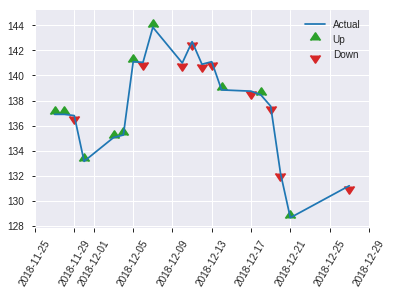


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21350829104585173
RMSE: 0.4620695738152987
LogLoss: 0.6172333736849654
Null degrees of freedom: 244
Residual degrees of freedom: 177
Null deviance: 342.0840315976776
Residual deviance: 302.44435310563307
AIC: 438.44435310563307
AUC: 0.7286133724809822
pr_auc: 0.6783252662305416
Gini: 0.45722674496196447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5373905612316905: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   43   0.3386   (43.0/127.0)
1      30   88   0.2542   (30.0/118.0)
Total  114  131  0.298    (73.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.537391     0.706827  130
max f2                       0.204412     0.833333  223
max f0point5                 0.606985     0.687732  104
max accuracy                 0.537391     0.702041  130
max precision                0.882202     1         0
max recall                   0.0965132    1         240
max specificity              0.882202     1         0
max absolute_mcc             0.537391     0.407888  130
max min_per_class_accuracy   0.555434     0.694915  119
max mean_per_class_accuracy  0.537391     0.70359   130

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 53.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0122449                   0.872029           2.07627   2.07627            1                0.878064  1                           0.878064            0.0254237       0.0254237                  107.627   107.627
    2        0.0204082                   0.861295           2.07627   2.07627            1                0.866753  1                           0.87354             0.0169492       0.0423729                  107.627   107.627
    3        0.0326531                   0.853278           0.69209   1.5572             0.333333         0.857575  0.75                        0.867553            0.00847458      0.0508475                  -30.791   55.7203
    4        0.0408163                   0.837575           0         1.24576            0                0.847126  0.6                         0.863468            0               0.0508475                  -100      24.5763
    5        0.0530612                   0.829868           2.07627   1.43742            1                0.832375  0.692308                    0.856292            0.0254237       0.0762712                  107.627   43.7419
    6        0.102041                    0.791305           1.5572    1.49492            0.75             0.808161  0.72                        0.833189            0.0762712       0.152542                   55.7203   49.4915
    7        0.15102                     0.767318           1.90325   1.62735            0.916667         0.778758  0.783784                    0.815536            0.0932203       0.245763                   90.3249   62.7348
    8        0.2                         0.746408           1.03814   1.48305            0.5              0.758597  0.714286                    0.801592            0.0508475       0.29661                    3.81356   48.3051
    9        0.302041                    0.700744           1.41186   1.459              0.68             0.721511  0.702703                    0.774538            0.144068        0.440678                   41.1864   45.9001
    10       0.4                         0.63274            1.29767   1.41949            0.625            0.666202  0.683673                    0.748006            0.127119        0.567797                   29.7669   41.9492
    11       0.502041                    0.548606           1.24576   1.38418            0.6              0.582551  0.666667                    0.714377            0.127119        0.694915                   24.5763   38.4181
    12       0.6                         0.48574            0.865113  1.29944            0.416667         0.522964  0.62585                     0.683126            0.0847458       0.779661                   -13.4887  29.9435
    13       0.697959                    0.416134           0.69209   1.21419            0.333333         0.44951   0.584795                    0.650338            0.0677966       0.847458                   -30.791   21.4194
    14       0.8                         0.324006           0.664407  1.14407            0.32             0.375952  0.55102                     0.61534             0.0677966       0.915254                   -33.5593  14.4068
    15       0.897959                    0.217647           0.432556  1.06645            0.208333         0.268765  0.513636                    0.577532            0.0423729       0.957627                   -56.7444  6.64484
    16       1                           0.0399431          0.415254  1                  0.2              0.15004   0.481633                    0.53391          

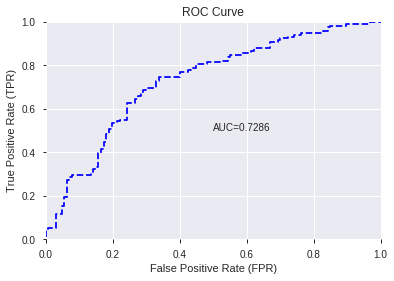

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


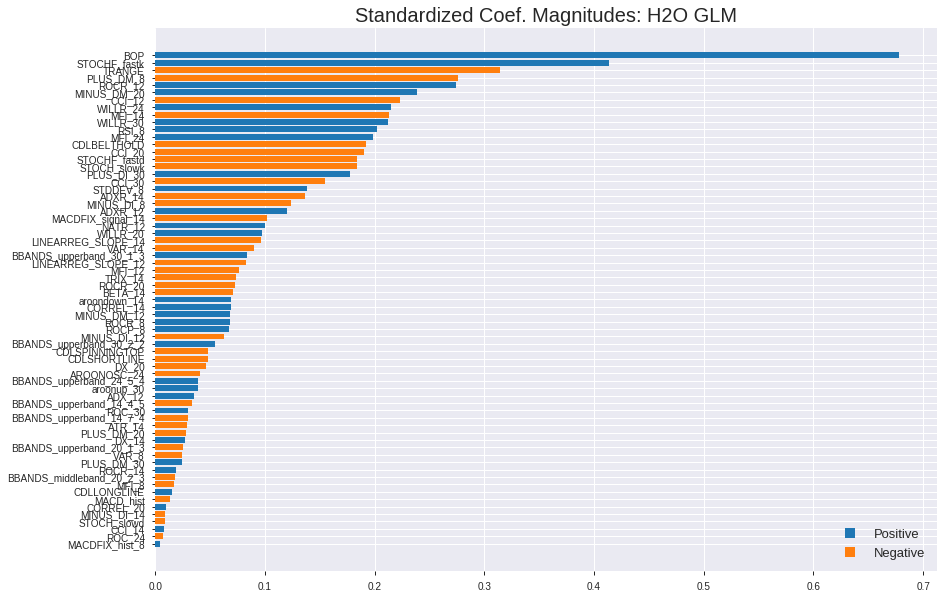

'log_likelihood'
--2019-08-24 21:26:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_212652_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_212652_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'PLUS_DM_8',
 'ROCR_12',
 'MINUS_DM_20',
 'CCI_12',
 'WILLR_24',
 'MFI_14',
 'WILLR_30',
 'RSI_8',
 'MFI_24',
 'CDLBELTHOLD',
 'CCI_20',
 'STOCHF_fastd',
 'STOCH_slowk',
 'PLUS_DI_30',
 'CCI_30',
 'STDDEV_8',
 'ADXR_14',
 'MINUS_DI_8',
 'ADXR_12',
 'MACDFIX_signal_14',
 'NATR_12',
 'WILLR_20',
 'LINEARREG_SLOPE_14',
 'VAR_14',
 'BBANDS_upperband_30_1_3',
 'LINEARREG_SLOPE_12',
 'MFI_12',
 'TRIX_14',
 'ROCR_20',
 'BETA_14',
 'aroondown_14',
 'CORREL_14',
 'MINUS_DM_12',
 'ROCR_8',
 'ROCP_8',
 'MINUS_DI_12',
 'BBANDS_upperband_30_2_2',
 'CDLSPINNINGTOP',
 'CDLSHORTLINE',
 'DX_20',
 'AROONOSC_24',
 'BBANDS_upperband_24_5_4',
 'aroonup_30',
 'ADX_12',
 'BBANDS_upperband_14_4_5',
 'ROC_30',
 'BBANDS_upperband_14_7_4',
 'ATR_14',
 'PLUS_DM_20',
 'DX_14',
 'BBANDS_upperband_20_1_3',
 'VAR_8',
 'PLUS_DM_30',
 'ROCR_14',
 'BBANDS_middleband_20_2_3',
 'MFI_8',
 'CDLLONGLINE',
 'MACD_hist',
 'CORREL_20',
 'MINUS_DI_14',
 'STOCH_slowd',
 'CCI_14',
 'ROC_24',
 '

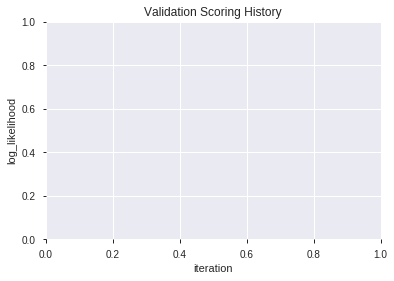

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_212703_model_4  0.700254  0.636164              0.316095  0.470662  0.221523
1  XGBoost_grid_1_AutoML_20190824_212703_model_7  0.697718  0.654704              0.309155  0.476940  0.227472
2  XGBoost_grid_1_AutoML_20190824_212703_model_3  0.694715  0.648340              0.360637  0.477107  0.227631
3               XGBoost_3_AutoML_20190824_212703  0.693380  0.650887              0.338816  0.477215  0.227734
4  XGBoost_grid_1_AutoML_20190824_212703_model_2  0.691979  0.648224              0.320032  0.476171  0.226739
5               XGBoost_2_AutoML_20190824_212703  0.688776  0.649116              0.323068  0.476229  0.226794
6  XGBoost_grid_1_AutoML_20190824_212703_model_1  0.686708  0.651447              0.323368  0.476134  0.226703
7  XGBoost_grid_1_AutoML_20190824_212703_model_6  0.677499  0.659155              0.343054  0.481831  0.232161
8               XGBoost_1_AutoML_20190824_212703  0.676632  0.662984              0.365174  0.482664  0.232964
9  XGBoost_grid_1_AutoML_20190824_212703_model_5  0.652409  0.701915              0.361838  0.497142  0.247150

variable  relative_importance  scaled_importance  percentage
0                        BOP          1803.444946           1.000000    0.346708
1                     TRANGE           439.569275           0.243739    0.084506
2               STOCHF_fastk           317.283813           0.175932    0.060997
3                    BETA_14           173.921921           0.096439    0.033436
4                STOCH_slowd           126.331451           0.070050    0.024287
5                     MFI_12           114.739761           0.063623    0.022058
6                   STDDEV_8           110.344933           0.061186    0.021214
7                     CCI_12           102.202698           0.056671    0.019648
8                STOCH_slowk            90.053947           0.049934    0.017313
9                MINUS_DM_20            75.659248           0.041953    0.014545
10                     DX_14            71.521706           0.039658    0.013750
11                   ROCR_12            70.184738           0.038917    0.013493
12                 CORREL_14            63.172276           0.035029    0.012145
13                   ADXR_12            58.348480           0.032354    0.011217
14                   ADXR_14            57.320724           0.031784    0.011020
15                PLUS_DI_30            53.818726           0.029842    0.010347
16        LINEARREG_SLOPE_12            53.579475           0.029710    0.010301
17                 PLUS_DM_8            52.605240           0.029169    0.010113
18                MINUS_DI_8            50.240604           0.027858    0.009659
19                    MFI_14            49.907379           0.027673    0.009595
20                     MFI_8            49.724220           0.027572    0.009559
21                PLUS_DM_20            49.210274           0.027287    0.009461
22         MACDFIX_signal_14            47.709869           0.026455    0.009172
23                    ROC_30            47.377224           0.026270    0.009108
24   BBANDS_upperband_24_5_4            46.950489           0.026034    0.009026
25                    CCI_14            46.079357           0.025551    0.008859
26                    VAR_14            45.201542           0.025064    0.008690
27                 CORREL_20            44.807835           0.024846    0.008614
28                    MFI_24            44.664551           0.024766    0.008587
29                 MACD_hist            44.245853           0.024534    0.008506
30                   ROCR_14            44.060524           0.024431    0.008471
31                     RSI_8            43.827049           0.024302    0.008426
32                PLUS_DM_30            43.501404           0.024121    0.008363
33                    ROC_24            42.956890           0.023819    0.008258
34                   NATR_12            42.188179           0.023393    0.008111
35                     DX_20            42.082432           0.023334    0.008090
36              aroondown_14            41.281639           0.022890    0.007936
37                    CCI_20            38.876297           0.021557    0.007474
38                    CCI_30            37.062004           0.020551    0.007125
39                  WILLR_24            34.877838           0.019340    0.006705
40   BBANDS_upperband_14_7_4            34.477837           0.019118    0.006628
41        LINEARREG_SLOPE_14            33.775494           0.018728    0.006493
42               CDLBELTHOLD            33.410397           0.018526    0.006423
43                   ROCR_20            32.243305           0.017879    0.006199
44   BBANDS_upperband_30_1_3            31.769609           0.017616    0.006108
45                   TRIX_14            28.366535           0.015729    0.005453
46               MINUS_DI_12            22.631176           0.012549    0.004351
47                    ATR_14            21.029572           0.011661    0.004043
48                  WILLR_30            21.010963  

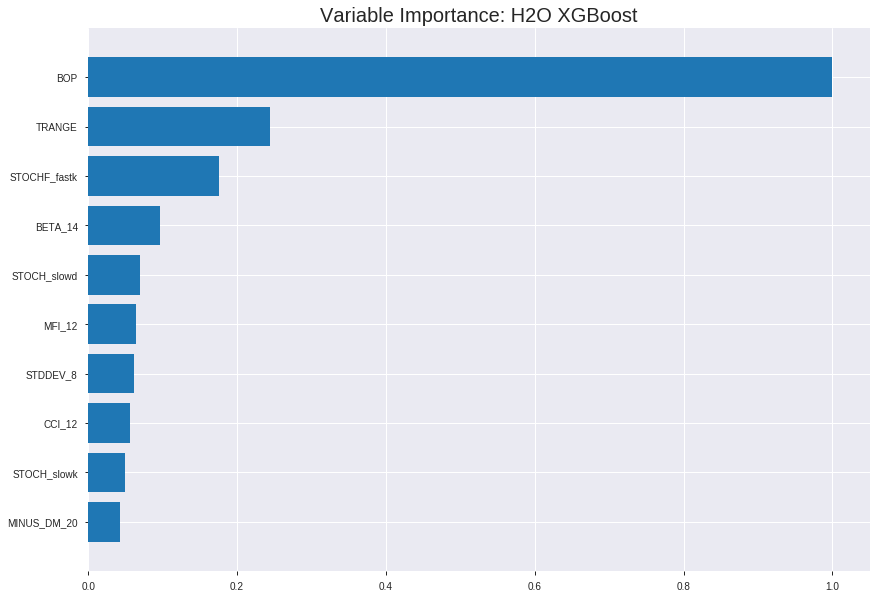

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_212703_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1767860735563741
RMSE: 0.4204593601721504
LogLoss: 0.5333651426649959
Mean Per-Class Error: 0.2515253864953181
AUC: 0.8244048109399457
pr_auc: 0.8402474435028731
Gini: 0.6488096218798913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.416851744055748: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      429  367   0.4611   (367.0/796.0)
1      96   819   0.1049   (96.0/915.0)
Total  525  1186  0.2706   (463.0/1711.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416852     0.779629  256
max f2                       0.25796      0.874903  337
max f0point5                 0.61264      0.774261  152
max accuracy                 0.537065     0.749854  194
max precision                0.881934     1         0
max recall                   0.177232     1         377
max specificity              0.881934     1         0
max absolute_mcc             0.537065     0.497117  194
max min_per_class_accuracy   0.551298     0.747541  188
max mean_per_class_accuracy  0.537065     0.748475  194

Gains/Lift Table: Avg response rate: 53.48 %, avg score: 53.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105202                   0.852393           1.86995    1.86995            1                0.86282   1                           0.86282             0.0196721       0.0196721                  86.9945   86.9945
    2        0.0204559                   0.840614           1.86995    1.86995            1                0.845479  1                           0.854398            0.0185792       0.0382514                  86.9945   86.9945
    3        0.0303916                   0.830797           1.86995    1.86995            1                0.836402  1                           0.848514            0.0185792       0.0568306                  86.9945   86.9945
    4        0.0403273                   0.821171           1.86995    1.86995            1                0.825495  1                           0.842843            0.0185792       0.0754098                  86.9945   86.9945
    5        0.050263                    0.81044            1.75995    1.8482             0.941176         0.814715  0.988372                    0.837283            0.0174863       0.0928962                  75.9949   84.8202
    6        0.100526                    0.784295           1.78297    1.81559            0.953488         0.797552  0.97093                     0.817417            0.0896175       0.182514                   78.2971   81.5586
    7        0.150205                    0.754316           1.53995    1.72442            0.823529         0.769765  0.922179                    0.801657            0.0765027       0.259016                   53.9955   72.4424
    8        0.200468                    0.732495           1.56554    1.68459            0.837209         0.74251   0.900875                    0.786827            0.0786885       0.337705                   56.5536   68.4586
    9        0.300409                    0.673655           1.39973    1.58982            0.748538         0.701327  0.850195                    0.758382            0.139891        0.477596                   39.9725   58.9817
    10       0.400351                    0.623307           1.35598    1.53144            0.725146         0.647886  0.818978                    0.730799            0.135519        0.613115                   35.5984   53.1444
    11       0.500292                    0.560028           1.13728    1.4527             0.608187         0.593771  0.776869                    0.703425            0.113661        0.726776                   13.7277   45.2703
    12       0.600234                    0.490923           0.896699   1.36013            0.479532         0.525714  0.727361                    0.673835            0.0896175       0.816393                   -10.3301  36.0126
    13       0.700175                    0.407722           0.809216   1.28149            0.432749         0.449879  0.685309                    0.641868            0.0808743       0.897268                   -19.0784  28.149
    14       0.800117                    0.320285           0.568638   1.19245            0.304094         0.3614    0.637692                    0.606835            0.0568306       0.954098                   -43.1362  19.2449
    15       0.900058                    0.243119           0.360867   1.10011            0.192982         0.282277  0.588312                    0.570797            0.0360656       0.990164                   -63.9133  10.0111
    16       1                           0.0925101          0.0984182  1                  0.0526316        0.192565  0.534775                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1924306993891793
RMSE: 0.4386692368848986
LogLoss: 0.5698731399232221
Mean Per-Class Error: 0.2847201133717987
AUC: 0.778165806255694
pr_auc: 0.7812725864300398
Gini: 0.556331612511388
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.457497775554657: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  96   0.4324   (96.0/222.0)
1      38   229  0.1423   (38.0/267.0)
Total  164  325  0.274    (134.0/489.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457498     0.773649  256
max f2                       0.276374     0.867962  341
max f0point5                 0.527788     0.739514  215
max accuracy                 0.471948     0.725971  246
max precision                0.888009     1         0
max recall                   0.144348     1         398
max specificity              0.888009     1         0
max absolute_mcc             0.457498     0.448444  256
max min_per_class_accuracy   0.55762      0.700375  196
max mean_per_class_accuracy  0.471948     0.71528   246

Gains/Lift Table: Avg response rate: 54.60 %, avg score: 53.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102249                   0.848263           1.46517   1.46517            0.8              0.865415  0.8                         0.865415            0.0149813       0.0149813                  46.5169   46.5169
    2        0.0204499                   0.824402           1.46517   1.46517            0.8              0.836523  0.8                         0.850969            0.0149813       0.0299625                  46.5169   46.5169
    3        0.0306748                   0.820763           1.83146   1.58727            1                0.822958  0.866667                    0.841632            0.0187266       0.0486891                  83.1461   58.7266
    4        0.0408998                   0.814189           1.83146   1.64831            1                0.817675  0.9                         0.835643            0.0187266       0.0674157                  83.1461   64.8315
    5        0.0511247                   0.80745            1.09888   1.53843            0.6              0.809813  0.84                        0.830477            0.011236        0.0786517                  9.88764   53.8427
    6        0.100204                    0.775898           1.75515   1.64458            0.958333         0.789947  0.897959                    0.810626            0.0861423       0.164794                   75.515    64.4577
    7        0.151329                    0.756906           1.61169   1.63346            0.88             0.766875  0.891892                    0.795845            0.082397        0.247191                   61.1685   63.3465
    8        0.200409                    0.729313           1.44991   1.58851            0.791667         0.744422  0.867347                    0.783251            0.071161        0.318352                   44.9906   58.8512
    9        0.300613                    0.678403           1.27081   1.48261            0.693878         0.704954  0.809524                    0.757152            0.127341        0.445693                   27.0809   48.2611
    10       0.400818                    0.633115           1.30819   1.439              0.714286         0.653241  0.785714                    0.731174            0.131086        0.576779                   30.8186   43.9005
    11       0.501022                    0.563457           1.04655   1.36051            0.571429         0.599617  0.742857                    0.704863            0.104869        0.681648                   4.6549    36.0514
    12       0.599182                    0.49074            1.10651   1.3189             0.604167         0.531128  0.720137                    0.676401            0.108614        0.790262                   10.6507   31.8902
    13       0.699387                    0.427862           0.897042  1.25846            0.489796         0.462108  0.687135                    0.645698            0.0898876       0.88015                    -10.2958  25.846
    14       0.799591                    0.339204           0.598028  1.17569            0.326531         0.38757   0.641944                    0.61335             0.0599251       0.940075                   -40.1972  17.5695
    15       0.899796                    0.246974           0.336391  1.08223            0.183673         0.293737  0.590909                    0.577757            0.0337079       0.973783                   -66.3609  8.22268
    16       1                           0.139454           0.261637  1                  0.142857         0.199662  0.546012                    0.53987           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 21:27:10  2.685 sec   0                  0.5              0.693147            0.5             0                  1                0.465225                         0.5                0.693147              0.5               0                    1                  0.453988
    2019-08-24 21:27:10  2.746 sec   5                  0.481414         0.656492            0.765108        0.777208           1.86995          0.318527                         0.48229            0.658233              0.77092           0.771819             1.56982            0.294479
    2019-08-24 21:27:10  2.792 sec   10                 0.467932         0.630146            0.772833        0.791159           1.86995          0.303331                         0.469665           0.633642              0.774876          0.793158             1.83146            0.271984
    2019-08-24 21:27:10  2.834 sec   15                 0.458041         0.610666            0.779963        0.79641            1.86995          0.308591                         0.460642           0.615958              0.773509          0.784858             1.46517            0.278119
    2019-08-24 21:27:10  2.880 sec   20                 0.450652         0.595786            0.784304        0.801979           1.86995          0.308591                         0.454673           0.604063              0.775011          0.78303              1.46517            0.284254
    2019-08-24 21:27:10  2.929 sec   25                 0.44546          0.585165            0.789654        0.808064           1.86995          0.302747                         0.450953           0.596389              0.772784          0.785332             1.46517            0.278119
    2019-08-24 21:27:10  2.981 sec   30                 0.441311         0.576419            0.792674        0.812144           1.86995          0.300994                         0.447213           0.58867               0.77394           0.784369             1.46517            0.271984
    2019-08-24 21:27:10  3.034 sec   35                 0.437679         0.568693            0.796015        0.815108           1.86995          0.295733                         0.445276           0.584458              0.773493          0.783396             1.46517            0.284254
    2019-08-24 21:27:10  3.084 sec   40                 0.434893         0.562848            0.799776        0.817476           1.86995          0.287551                         0.443103           0.580034              0.777052          0.786063             1.46517            0.265849
    2019-08-24 21:27:10  3.159 sec   45                 0.432105         0.557203            0.805181        0.822811           1.86995          0.286967                         0.442667           0.578848              0.776133          0.785492             1.46517            0.286299
    2019-08-24 21:27:10  3.247 sec   50                 0.429538         0.551844            0.808635        0.824695           1.86995          0.280538                         0.440827           0.574899              0.778402          0.788553             1.46517            0.271984
    2019-08-24 21:27:10  3.337 sec   55                 0.427039         0.546694            0.813182        0.828079           1.86995          0.285213                         0.439824           0.572646              0.779136          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1803.4449462890625     1.0                    0.34670768125145823
TRANGE                   439.56927490234375     0.24373867126182183    0.08450606954449769
STOCHF_fastk             317.2838134765625      0.17593207606887887    0.06099700215159616
BETA_14                  173.9219207763672      0.09643871920473383    0.033436044718333745
STOCH_slowd              126.33145141601562     0.07005007370808135    0.024286898626822623
---                      ---                    ---                    ---
BBANDS_upperband_14_4_5  11.904450416564941     0.006600950276336772   0.0022886001643648945
MACDFIX_hist_8           6.7101287841796875     0.0037207283748733654  0.001290005107418851
BBANDS_upperband_20_1_3  6.526515483856201      0.003618915840644746   0.0012547059197541117
MINUS_DI_14              5.291947364807129      0.0029343548167058476  0.001017363354469132
aroonup_30               1.6447429656982422     0.0009120006513548526  0.00031619763113106055


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6816326530612244)

('F1', 0.6929133858267716)

('auc', 0.7002535699986654)

('logloss', 0.6361641971837693)

('mean_per_class_error', 0.3160950220205525)

('rmse', 0.47066210530156105)

('mse', 0.22152281736689775)

xgboost prediction progress: |████████████████████████████████████████████| 100%


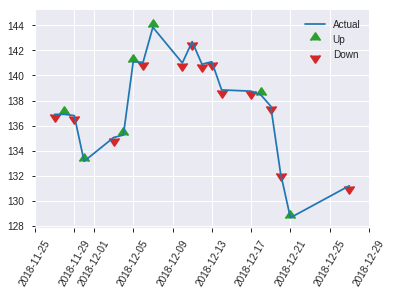


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22152281736689775
RMSE: 0.47066210530156105
LogLoss: 0.6361641971837693
Mean Per-Class Error: 0.3160950220205525
AUC: 0.7002535699986654
pr_auc: 0.6456130831188163
Gini: 0.4005071399973308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46015220880508423: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   48   0.378    (48.0/127.0)
1      30   88   0.2542   (30.0/118.0)
Total  109  136  0.3184   (78.0/245.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460152     0.692913  135
max f2                       0.189669     0.830986  237
max f0point5                 0.572842     0.669492  117
max accuracy                 0.572842     0.681633  117
max precision                0.816568     0.777778  8
max recall                   0.189669     1         237
max specificity              0.844928     0.992126  0
max absolute_mcc             0.460152     0.369814  135
max min_per_class_accuracy   0.568784     0.677165  120
max mean_per_class_accuracy  0.460152     0.683905  135

Gains/Lift Table: Avg response rate: 48.16 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0122449                   0.830158           0.69209   0.69209            0.333333         0.836647  0.333333                    0.836647            0.00847458      0.00847458                 -30.791    -30.791
    2        0.0204082                   0.822841           2.07627   1.24576            1                0.826429  0.6                         0.83256             0.0169492       0.0254237                  107.627    24.5763
    3        0.0326531                   0.818873           2.07627   1.5572             1                0.821186  0.75                        0.828295            0.0254237       0.0508475                  107.627    55.7203
    4        0.0408163                   0.811895           1.03814   1.45339            0.5              0.815979  0.7                         0.825831            0.00847458      0.059322                   3.81356    45.339
    5        0.0530612                   0.800306           1.38418   1.43742            0.666667         0.805074  0.692308                    0.821041            0.0169492       0.0762712                  38.4181    43.7419
    6        0.102041                    0.768319           1.38418   1.41186            0.666667         0.780304  0.68                        0.801488            0.0677966       0.144068                   38.4181    41.1864
    7        0.15102                     0.756073           1.73023   1.51512            0.833333         0.761457  0.72973                     0.788505            0.0847458       0.228814                   73.0226    51.5117
    8        0.2                         0.736093           1.73023   1.5678             0.833333         0.746353  0.755102                    0.778182            0.0847458       0.313559                   73.0226    56.7797
    9        0.302041                    0.7                0.99661   1.37483            0.48             0.719316  0.662162                    0.758295            0.101695        0.415254                   -0.338983  37.4828
    10       0.4                         0.650545           1.38418   1.37712            0.666667         0.675884  0.663265                    0.738112            0.135593        0.550847                   38.4181    37.7119
    11       0.502041                    0.55662            1.24576   1.35042            0.6              0.604781  0.650407                    0.711012            0.127119        0.677966                   24.5763    35.042
    12       0.6                         0.424283           0.778602  1.25706            0.375            0.477783  0.605442                    0.672934            0.0762712       0.754237                   -22.1398   25.7062
    13       0.697959                    0.364842           0.605579  1.16563            0.291667         0.391816  0.561404                    0.633479            0.059322        0.813559                   -39.4421   16.5626
    14       0.8                         0.292721           0.747458  1.11229            0.36             0.33267   0.535714                    0.595111            0.0762712       0.889831                   -25.2542   11.2288
    15       0.897959                    0.233012           0.519068  1.04757            0.25             0.261553  0.504545                    0.558722            0.0508475       0.940678                   -48.0932   4.75732
    16       1                           0.153975           0.581356  1                  0.28             0.202921  0.481633                    0.

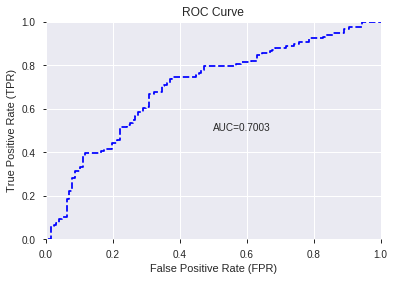

This function is available for GLM models only


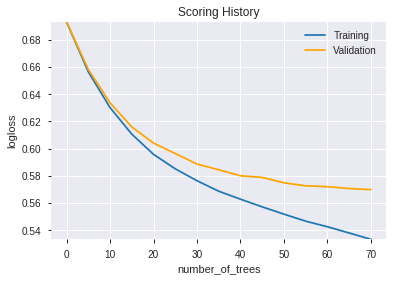

--2019-08-24 21:27:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_212703_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_212703_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_89e6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'BETA_14',
 'STOCH_slowd',
 'MFI_12',
 'STDDEV_8',
 'CCI_12',
 'STOCH_slowk',
 'MINUS_DM_20',
 'DX_14',
 'ROCR_12',
 'CORREL_14',
 'ADXR_12',
 'ADXR_14',
 'PLUS_DI_30',
 'LINEARREG_SLOPE_12',
 'PLUS_DM_8',
 'MINUS_DI_8',
 'MFI_14',
 'MFI_8',
 'PLUS_DM_20',
 'MACDFIX_signal_14',
 'ROC_30',
 'BBANDS_upperband_24_5_4',
 'CCI_14',
 'VAR_14',
 'CORREL_20',
 'MFI_24',
 'MACD_hist',
 'ROCR_14',
 'RSI_8',
 'PLUS_DM_30',
 'ROC_24',
 'NATR_12',
 'DX_20',
 'aroondown_14',
 'CCI_20',
 'CCI_30',
 'WILLR_24',
 'BBANDS_upperband_14_7_4',
 'LINEARREG_SLOPE_14',
 'CDLBELTHOLD',
 'ROCR_20',
 'BBANDS_upperband_30_1_3',
 'TRIX_14',
 'MINUS_DI_12',
 'ATR_14',
 'WILLR_30',
 'BBANDS_middleband_20_2_3',
 'AROONOSC_24',
 'ROCP_8',
 'MINUS_DM_12',
 'WILLR_20',
 'ADX_12',
 'BBANDS_upperband_14_4_5',
 'MACDFIX_hist_8',
 'BBANDS_upperband_20_1_3',
 'MINUS_DI_14',
 'aroonup_30']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.698
GLM             0.702
XGBoost         0.682
dtype: float64

DeepLearning    GLM  XGBoost
All          0.661  0.588    0.682
DLF          0.698  0.698    0.665
Fwe          0.686  0.698    0.673
RFE          0.673  0.702    0.682
XGBF         0.673  0.698    0.665





F1


DeepLearning    0.713
GLM             0.732
XGBoost         0.708
dtype: float64

DeepLearning    GLM  XGBoost
All          0.706  0.650    0.708
DLF          0.703  0.711    0.693
Fwe          0.713  0.732    0.698
RFE          0.711  0.707    0.693
XGBF         0.697  0.711    0.693





auc


DeepLearning    0.724
GLM             0.744
XGBoost         0.709
dtype: float64

DeepLearning    GLM  XGBoost
All          0.651  0.529    0.709
DLF          0.712  0.738    0.706
Fwe          0.724  0.744    0.698
RFE          0.706  0.729    0.700
XGBF         0.706  0.738    0.706





logloss


DeepLearning    4.020
GLM             6.088
XGBoost         0.638
dtype: float64

DeepLearning    GLM  XGBoost
All          4.020  6.088    0.633
DLF          0.640  0.608    0.637
Fwe          0.631  0.592    0.638
RFE          0.812  0.617    0.636
XGBF         0.658  0.608    0.637





mean_per_class_error


DeepLearning    0.333
GLM             0.416
XGBoost         0.335
dtype: float64

DeepLearning    GLM  XGBoost
All          0.333  0.416    0.318
DLF          0.304  0.302    0.335
Fwe          0.310  0.298    0.323
RFE          0.326  0.296    0.316
XGBF         0.325  0.302    0.335





rmse


DeepLearning    0.552
GLM             0.587
XGBoost         0.472
dtype: float64

DeepLearning    GLM  XGBoost
All          0.552  0.587    0.469
DLF          0.468  0.456    0.470
Fwe          0.466  0.452    0.472
RFE          0.522  0.462    0.471
XGBF         0.474  0.456    0.470





mse


DeepLearning    0.305
GLM             0.344
XGBoost         0.223
dtype: float64

DeepLearning    GLM  XGBoost
All          0.305  0.344    0.220
DLF          0.219  0.208    0.221
Fwe          0.217  0.204    0.223
RFE          0.273  0.214    0.222
XGBF         0.225  0.208    0.221

{'F1':       DeepLearning    GLM  XGBoost
 All          0.706    NaN      NaN
 DLF          0.703    NaN      NaN
 DLF            NaN  0.711      NaN
 DLF            NaN    NaN    0.693
 All            NaN  0.650      NaN
 All            NaN    NaN    0.708
 XGBF         0.697    NaN      NaN
 XGBF           NaN  0.711      NaN
 XGBF           NaN    NaN    0.693
 Fwe          0.713    NaN      NaN
 Fwe            NaN  0.732      NaN
 Fwe            NaN    NaN    0.698
 RFE          0.711    NaN      NaN
 RFE            NaN  0.707      NaN
 RFE            NaN    NaN    0.693,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.661    NaN      NaN
 DLF          0.698    NaN      NaN
 DLF            NaN  0.698      NaN
 DLF            NaN    NaN    0.665
 All            NaN  0.588      NaN
 All            NaN    NaN    0.682
 XGBF         0.673    NaN      NaN
 XGBF           NaN  0.698      NaN
 XGBF           NaN    NaN    0.665
 Fwe          0.686    NaN      NaN
 Fwe     